# Volatility and Multivariate Analysis

The document is divided into two parts. In the first part, the analysis of the historical Apple stock prices is presented and a model to forecast the stock’s volatility behavior is built. In the second part, the BEER model is laid out to determine the fair value of USDMXN currency pair.

In [2]:
import datetime
import io
import time
import warnings
from datetime import date, timedelta

import arch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM

warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Volatility Analysis

Forecasting the Apple daily stock return using a GARCH model (while using Yahoo Finance as the data source). The range of 2013 to 2018 is used to avoid major disruptions such as the credit crisis in 2008, Bernanke tapering in 2013, and the COVID pandemic in 2020. Also, this is a suitable range to measure volatility clustering in the return time series.

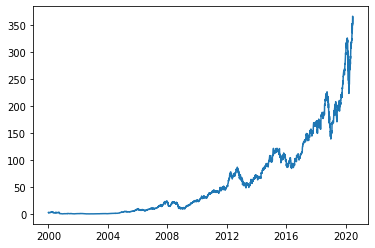

In [3]:
# Downloading the Prices
ticker = 'AAPL'
df_prices = yf.download(ticker, start='2000-01-01', end='2020-06-29', progress=False)
plt.plot(df_prices['Adj Close'])

*While the method is adaptable to any period, the full six-year period of 2013 to 2018 is chosen.*

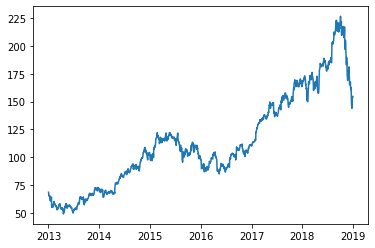

In [4]:
# clip the data to range
df_prices = df_prices[(df_prices.index >= '2013-01-01') & (df_prices.index <= '2018-12-31')]
plt.plot(df_prices['Adj Close'])

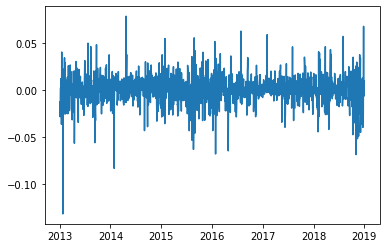

In [5]:
# compute and plot the log return
df_prices['returns'] = np.log(df_prices['Adj Close']).diff()
df_prices.dropna(inplace=True)
returns = df_prices['returns']
plt.plot(returns)

*The log return in above chart appears to be stationary with constant mean and some persistence in volatility. The following is to apply the ADF test to analytically confirm the stationarity, due to a low p-value.*

In [6]:
result = sm.tsa.adfuller(returns, 1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print("{:>6s}: {:.4f}".format(key, value))

ADF Statistic: -37.319837
p-value: 0.000000
Critical Values:
    1%: -3.4347
    5%: -2.8635
   10%: -2.5678


*The GARCH(1,1) is often the most efficient model, and a good starting point. One can later select the best model based on the AIC.*

In [7]:
garch_model_11 = arch_model(returns, mean='Constant', vol='GARCH', p=1, q=1, dist='StudentsT')
results = garch_model_11.fit(update_freq=5)
print(results.summary())

Iteration:      5,   Func. Count:     56,   Neg. LLF: -3359.274958029846
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3359.2835387119776
            Iterations: 10
            Function evaluations: 70
            Gradient evaluations: 6
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                3359.28
Distribution:      Standardized Student's t   AIC:                          -6708.57
Method:                  Maximum Likelihood   BIC:                          -6681.97
                                              No. Observations:                 1509
Date:                      Mon, Jul 13 2020   Df Residuals:                     1504
Time:                              0

*The Ljung-Box test was also run on the residuals and the squares of residuals, to see if they are autocorrelated. If the model can explain the process well, the p-value from Ljung-Box test is bigger than the threshold such that no autocorrelation is left in the residual.*

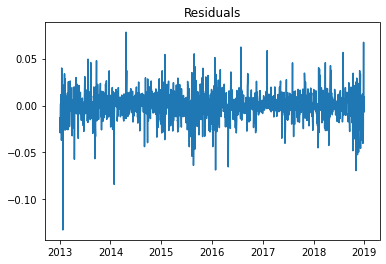

In [8]:
plt.plot(results.resid)
plt.title('Residuals')
plt.show()

In [9]:
print('Ljung-Box on residuals:')
lags = [10,15,20]
lbstats, pvalues = acorr_ljungbox(results.resid, lags=lags)
for l,s,p in zip(lags, lbstats, pvalues):
    print("Q({}): statistic={:.3f} p-value={:.4f}".format(l,s,p))

print()

print('Ljung-Box on residuals^2:')
lbstats, pvalues = acorr_ljungbox(results.resid**2, lags=lags)
for l,s,p in zip(lags, lbstats, pvalues):
    print("Q({}): statistic={:.3f} p-value={:.4f}".format(l,s,p))

Ljung-Box on residuals:
Q(10): statistic=23.483 p-value=0.0091
Q(15): statistic=26.021 p-value=0.0378
Q(20): statistic=30.223 p-value=0.0663

Ljung-Box on residuals^2:
Q(10): statistic=35.743 p-value=0.0001
Q(15): statistic=42.899 p-value=0.0002
Q(20): statistic=45.492 p-value=0.0009


In [10]:
cols = []
data = []
lags = [10,15,20]
for p in [1,2,3]:
    for q in [1,2]:
        name = 'GARCH({},{})'.format(p,q)
        cols.extend([(name, 'statistic'), (name, 'p-value')])
        # fit model, run Ljung-Box tests
        garch_model = arch_model(returns, mean='Constant', vol='GARCH', p=p, q=q)
        results = garch_model.fit(disp='off')
        lbstats_r, pvalues_r = acorr_ljungbox(results.resid, lags=lags)
        lbstats_r2, pvalues_r2 = acorr_ljungbox(results.resid**2, lags=lags)
        data.append(np.hstack([lbstats_r, lbstats_r2]))
        data.append(np.hstack([pvalues_r, pvalues_r2]))

# Print result in table
df = pd.DataFrame(np.array(data).T)
df.columns = pd.MultiIndex.from_tuples(cols)
df.index = pd.MultiIndex.from_tuples([(x,"Q({})".format(q)) for x in ['R', 'R^2'] for q in lags])
df

GARCH(1,1)           GARCH(1,2)  ... GARCH(3,1) GARCH(3,2)          
           statistic   p-value  statistic  ...    p-value  statistic   p-value
R   Q(10)  23.482918  0.009098  23.482918  ...   0.009098  23.482918  0.009098
    Q(15)  26.021258  0.037800  26.021258  ...   0.037800  26.021258  0.037800
    Q(20)  30.223094  0.066318  30.223094  ...   0.066318  30.223094  0.066318
R^2 Q(10)  36.301619  0.000075  36.265480  ...   0.000076  36.233688  0.000077
    Q(15)  43.784901  0.000119  43.727457  ...   0.000123  43.676937  0.000124
    Q(20)  46.510637  0.000686  46.444326  ...   0.000708  46.386033  0.000713

[6 rows x 12 columns]

*Below, different types of ARCH and GARCH models are set up and compared amongst them to find the best one. Based on AIC, the TARCH model was selected*

In [11]:
models = [
    # name.            model
    ('ARCH(1)',        arch_model(returns, mean='Constant', vol='GARCH', p=1, q=0, dist='StudentsT')),
    ('GARCH(1,1)',     arch_model(returns, mean='Constant', vol='GARCH', p=1, q=1, dist='StudentsT')),
    ('GJR-GARCH(1,1)', arch_model(returns, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='StudentsT')),
    ('TGARCH(1,1)',    arch_model(returns, mean='Constant', vol='GARCH', p=1, o=1, q=1, power=1., dist='StudentsT')),
    ('AVGARCH(1,1)',   arch_model(returns, mean='Constant', vol='GARCH', p=1, q=1, power=1., dist='StudentsT')),
    ('EGARCH(1,1)',    arch_model(returns, mean='Constant', vol='EGARCH', p=1, q=1, dist='StudentsT')),
]
for name, model in models:
    results = model.fit(disp='off')
    print("{:>14s}: AIC={:.2f}".format(name, results.aic))

       ARCH(1): AIC=-7242.34
    GARCH(1,1): AIC=-6708.57
GJR-GARCH(1,1): AIC=164518.07
   TGARCH(1,1): AIC=1259.14
  AVGARCH(1,1): AIC=147621.41
   EGARCH(1,1): AIC=-8617.14


In [12]:
final_model = arch_model(returns, mean='Constant', vol='EGARCH', p=1, q=1, dist='StudentsT')
final_results = final_model.fit(disp='off')
print(final_results.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                      returns   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                           EGARCH   Log-Likelihood:                4313.57
Distribution:      Standardized Student's t   AIC:                          -8617.14
Method:                  Maximum Likelihood   BIC:                          -8590.54
                                              No. Observations:                 1509
Date:                      Mon, Jul 13 2020   Df Residuals:                     1504
Time:                              00:02:14   Df Model:                            5
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

*A rolling window was implemented to test the volatility forecast against returns using the EGARCH model*

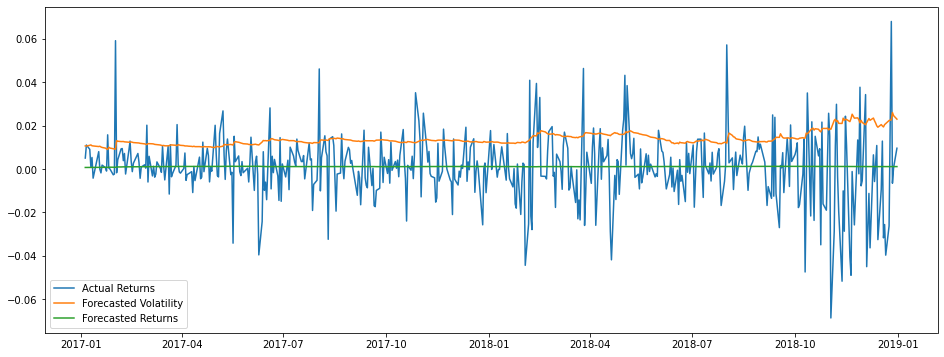

In [13]:
predictions_vol = []
predictions_ret = []
test_size = 500

for i in range(test_size):
    # a rolling window to check the last 500 observations
    train = returns[:-(test_size-i)]
    model = arch_model(train, mean='Constant', vol='EGARCH', p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    predictions_vol.append(np.sqrt(pred.variance.values[-1,:][0]))
    predictions_ret.append(pred.mean.values[-1,:][0])

predictions_vol = pd.Series(predictions_vol, index=returns.index[-test_size:])
predictions_ret = pd.Series(predictions_ret, index=returns.index[-test_size:])

plt.figure(figsize=(16,6))
plt.plot(returns[-test_size:])
plt.plot(predictions_vol)
plt.plot(predictions_ret)
plt.legend(['Actual Returns', 'Forecasted Volatility', 'Forecasted Returns'])

*Presenting the above in price scale instead of return:*

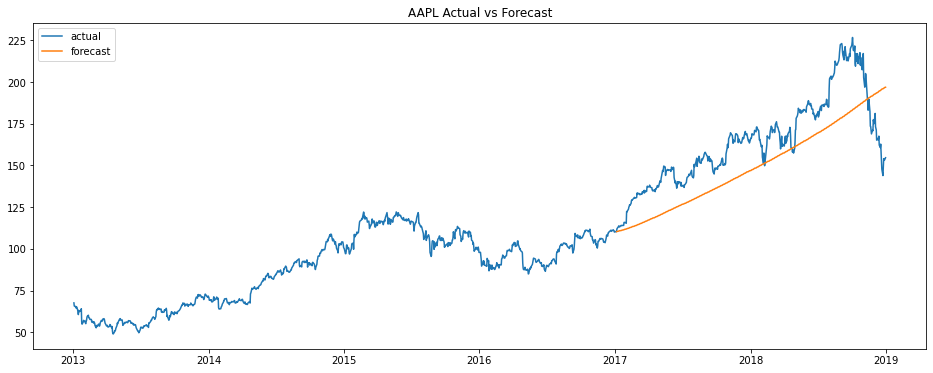

In [14]:
prev_close = df_prices["Adj Close"][-test_size-1]
forecast = np.exp(predictions_ret.cumsum()) * prev_close
plt.figure(figsize=(16,6))
plt.plot(df_prices["Adj Close"], label="actual")
plt.plot(forecast, label="forecast")
plt.title('{} Actual vs Forecast'.format(ticker))
plt.legend(loc='upper left')
plt.show()

## Multivariate Analysis

1. Describing the economic theories and models used to calculate equilibrium FX.
2. Indicating the macroeconomic variables used to determine the equilibrium FX.
3. Explaining the connection between linear regression and Vector Error Correction (VEC).
4. Calculating the equilibrium FX using BEER

*The currency used is Mexico Peso (USDMXN). The approach of fair value determination for USDMXN was used involving 3 different variables:*

- *10Y rate differential*
- *CPI differential*
- *Terms of Trade (ToT) differential*

*The 10Y rate differential expresses risk aversion and term premium. Therefore it is an expression of market sentiment. The CPI differential expresses the simple difference in YoY inflation on a monthly basis. The ToT is calculated by import and export prices on a monthly basis. The inflation and ToT data from Yahoo and Finnhub was used.*

#### CSV data

*Following are the data from Yahoo and Finnhub*

In [15]:
# combined data from Yahoo and Finnhub
CSVDATA = '''
date,USDMXN,10Y MX,10Y US,MX INF,US INF,TOT MX,TOT US
2006-10-23,10.8111,8.09,4.82,3.5,2.1,58.90,100.05
2006-10-24,10.7415,8.01,4.82,3.5,2.1,58.90,100.05
2006-10-25,10.7203,8.01,4.77,3.5,2.1,58.90,100.05
2006-10-26,10.7213,7.97,4.71,3.5,2.1,58.90,100.05
2006-10-27,10.7213,7.95,4.67,3.5,2.1,58.90,100.05
2006-10-30,10.736,8.01,4.67,3.5,2.1,58.90,100.05
2006-10-31,10.8,7.96,4.6,3.5,1.3,58.16,100.05
2006-11-01,10.8485,7.88,4.55,3.5,1.3,58.16,100.05
2006-11-02,10.79,7.88,4.59,3.5,1.3,58.16,100.05
2006-11-03,10.7891,7.91,4.71,3.5,1.3,58.16,100.05
2006-11-06,10.8285,7.93,4.7,3.5,1.3,58.16,100.05
2006-11-07,10.8305,7.91,4.65,3.5,1.3,58.16,100.05
2006-11-08,10.909,7.92,4.63,3.5,1.3,58.16,100.05
2006-11-09,10.877,7.92,4.63,3.5,1.3,58.16,100.05
2006-11-10,10.877,7.9,4.59,3.5,1.3,58.16,100.05
2006-11-13,10.839,7.84,4.6,3.5,1.3,58.16,100.05
2006-11-14,10.8233,7.79,4.56,3.5,1.3,58.16,100.05
2006-11-15,10.8938,7.78,4.61,3.5,1.3,58.16,100.05
2006-11-16,10.924,7.81,4.65,3.5,1.3,58.16,100.05
2006-11-17,10.924,7.83,4.6,3.5,1.3,58.16,100.05
2006-11-20,10.9485,7.83,4.59,3.5,1.3,58.16,100.05
2006-11-21,10.945,7.8,4.58,3.5,1.3,58.16,100.05
2006-11-22,10.9575,7.8,4.57,3.5,1.3,58.16,100.05
2006-11-23,11.0005,7.81,4.57,3.5,1.3,58.16,100.05
2006-11-24,11.0005,7.82,4.55,3.5,1.3,58.16,100.05
2006-11-27,11.0187,7.9,4.54,3.5,1.3,58.16,100.05
2006-11-28,10.993,7.86,4.51,3.5,1.3,58.16,100.05
2006-11-29,10.9605,7.85,4.52,3.5,1.3,58.16,100.05
2006-11-30,11.0055,7.76,4.46,3.5,2,57.98,100.05
2006-12-01,11.0055,7.76,4.42,3.5,2,57.98,100.05
2006-12-04,10.8498,7.69,4.43,3.5,2,57.98,100.05
2006-12-05,10.8255,7.59,4.44,3.5,2,57.98,100.05
2006-12-06,10.8835,7.51,4.48,3.5,2,57.98,100.05
2006-12-07,10.8028,7.52,4.48,3.5,2,57.98,100.05
2006-12-08,10.8028,7.45,4.55,3.5,2,57.98,100.05
2006-12-11,10.825,7.46,4.52,3.5,2,57.98,100.05
2006-12-12,10.8363,7.46,4.49,3.5,2,57.98,100.05
2006-12-13,10.7645,7.5,4.57,3.5,2,57.98,100.05
2006-12-14,10.754,7.5,4.59,3.5,2,57.98,100.05
2006-12-15,10.754,7.53,4.59,3.5,2,57.98,100.05
2006-12-18,10.83,7.54,4.59,3.5,2,57.98,100.05
2006-12-19,10.8213,7.47,4.6,3.5,2,57.98,100.05
2006-12-20,10.8606,7.46,4.59,3.5,2,57.98,100.05
2006-12-21,10.855,7.45,4.55,3.5,2,57.98,100.05
2006-12-22,10.855,7.47,4.62,3.5,2,57.98,100.05
2006-12-25,10.886,7.47,4.62,3.5,2,57.98,100.05
2006-12-26,10.8873,7.5,4.6,3.5,2,57.98,100.05
2006-12-27,10.85,7.49,4.65,3.5,2,57.98,100.05
2006-12-28,10.78,7.46,4.69,3.5,2,57.98,100.05
2006-12-29,10.78,7.42,4.71,3.5,2,57.98,100.05
2007-01-01,10.7625,7.42,4.71,3.6,2.5,58.45,101.63
2007-01-02,10.8235,7.44,4.69,3.6,2.5,58.45,101.63
2007-01-03,10.885,7.44,4.66,3.6,2.5,58.45,101.63
2007-01-04,10.9228,7.47,4.62,3.6,2.5,58.45,101.63
2007-01-05,10.9228,7.53,4.65,3.6,2.5,58.45,101.63
2007-01-08,11.004,7.57,4.66,3.6,2.5,58.45,101.63
2007-01-09,10.9588,7.63,4.65,3.6,2.5,58.45,101.63
2007-01-10,11.0073,7.67,4.68,3.6,2.5,58.45,101.63
2007-01-11,10.945,7.73,4.73,3.6,2.5,58.45,101.63
2007-01-12,10.945,7.78,4.77,3.6,2.5,58.45,101.63
2007-01-15,10.953,7.82,4.77,3.6,2.5,58.45,101.63
2007-01-16,10.9403,7.86,4.75,3.6,2.5,58.45,101.63
2007-01-17,10.9254,7.93,4.78,3.6,2.5,58.45,101.63
2007-01-18,10.8558,7.86,4.75,3.6,2.5,58.45,101.63
2007-01-19,10.8558,7.88,4.77,3.6,2.5,58.45,101.63
2007-01-22,10.9393,7.89,4.76,3.6,2.5,58.45,101.63
2007-01-23,10.919,7.92,4.8,3.6,2.5,58.45,101.63
2007-01-24,11.0495,7.92,4.81,3.6,2.5,58.45,101.63
2007-01-25,11.0223,7.95,4.86,3.6,2.5,58.45,101.63
2007-01-26,11.0223,8,4.88,3.6,2.5,58.45,101.63
2007-01-29,11.034,8.07,4.89,3.6,2.5,58.45,101.63
2007-01-30,10.996,7.97,4.87,3.6,2.5,58.45,101.63
2007-01-31,10.962,7.94,4.82,3.9,2.1,57.15,101.63
2007-02-01,10.927,7.87,4.83,3.9,2.1,57.15,101.63
2007-02-02,10.927,7.79,4.83,3.9,2.1,57.15,101.63
2007-02-05,10.927,7.79,4.81,3.9,2.1,57.15,101.63
2007-02-06,10.97,7.79,4.76,3.9,2.1,57.15,101.63
2007-02-07,10.9512,7.75,4.74,3.9,2.1,57.15,101.63
2007-02-08,10.9855,7.73,4.74,3.9,2.1,57.15,101.63
2007-02-09,10.98,7.73,4.78,3.9,2.1,57.15,101.63
2007-02-12,10.9458,7.73,4.8,3.9,2.1,57.15,101.63
2007-02-13,10.9209,7.69,4.81,3.9,2.1,57.15,101.63
2007-02-14,10.9755,7.66,4.73,3.9,2.1,57.15,101.63
2007-02-15,10.97,7.69,4.7,3.9,2.1,57.15,101.63
2007-02-16,10.97,7.71,4.69,3.9,2.1,57.15,101.63
2007-02-19,10.9912,7.7,4.69,3.9,2.1,57.15,101.63
2007-02-20,10.9892,7.7,4.68,3.9,2.1,57.15,101.63
2007-02-21,11.0064,7.7,4.69,3.9,2.1,57.15,101.63
2007-02-22,11.04,7.72,4.73,3.9,2.1,57.15,101.63
2007-02-23,11.04,7.81,4.68,3.9,2.1,57.15,101.63
2007-02-26,11.196,7.96,4.63,3.9,2.1,57.15,101.63
2007-02-27,11.1598,8.03,4.51,3.9,2.1,57.15,101.63
2007-02-28,11.16,8,4.55,4,2.4,57.00,101.63
2007-03-01,11.1876,7.96,4.55,4,2.4,57.00,101.63
2007-03-02,11.1876,7.92,4.51,4,2.4,57.00,101.63
2007-03-05,11.142,7.88,4.52,4,2.4,57.00,101.63
2007-03-06,11.1827,7.78,4.53,4,2.4,57.00,101.63
2007-03-07,11.1628,7.77,4.5,4,2.4,57.00,101.63
2007-03-08,11.111,7.8,4.5,4,2.4,57.00,101.63
2007-03-09,11.111,7.82,4.59,4,2.4,57.00,101.63
2007-03-12,11.1935,7.85,4.55,4,2.4,57.00,101.63
2007-03-13,11.1505,7.87,4.49,4,2.4,57.00,101.63
2007-03-14,11.1425,7.8,4.52,4,2.4,57.00,101.63
2007-03-15,11.177,7.78,4.53,4,2.4,57.00,101.63
2007-03-16,11.177,7.82,4.54,4,2.4,57.00,101.63
2007-03-19,11.1105,7.82,4.57,4,2.4,57.00,101.63
2007-03-20,11.0015,7.75,4.54,4,2.4,57.00,101.63
2007-03-21,10.9855,7.65,4.52,4,2.4,57.00,101.63
2007-03-22,11.0003,7.62,4.59,4,2.4,57.00,101.63
2007-03-23,11.0003,7.63,4.61,4,2.4,57.00,101.63
2007-03-26,11.058,7.66,4.58,4,2.4,57.00,101.63
2007-03-27,11.063,7.62,4.61,4,2.4,57.00,101.63
2007-03-28,11.0133,7.58,4.62,4,2.4,57.00,101.63
2007-03-29,11.02475,7.51,4.63,4,2.4,57.00,101.63
2007-03-30,11.02475,7.53,4.65,4,2.4,57.00,101.63
2007-04-02,10.9712,7.55,4.64,3.9,2.8,57.09,101.76
2007-04-03,11.013,7.51,4.66,3.9,2.8,57.09,101.76
2007-04-04,10.9875,7.52,4.65,3.9,2.8,57.09,101.76
2007-04-05,10.95175,7.52,4.67,3.9,2.8,57.09,101.76
2007-04-06,10.95175,7.52,4.75,3.9,2.8,57.09,101.76
2007-04-09,10.99,7.52,4.74,3.9,2.8,57.09,101.76
2007-04-10,11.01125,7.49,4.72,3.9,2.8,57.09,101.76
2007-04-11,10.99675,7.55,4.74,3.9,2.8,57.09,101.76
2007-04-12,10.981,7.53,4.73,3.9,2.8,57.09,101.76
2007-04-13,10.981,7.53,4.76,3.9,2.8,57.09,101.76
2007-04-16,10.979,7.55,4.73,3.9,2.8,57.09,101.76
2007-04-17,10.986,7.61,4.69,3.9,2.8,57.09,101.76
2007-04-18,10.9925,7.62,4.65,3.9,2.8,57.09,101.76
2007-04-19,10.96375,7.61,4.67,3.9,2.8,57.09,101.76
2007-04-20,10.96375,7.57,4.67,3.9,2.8,57.09,101.76
2007-04-23,10.979,7.56,4.65,3.9,2.8,57.09,101.76
2007-04-24,10.9239,7.6,4.62,3.9,2.8,57.09,101.76
2007-04-25,10.94365,7.52,4.64,3.9,2.8,57.09,101.76
2007-04-26,10.90175,7.44,4.68,3.9,2.8,57.09,101.76
2007-04-27,10.90175,7.64,4.7,3.9,2.8,57.09,101.76
2007-04-30,10.93025,7.72,4.63,3.7,2.6,57.72,101.76
2007-05-01,10.9105,7.72,4.64,3.7,2.6,57.72,101.76
2007-05-02,10.9105,7.8,4.64,3.7,2.6,57.72,101.76
2007-05-03,10.8609,7.76,4.67,3.7,2.6,57.72,101.76
2007-05-04,10.8609,7.8,4.64,3.7,2.6,57.72,101.76
2007-05-07,10.84075,7.75,4.63,3.7,2.6,57.72,101.76
2007-05-08,10.78725,7.72,4.63,3.7,2.6,57.72,101.76
2007-05-09,10.8445,7.65,4.68,3.7,2.6,57.72,101.76
2007-05-10,10.778,7.7,4.64,3.7,2.6,57.72,101.76
2007-05-11,10.778,7.67,4.67,3.7,2.6,57.72,101.76
2007-05-14,10.8024,7.66,4.69,3.7,2.6,57.72,101.76
2007-05-15,10.774,7.69,4.7,3.7,2.6,57.72,101.76
2007-05-16,10.80725,7.7,4.7,3.7,2.6,57.72,101.76
2007-05-17,10.78025,7.71,4.75,3.7,2.6,57.72,101.76
2007-05-18,10.78025,7.71,4.8,3.7,2.6,57.72,101.76
2007-05-21,10.79,7.68,4.78,3.7,2.6,57.72,101.76
2007-05-22,10.7965,7.72,4.82,3.7,2.6,57.72,101.76
2007-05-23,10.8335,7.75,4.85,3.7,2.6,57.72,101.76
2007-05-24,10.772,7.76,4.85,3.7,2.6,57.72,101.76
2007-05-25,10.772,7.69,4.86,3.7,2.6,57.72,101.76
2007-05-28,10.80875,7.63,4.86,3.7,2.6,57.72,101.76
2007-05-29,10.7405,7.6,4.87,3.7,2.6,57.72,101.76
2007-05-30,10.736,7.55,4.87,3.7,2.6,57.72,101.76
2007-05-31,10.69525,7.55,4.89,3.8,2.7,57.77,101.76
2007-06-01,10.69525,7.6,4.95,3.8,2.7,57.77,101.76
2007-06-04,10.803,7.57,4.92,3.8,2.7,57.77,101.76
2007-06-05,10.8582,7.59,4.97,3.8,2.7,57.77,101.76
2007-06-06,10.94675,7.68,4.96,3.8,2.7,57.77,101.76
2007-06-07,10.89175,7.72,5.09,3.8,2.7,57.77,101.76
2007-06-08,10.89175,7.72,5.11,3.8,2.7,57.77,101.76
2007-06-11,11.0063,7.69,5.13,3.8,2.7,57.77,101.76
2007-06-12,10.9178,7.79,5.24,3.8,2.7,57.77,101.76
2007-06-13,10.869,7.78,5.19,3.8,2.7,57.77,101.76
2007-06-14,10.755,7.73,5.21,3.8,2.7,57.77,101.76
2007-06-15,10.755,7.66,5.16,3.8,2.7,57.77,101.76
2007-06-18,10.7357,7.6,5.14,3.8,2.7,57.77,101.76
2007-06-19,10.83875,7.56,5.08,3.8,2.7,57.77,101.76
2007-06-20,10.8115,7.66,5.12,3.8,2.7,57.77,101.76
2007-06-21,10.82,7.68,5.16,3.8,2.7,57.77,101.76
2007-06-22,10.82,7.75,5.13,3.8,2.7,57.77,101.76
2007-06-25,10.8685,7.72,5.08,3.8,2.7,57.77,101.76
2007-06-26,10.8125,7.75,5.1,3.8,2.7,57.77,101.76
2007-06-27,10.79925,7.7,5.07,3.8,2.7,57.77,101.76
2007-06-28,10.7889,7.68,5.11,3.8,2.7,57.77,101.76
2007-06-29,10.7884,7.69,5.03,3.8,2.7,57.77,101.76
2007-07-02,10.76975,7.66,4.99,3.7,2.7,58.36,101.21
2007-07-03,10.7508,7.63,5.04,3.7,2.7,58.36,101.21
2007-07-04,10.7965,7.64,5.04,3.7,2.7,58.36,101.21
2007-07-05,10.7487,7.69,5.14,3.7,2.7,58.36,101.21
2007-07-06,10.7487,7.69,5.19,3.7,2.7,58.36,101.21
2007-07-09,10.8384,7.69,5.15,3.7,2.7,58.36,101.21
2007-07-10,10.7973,7.7,5.03,3.7,2.7,58.36,101.21
2007-07-11,10.7527,7.72,5.07,3.7,2.7,58.36,101.21
2007-07-12,10.741,7.71,5.11,3.7,2.7,58.36,101.21
2007-07-13,10.741,7.68,5.1,3.7,2.7,58.36,101.21
2007-07-16,10.7453,7.69,5.04,3.7,2.7,58.36,101.21
2007-07-17,10.73275,7.67,5.07,3.7,2.7,58.36,101.21
2007-07-18,10.74275,7.67,5,3.7,2.7,58.36,101.21
2007-07-19,10.77325,7.65,5.02,3.7,2.7,58.36,101.21
2007-07-20,10.77325,7.65,4.95,3.7,2.7,58.36,101.21
2007-07-23,10.8312,7.623,4.96,3.7,2.7,58.36,101.21
2007-07-24,10.8549,7.68,4.94,3.7,2.7,58.36,101.21
2007-07-25,10.967,7.69,4.9,3.7,2.7,58.36,101.21
2007-07-26,10.988,7.786,4.77,3.7,2.7,58.36,101.21
2007-07-27,10.988,7.77,4.78,3.7,2.7,58.36,101.21
2007-07-30,10.982,7.72,4.8,3.7,2.7,58.36,101.21
2007-07-31,10.93975,7.71,4.77,3.8,2.4,59.26,101.21
2007-08-01,10.93975,7.77,4.76,3.8,2.4,59.26,101.21
2007-08-02,10.983,7.8,4.75,3.8,2.4,59.26,101.21
2007-08-03,10.983,7.82,4.69,3.8,2.4,59.26,101.21
2007-08-06,10.949,7.812,4.72,3.8,2.4,59.26,101.21
2007-08-07,10.9195,7.792,4.74,3.8,2.4,59.26,101.21
2007-08-08,11.005,7.744,4.86,3.8,2.4,59.26,101.21
2007-08-09,10.9825,7.8,4.8,3.8,2.4,59.26,101.21
2007-08-10,10.9825,7.847,4.77,3.8,2.4,59.26,101.21
2007-08-13,11.087,7.832,4.77,3.8,2.4,59.26,101.21
2007-08-14,11.19,7.89,4.73,3.8,2.4,59.26,101.21
2007-08-15,11.1885,7.94,4.7,3.8,2.4,59.26,101.21
2007-08-16,11.0625,8.12,4.59,3.8,2.4,59.26,101.21
2007-08-17,11.0625,7.96,4.66,3.8,2.4,59.26,101.21
2007-08-20,11.1375,7.957,4.63,3.8,2.4,59.26,101.21
2007-08-21,11.04375,7.94,4.58,3.8,2.4,59.26,101.21
2007-08-22,11.06275,7.85,4.62,3.8,2.4,59.26,101.21
2007-08-23,10.987,7.83,4.61,3.8,2.4,59.26,101.21
2007-08-24,10.987,7.81,4.62,3.8,2.4,59.26,101.21
2007-08-27,11.1407,7.79,4.59,3.8,2.4,59.26,101.21
2007-08-28,11.072,7.87,4.52,3.8,2.4,59.26,101.21
2007-08-29,11.076,7.89,4.54,3.8,2.4,59.26,101.21
2007-08-30,11.01025,7.88,4.5,3.8,2.4,59.26,101.21
2007-08-31,11.01025,7.81,4.54,3.9,2,59.00,101.21
2007-09-03,11.0237,7.755,4.54,3.9,2,59.00,101.21
2007-09-04,11.07215,7.732,4.55,3.9,2,59.00,101.21
2007-09-05,11.05115,7.83,4.46,3.9,2,59.00,101.21
2007-09-06,11.122,7.82,4.49,3.9,2,59.00,101.21
2007-09-07,11.122,7.86,4.36,3.9,2,59.00,101.21
2007-09-10,11.07915,7.833,4.32,3.9,2,59.00,101.21
2007-09-11,11.1005,7.79,4.36,3.9,2,59.00,101.21
2007-09-12,11.107,7.78,4.4,3.9,2,59.00,101.21
2007-09-13,11.10225,7.79,4.48,3.9,2,59.00,101.21
2007-09-14,11.10225,7.82,4.46,3.9,2,59.00,101.21
2007-09-17,10.994,7.808,4.47,3.9,2,59.00,101.21
2007-09-18,10.9855,7.78,4.47,3.9,2,59.00,101.21
2007-09-19,10.98725,7.75,4.52,3.9,2,59.00,101.21
2007-09-20,10.9375,7.776,4.66,3.9,2,59.00,101.21
2007-09-21,10.9375,7.85,4.63,3.9,2,59.00,101.21
2007-09-24,10.92375,7.89,4.62,3.9,2,59.00,101.21
2007-09-25,10.915,7.89,4.61,3.9,2,59.00,101.21
2007-09-26,10.912,7.84,4.61,3.9,2,59.00,101.21
2007-09-27,10.91545,7.849,4.57,3.9,2,59.00,101.21
2007-09-28,10.91545,7.871,4.57,3.9,2,59.00,101.21
2007-10-01,10.896,7.884,4.55,3.8,2.8,59.76,100.01
2007-10-02,10.905,7.881,4.52,3.8,2.8,59.76,100.01
2007-10-03,10.8726,7.88,4.54,3.8,2.8,59.76,100.01
2007-10-04,10.829,7.872,4.52,3.8,2.8,59.76,100.01
2007-10-05,10.829,7.91,4.64,3.8,2.8,59.76,100.01
2007-10-08,10.824,7.873,4.64,3.8,2.8,59.76,100.01
2007-10-09,10.8205,7.815,4.65,3.8,2.8,59.76,100.01
2007-10-10,10.82925,7.85,4.64,3.8,2.8,59.76,100.01
2007-10-11,10.7895,7.82,4.65,3.8,2.8,59.76,100.01
2007-10-12,10.7895,7.82,4.68,3.8,2.8,59.76,100.01
2007-10-15,10.81225,7.816,4.67,3.8,2.8,59.76,100.01
2007-10-16,10.81325,7.835,4.65,3.8,2.8,59.76,100.01
2007-10-17,10.77675,7.851,4.54,3.8,2.8,59.76,100.01
2007-10-18,10.8075,7.85,4.49,3.8,2.8,59.76,100.01
2007-10-19,10.8075,7.84,4.4,3.8,2.8,59.76,100.01
2007-10-22,10.82025,7.83,4.39,3.8,2.8,59.76,100.01
2007-10-23,10.829,7.81,4.4,3.8,2.8,59.76,100.01
2007-10-24,10.8085,7.85,4.33,3.8,2.8,59.76,100.01
2007-10-25,10.715,7.84,4.35,3.8,2.8,59.76,100.01
2007-10-26,10.715,7.799,4.38,3.8,2.8,59.76,100.01
2007-10-29,10.73,7.8,4.38,3.8,2.8,59.76,100.01
2007-10-30,10.6491,7.82,4.37,3.8,2.8,59.76,100.01
2007-10-31,10.7075,7.87,4.46,3.9,3.5,60.77,100.01
2007-11-01,10.6725,7.93,4.35,3.9,3.5,60.77,100.01
2007-11-02,10.672,7.93,4.29,3.9,3.5,60.77,100.01
2007-11-05,10.6942,7.96,4.31,3.9,3.5,60.77,100.01
2007-11-06,10.7875,7.95,4.35,3.9,3.5,60.77,100.01
2007-11-07,10.8033,7.98,4.33,3.9,3.5,60.77,100.01
2007-11-08,10.871,7.97,4.27,3.9,3.5,60.77,100.01
2007-11-09,10.871,7.98,4.21,3.9,3.5,60.77,100.01
2007-11-12,10.849,7.969,4.21,3.9,3.5,60.77,100.01
2007-11-13,10.89675,7.96,4.26,3.9,3.5,60.77,100.01
2007-11-14,10.93425,7.974,4.26,3.9,3.5,60.77,100.01
2007-11-15,10.91125,8.016,4.16,3.9,3.5,60.77,100.01
2007-11-16,10.91125,8.015,4.15,3.9,3.5,60.77,100.01
2007-11-19,10.961,8.015,4.08,3.9,3.5,60.77,100.01
2007-11-20,10.9825,8.08,4.05,3.9,3.5,60.77,100.01
2007-11-21,10.96525,8.11,4.01,3.9,3.5,60.77,100.01
2007-11-22,10.9535,8.12,4.01,3.9,3.5,60.77,100.01
2007-11-23,10.9535,8.07,4.01,3.9,3.5,60.77,100.01
2007-11-26,10.96134,8.068,3.85,3.9,3.5,60.77,100.01
2007-11-27,10.92225,8.08,3.94,3.9,3.5,60.77,100.01
2007-11-28,10.91075,7.99,4.02,3.9,3.5,60.77,100.01
2007-11-29,10.90075,8,3.94,3.9,3.5,60.77,100.01
2007-11-30,10.90075,7.95,3.96,3.9,4.3,61.30,100.01
2007-12-03,10.88175,7.942,3.89,3.9,4.3,61.30,100.01
2007-12-04,10.84,7.96,3.89,3.9,4.3,61.30,100.01
2007-12-05,10.82425,7.93,3.9,3.9,4.3,61.30,100.01
2007-12-06,10.8025,7.91,4,3.9,4.3,61.30,100.01
2007-12-07,10.8025,7.95,4.11,3.9,4.3,61.30,100.01
2007-12-10,10.8755,7.932,4.14,3.9,4.3,61.30,100.01
2007-12-11,10.8355,7.948,3.99,3.9,4.3,61.30,100.01
2007-12-12,10.8247,7.948,4.07,3.9,4.3,61.30,100.01
2007-12-13,10.812,8,4.17,3.9,4.3,61.30,100.01
2007-12-14,10.812,8.03,4.23,3.9,4.3,61.30,100.01
2007-12-17,10.84295,8.056,4.19,3.9,4.3,61.30,100.01
2007-12-18,10.835,8.11,4.11,3.9,4.3,61.30,100.01
2007-12-19,10.82365,8.09,4.07,3.9,4.3,61.30,100.01
2007-12-20,10.805,8.07,4.03,3.9,4.3,61.30,100.01
2007-12-21,10.805,8.09,4.17,3.9,4.3,61.30,100.01
2007-12-24,10.79,8.07,4.21,3.9,4.3,61.30,100.01
2007-12-25,10.80075,8.07,4.21,3.9,4.3,61.30,100.01
2007-12-26,10.87475,8.08,4.28,3.9,4.3,61.30,100.01
2007-12-27,10.8835,8.12,4.2,3.9,4.3,61.30,100.01
2007-12-28,10.8835,8.14,4.09,3.9,4.3,61.30,100.01
2007-12-31,10.89755,8.17,4.03,3.9,4.1,61.03,97.21
2008-01-01,10.91,8.17,4.03,3.9,4.1,61.03,97.21
2008-01-02,10.88,8.19,3.89,3.9,4.1,61.03,97.21
2008-01-03,10.90375,8.18,3.9,3.9,4.1,61.03,97.21
2008-01-04,10.90375,8.2,3.85,3.9,4.1,61.03,97.21
2008-01-07,10.92225,8.18,3.83,3.9,4.1,61.03,97.21
2008-01-08,10.9336,8.16,3.83,3.9,4.1,61.03,97.21
2008-01-09,10.92875,8.19,3.79,3.9,4.1,61.03,97.21
2008-01-10,10.9215,8.14,3.88,3.9,4.1,61.03,97.21
2008-01-11,10.9215,8.12,3.8,3.9,4.1,61.03,97.21
2008-01-14,10.94225,8.06,3.78,3.9,4.1,61.03,97.21
2008-01-15,10.93455,8.04,3.69,3.9,4.1,61.03,97.21
2008-01-16,10.9457,8.01,3.71,3.9,4.1,61.03,97.21
2008-01-17,10.8845,7.95,3.63,3.9,4.1,61.03,97.21
2008-01-18,10.8845,7.9,3.64,3.9,4.1,61.03,97.21
2008-01-21,10.92575,7.84,3.64,3.9,4.1,61.03,97.21
2008-01-22,10.91274,7.72,3.48,3.9,4.1,61.03,97.21
2008-01-23,10.88648,7.66,3.42,3.9,4.1,61.03,97.21
2008-01-24,10.87876,7.65,3.64,3.9,4.1,61.03,97.21
2008-01-25,10.87876,7.72,3.58,3.9,4.1,61.03,97.21
2008-01-28,10.8438,7.67,3.58,3.9,4.1,61.03,97.21
2008-01-29,10.8365,7.63,3.65,3.9,4.1,61.03,97.21
2008-01-30,10.8255,7.61,3.73,3.9,4.1,61.03,97.21
2008-01-31,10.79,7.64,3.63,3.8,4.3,60.45,97.21
2008-02-01,10.79,7.61,3.59,3.8,4.3,60.45,97.21
2008-02-04,10.84075,7.61,3.64,3.8,4.3,60.45,97.21
2008-02-05,10.814,7.6,3.58,3.8,4.3,60.45,97.21
2008-02-06,10.765,7.55,3.61,3.8,4.3,60.45,97.21
2008-02-07,10.74225,7.48,3.73,3.8,4.3,60.45,97.21
2008-02-08,10.74225,7.45,3.64,3.8,4.3,60.45,97.21
2008-02-11,10.75925,7.46,3.61,3.8,4.3,60.45,97.21
2008-02-12,10.74,7.49,3.67,3.8,4.3,60.45,97.21
2008-02-13,10.7555,7.53,3.68,3.8,4.3,60.45,97.21
2008-02-14,10.74,7.56,3.81,3.8,4.3,60.45,97.21
2008-02-15,10.74,7.51,3.77,3.8,4.3,60.45,97.21
2008-02-18,10.75849,7.5,3.77,3.8,4.3,60.45,97.21
2008-02-19,10.777,7.55,3.86,3.8,4.3,60.45,97.21
2008-02-20,10.80226,7.57,3.9,3.8,4.3,60.45,97.21
2008-02-21,10.753,7.59,3.77,3.8,4.3,60.45,97.21
2008-02-22,10.75575,7.63,3.77,3.8,4.3,60.45,97.21
2008-02-25,10.72475,7.62,3.89,3.8,4.3,60.45,97.21
2008-02-26,10.694,7.59,3.85,3.8,4.3,60.45,97.21
2008-02-27,10.66925,7.6,3.85,3.8,4.3,60.45,97.21
2008-02-28,10.6893,7.54,3.71,3.8,4.3,60.45,97.21
2008-02-29,10.6893,7.5,3.53,3.9,4,61.06,97.21
2008-03-03,10.71815,7.52,3.53,3.9,4,61.06,97.21
2008-03-04,10.70225,7.46,3.57,3.9,4,61.06,97.21
2008-03-05,10.839,7.48,3.7,3.9,4,61.06,97.21
2008-03-06,10.8015,7.54,3.63,3.9,4,61.06,97.21
2008-03-07,10.8015,7.52,3.53,3.9,4,61.06,97.21
2008-03-10,10.76425,7.52,3.43,3.9,4,61.06,97.21
2008-03-11,10.76805,7.55,3.59,3.9,4,61.06,97.21
2008-03-12,10.7465,7.57,3.48,3.9,4,61.06,97.21
2008-03-13,10.747,7.57,3.53,3.9,4,61.06,97.21
2008-03-14,10.747,7.52,3.41,3.9,4,61.06,97.21
2008-03-17,10.67925,7.52,3.31,3.9,4,61.06,97.21
2008-03-18,10.7184,7.5,3.45,3.9,4,61.06,97.21
2008-03-19,10.7185,7.5,3.36,3.9,4,61.06,97.21
2008-03-20,10.7035,7.5,3.32,3.9,4,61.06,97.21
2008-03-21,10.7035,7.5,3.32,3.9,4,61.06,97.21
2008-03-24,10.68825,7.55,3.51,3.9,4,61.06,97.21
2008-03-25,10.70025,7.52,3.49,3.9,4,61.06,97.21
2008-03-26,10.6885,7.51,3.49,3.9,4,61.06,97.21
2008-03-27,10.6745,7.48,3.53,3.9,4,61.06,97.21
2008-03-28,10.6745,7.48,3.46,3.9,4,61.06,97.21
2008-03-31,10.5594,7.44,3.43,4.1,4,62.10,95.19
2008-04-01,10.575,7.48,3.54,4.1,4,62.10,95.19
2008-04-02,10.55425,7.51,3.58,4.1,4,62.10,95.19
2008-04-03,10.547,7.48,3.59,4.1,4,62.10,95.19
2008-04-04,10.547,7.5,3.48,4.1,4,62.10,95.19
2008-04-07,10.56225,7.55,3.55,4.1,4,62.10,95.19
2008-04-08,10.56875,7.54,3.55,4.1,4,62.10,95.19
2008-04-09,10.5311,7.5,3.46,4.1,4,62.10,95.19
2008-04-10,10.5155,7.5,3.53,4.1,4,62.10,95.19
2008-04-11,10.5155,7.52,3.47,4.1,4,62.10,95.19
2008-04-14,10.454,7.54,3.5,4.1,4,62.10,95.19
2008-04-15,10.4575,7.58,3.57,4.1,4,62.10,95.19
2008-04-16,10.471,7.62,3.69,4.1,4,62.10,95.19
2008-04-17,10.464,7.65,3.73,4.1,4,62.10,95.19
2008-04-18,10.464,7.72,3.74,4.1,4,62.10,95.19
2008-04-21,10.4787,7.74,3.71,4.1,4,62.10,95.19
2008-04-22,10.4653,7.74,3.72,4.1,4,62.10,95.19
2008-04-23,10.43755,7.75,3.73,4.1,4,62.10,95.19
2008-04-24,10.44355,7.88,3.82,4.1,4,62.10,95.19
2008-04-25,10.44355,7.94,3.86,4.1,4,62.10,95.19
2008-04-28,10.53433,7.91,3.83,4.1,4,62.10,95.19
2008-04-29,10.48255,7.99,3.82,4.1,4,62.10,95.19
2008-04-30,10.49173,7.96,3.76,4.3,3.9,62.88,95.19
2008-05-01,10.44455,7.96,3.74,4.3,3.9,62.88,95.19
2008-05-02,10.44455,7.89,3.84,4.3,3.9,62.88,95.19
2008-05-05,10.49725,7.92,3.84,4.3,3.9,62.88,95.19
2008-05-06,10.5515,7.91,3.89,4.3,3.9,62.88,95.19
2008-05-07,10.578,7.93,3.86,4.3,3.9,62.88,95.19
2008-05-08,10.54425,7.96,3.8,4.3,3.9,62.88,95.19
2008-05-09,10.54425,8.03,3.76,4.3,3.9,62.88,95.19
2008-05-12,10.4787,8.04,3.77,4.3,3.9,62.88,95.19
2008-05-13,10.4835,8.03,3.9,4.3,3.9,62.88,95.19
2008-05-14,10.44195,8.1,3.94,4.3,3.9,62.88,95.19
2008-05-15,10.37775,8.06,3.84,4.3,3.9,62.88,95.19
2008-05-16,10.37775,8.06,3.84,4.3,3.9,62.88,95.19
2008-05-19,10.38525,8.06,3.83,4.3,3.9,62.88,95.19
2008-05-20,10.36575,8.05,3.77,4.3,3.9,62.88,95.19
2008-05-21,10.3615,8.09,3.82,4.3,3.9,62.88,95.19
2008-05-22,10.3705,8.14,3.92,4.3,3.9,62.88,95.19
2008-05-23,10.3705,8.13,3.83,4.3,3.9,62.88,95.19
2008-05-26,10.3755,8.09,3.83,4.3,3.9,62.88,95.19
2008-05-27,10.3245,8.14,3.92,4.3,3.9,62.88,95.19
2008-05-28,10.3213,8.17,4,4.3,3.9,62.88,95.19
2008-05-29,10.3055,8.14,4.07,4.3,3.9,62.88,95.19
2008-05-30,10.3055,8.19,4.04,4.3,3.9,62.88,95.19
2008-06-02,10.30825,8.23,3.97,4.6,4.2,63.65,95.19
2008-06-03,10.3085,8.28,3.89,4.6,4.2,63.65,95.19
2008-06-04,10.2905,8.27,3.94,4.6,4.2,63.65,95.19
2008-06-05,10.34675,8.32,4.02,4.6,4.2,63.65,95.19
2008-06-06,10.349,8.4,3.93,4.6,4.2,63.65,95.19
2008-06-09,10.42025,8.52,3.99,4.6,4.2,63.65,95.19
2008-06-10,10.43275,8.65,4.09,4.6,4.2,63.65,95.19
2008-06-11,10.368,8.73,4.07,4.6,4.2,63.65,95.19
2008-06-12,10.3405,8.94,4.2,4.6,4.2,63.65,95.19
2008-06-13,10.3405,8.86,4.26,4.6,4.2,63.65,95.19
2008-06-16,10.30925,8.88,4.24,4.6,4.2,63.65,95.19
2008-06-17,10.30325,8.8,4.22,4.6,4.2,63.65,95.19
2008-06-18,10.3045,8.78,4.15,4.6,4.2,63.65,95.19
2008-06-19,10.2525,8.88,4.2,4.6,4.2,63.65,95.19
2008-06-20,10.2525,8.85,4.13,4.6,4.2,63.65,95.19
2008-06-23,10.28575,8.97,4.16,4.6,4.2,63.65,95.19
2008-06-24,10.263,9.09,4.1,4.6,4.2,63.65,95.19
2008-06-25,10.292,9.15,4.11,4.6,4.2,63.65,95.19
2008-06-26,10.271,9.06,4.03,4.6,4.2,63.65,95.19
2008-06-27,10.271,9.16,3.98,4.6,4.2,63.65,95.19
2008-06-30,10.36205,9.24,3.97,4.8,5,64.77,93.25
2008-07-01,10.38735,9.18,3.99,4.8,5,64.77,93.25
2008-07-02,10.3498,9.17,3.95,4.8,5,64.77,93.25
2008-07-03,10.31705,9.16,3.97,4.8,5,64.77,93.25
2008-07-04,10.31705,9.17,3.97,4.8,5,64.77,93.25
2008-07-07,10.3108,9.29,3.91,4.8,5,64.77,93.25
2008-07-08,10.3008,9.29,3.87,4.8,5,64.77,93.25
2008-07-09,10.2976,9.2,3.83,4.8,5,64.77,93.25
2008-07-10,10.2703,9.14,3.8,4.8,5,64.77,93.25
2008-07-11,10.2703,9.21,3.94,4.8,5,64.77,93.25
2008-07-14,10.29125,9.27,3.88,4.8,5,64.77,93.25
2008-07-15,10.224,9.28,3.84,4.8,5,64.77,93.25
2008-07-16,10.232,9.08,3.93,4.8,5,64.77,93.25
2008-07-17,10.1575,8.99,4.04,4.8,5,64.77,93.25
2008-07-18,10.1575,9.09,4.08,4.8,5,64.77,93.25
2008-07-21,10.0325,9.15,4.06,4.8,5,64.77,93.25
2008-07-22,10.0035,9.06,4.09,4.8,5,64.77,93.25
2008-07-23,10.0285,8.96,4.14,4.8,5,64.77,93.25
2008-07-24,10.07875,8.91,4.01,4.8,5,64.77,93.25
2008-07-25,10.07875,8.88,4.1,4.8,5,64.77,93.25
2008-07-28,10.0472,8.73,4.01,4.8,5,64.77,93.25
2008-07-29,10.01725,8.88,4.04,4.8,5,64.77,93.25
2008-07-30,10.03475,8.88,4.04,4.8,5,64.77,93.25
2008-07-31,9.91625,8.73,3.97,4.9,5.6,64.92,93.25
2008-08-01,9.91625,8.93,3.94,4.9,5.6,64.92,93.25
2008-08-04,9.912,8.84,3.97,4.9,5.6,64.92,93.25
2008-08-05,9.94475,8.82,4,4.9,5.6,64.92,93.25
2008-08-06,10.0118,8.73,4.04,4.9,5.6,64.92,93.25
2008-08-07,10.13675,8.75,3.91,4.9,5.6,64.92,93.25
2008-08-08,10.13675,8.78,3.93,4.9,5.6,64.92,93.25
2008-08-11,10.1565,8.76,3.98,4.9,5.6,64.92,93.25
2008-08-12,10.15695,8.77,3.9,4.9,5.6,64.92,93.25
2008-08-13,10.1655,8.78,3.92,4.9,5.6,64.92,93.25
2008-08-14,10.1675,8.76,3.88,4.9,5.6,64.92,93.25
2008-08-15,10.1675,8.58,3.83,4.9,5.6,64.92,93.25
2008-08-18,10.13125,8.58,3.81,4.9,5.6,64.92,93.25
2008-08-19,10.1405,8.6,3.83,4.9,5.6,64.92,93.25
2008-08-20,10.0915,8.56,3.79,4.9,5.6,64.92,93.25
2008-08-21,10.126,8.56,3.83,4.9,5.6,64.92,93.25
2008-08-22,10.126,8.55,3.87,4.9,5.6,64.92,93.25
2008-08-25,10.1565,8.54,3.78,4.9,5.6,64.92,93.25
2008-08-26,10.14435,8.58,3.78,4.9,5.6,64.92,93.25
2008-08-27,10.251,8.56,3.77,4.9,5.6,64.92,93.25
2008-08-28,10.2695,8.45,3.79,4.9,5.6,64.92,93.25
2008-08-29,10.2695,8.46,3.81,4.9,5.6,64.92,93.25
2008-09-01,10.35645,8.49,3.81,5,5.4,63.44,93.25
2008-09-02,10.3885,8.39,3.74,5,5.4,63.44,93.25
2008-09-03,10.519,8.4,3.7,5,5.4,63.44,93.25
2008-09-04,10.4406,8.47,3.64,5,5.4,63.44,93.25
2008-09-05,10.4406,8.43,3.65,5,5.4,63.44,93.25
2008-09-08,10.5595,8.45,3.66,5,5.4,63.44,93.25
2008-09-09,10.6075,8.49,3.59,5,5.4,63.44,93.25
2008-09-10,10.6065,8.51,3.63,5,5.4,63.44,93.25
2008-09-11,10.57,8.51,3.61,5,5.4,63.44,93.25
2008-09-12,10.57,8.5,3.72,5,5.4,63.44,93.25
2008-09-15,10.69555,8.51,3.47,5,5.4,63.44,93.25
2008-09-16,10.81775,8.51,3.48,5,5.4,63.44,93.25
2008-09-17,10.7434,8.7,3.39,5,5.4,63.44,93.25
2008-09-18,10.6315,8.81,3.42,5,5.4,63.44,93.25
2008-09-19,10.6315,8.51,3.77,5,5.4,63.44,93.25
2008-09-22,10.76775,8.54,3.82,5,5.4,63.44,93.25
2008-09-23,10.8415,8.56,3.84,5,5.4,63.44,93.25
2008-09-24,10.707,8.49,3.77,5,5.4,63.44,93.25
2008-09-25,10.76075,8.41,3.85,5,5.4,63.44,93.25
2008-09-26,10.76075,8.4,3.82,5,5.4,63.44,93.25
2008-09-29,10.92925,8.49,3.62,5,5.4,63.44,93.25
2008-09-30,10.94975,8.42,3.82,5.1,4.9,59.45,91.82
2008-10-01,11.18725,8.32,3.76,5.1,4.9,59.45,91.82
2008-10-02,11.22525,8.34,3.63,5.1,4.9,59.45,91.82
2008-10-03,11.22525,8.36,3.64,5.1,4.9,59.45,91.82
2008-10-06,12.296,8.5,3.42,5.1,4.9,59.45,91.82
2008-10-07,12.3053,8.52,3.5,5.1,4.9,59.45,91.82
2008-10-08,13.20225,8.56,3.71,5.1,4.9,59.45,91.82
2008-10-09,13.0475,8.56,3.83,5.1,4.9,59.45,91.82
2008-10-10,13.0475,8.97,3.84,5.1,4.9,59.45,91.82
2008-10-13,12.3325,8.79,3.84,5.1,4.9,59.45,91.82
2008-10-14,13.11285,8.77,4.02,5.1,4.9,59.45,91.82
2008-10-15,12.765,8.98,4.01,5.1,4.9,59.45,91.82
2008-10-16,12.765,9.24,3.94,5.1,4.9,59.45,91.82
2008-10-17,12.765,9.22,3.93,5.1,4.9,59.45,91.82
2008-10-20,13.17,9.52,3.88,5.1,4.9,59.45,91.82
2008-10-21,13.82925,9.82,3.69,5.1,4.9,59.45,91.82
2008-10-22,13.37145,10.6,3.61,5.1,4.9,59.45,91.82
2008-10-23,13.365,9.116,3.52,5.1,4.9,59.45,91.82
2008-10-24,13.365,9.287,3.69,5.1,4.9,59.45,91.82
2008-10-27,12.955,9.414,3.73,5.1,4.9,59.45,91.82
2008-10-28,12.82505,9.4,3.82,5.1,4.9,59.45,91.82
2008-10-29,12.54,9.17,3.89,5.1,4.9,59.45,91.82
2008-10-30,12.775,8.76,3.94,5.1,4.9,59.45,91.82
2008-10-31,12.775,8.88,3.98,5.1,3.7,53.90,91.82
2008-11-03,12.485,8.95,3.9,5.1,3.7,53.90,91.82
2008-11-04,12.73,8.81,3.76,5.1,3.7,53.90,91.82
2008-11-05,12.99,8.93,3.69,5.1,3.7,53.90,91.82
2008-11-06,12.745,8.97,3.7,5.1,3.7,53.90,91.82
2008-11-07,12.745,8.95,3.77,5.1,3.7,53.90,91.82
2008-11-10,12.92595,8.99,3.75,5.1,3.7,53.90,91.82
2008-11-11,13.025,9.15,3.75,5.1,3.7,53.90,91.82
2008-11-12,12.88565,9.5,3.66,5.1,3.7,53.90,91.82
2008-11-13,13.005,9.72,3.71,5.1,3.7,53.90,91.82
2008-11-14,13.005,9.7,3.74,5.1,3.7,53.90,91.82
2008-11-17,13.1202,9.7,3.68,5.1,3.7,53.90,91.82
2008-11-18,13.47065,9.84,3.54,5.1,3.7,53.90,91.82
2008-11-19,13.88965,9.69,3.39,5.1,3.7,53.90,91.82
2008-11-20,13.655,9.8,3.14,5.1,3.7,53.90,91.82
2008-11-21,13.655,9.69,3.18,5.1,3.7,53.90,91.82
2008-11-24,13.19785,9.46,3.34,5.1,3.7,53.90,91.82
2008-11-25,13.1605,9.31,3.1,5.1,3.7,53.90,91.82
2008-11-26,13.17975,9.19,3,5.1,3.7,53.90,91.82
2008-11-27,13.425,9.14,3,5.1,3.7,53.90,91.82
2008-11-28,13.425,9.13,2.96,5.1,3.7,53.90,91.82
2008-12-01,13.505,9.04,2.71,5.3,1.1,49.73,91.82
2008-12-02,13.565,8.94,2.69,5.3,1.1,49.73,91.82
2008-12-03,13.57,8.87,2.68,5.3,1.1,49.73,91.82
2008-12-04,13.55,8.84,2.56,5.3,1.1,49.73,91.82
2008-12-05,13.565,8.6,2.65,5.3,1.1,49.73,91.82
2008-12-08,13.5468,8.47,2.73,5.3,1.1,49.73,91.82
2008-12-09,13.36985,8.46,2.67,5.3,1.1,49.73,91.82
2008-12-10,13.23,8.39,2.68,5.3,1.1,49.73,91.82
2008-12-11,13.52,8.26,2.64,5.3,1.1,49.73,91.82
2008-12-12,13.52,8.26,2.57,5.3,1.1,49.73,91.82
2008-12-15,13.0068,8.22,2.53,5.3,1.1,49.73,91.82
2008-12-16,13.1028,8.12,2.36,5.3,1.1,49.73,91.82
2008-12-17,13.12255,7.78,2.2,5.3,1.1,49.73,91.82
2008-12-18,13.12,7.86,2.08,5.3,1.1,49.73,91.82
2008-12-19,13.12,7.91,2.13,5.3,1.1,49.73,91.82
2008-12-22,13.28,7.95,2.14,5.3,1.1,49.73,91.82
2008-12-23,13.26855,7.99,2.16,5.3,1.1,49.73,91.82
2008-12-24,13.245,7.99,2.19,5.3,1.1,49.73,91.82
2008-12-25,13.365,7.99,2.19,5.3,1.1,49.73,91.82
2008-12-26,13.365,7.99,2.13,5.3,1.1,49.73,91.82
2008-12-29,13.71165,8,2.09,5.3,1.1,49.73,91.82
2008-12-30,13.6,7.98,2.08,5.3,1.1,49.73,91.82
2008-12-31,13.6,7.95,2.25,5.5,0.1,48.56,96.7
2009-01-01,13.69,7.95,2.25,5.5,0.1,48.56,96.7
2009-01-02,13.69,7.85,2.41,5.5,0.1,48.56,96.7
2009-01-05,13.36055,7.7,2.48,5.5,0.1,48.56,96.7
2009-01-06,13.41625,7.73,2.5,5.5,0.1,48.56,96.7
2009-01-07,13.67155,7.66,2.49,5.5,0.1,48.56,96.7
2009-01-08,13.595,7.64,2.44,5.5,0.1,48.56,96.7
2009-01-09,13.595,7.39,2.4,5.5,0.1,48.56,96.7
2009-01-12,13.8008,7.45,2.3,5.5,0.1,48.56,96.7
2009-01-13,14.095,7.48,2.3,5.5,0.1,48.56,96.7
2009-01-14,13.93,7.53,2.21,5.5,0.1,48.56,96.7
2009-01-15,13.905,7.49,2.2,5.5,0.1,48.56,96.7
2009-01-16,13.905,7.52,2.3,5.5,0.1,48.56,96.7
2009-01-19,13.9963,7.52,2.3,5.5,0.1,48.56,96.7
2009-01-20,13.74,7.52,2.34,5.5,0.1,48.56,96.7
2009-01-21,14.0625,7.45,2.52,5.5,0.1,48.56,96.7
2009-01-22,13.985,7.34,2.59,5.5,0.1,48.56,96.7
2009-01-23,13.985,7.37,2.62,5.5,0.1,48.56,96.7
2009-01-26,14.2325,7.45,2.64,5.5,0.1,48.56,96.7
2009-01-27,13.998,7.54,2.52,5.5,0.1,48.56,96.7
2009-01-28,14.175,7.61,2.65,5.5,0.1,48.56,96.7
2009-01-29,14.31,7.69,2.81,5.5,0.1,48.56,96.7
2009-01-30,14.31,7.77,2.84,5.5,0.1,48.56,96.7
2009-02-02,14.5455,7.77,2.72,5.5,0,48.30,96.7
2009-02-03,14.42375,7.99,2.84,5.5,0,48.30,96.7
2009-02-04,14.324,7.98,2.91,5.5,0,48.30,96.7
2009-02-05,14.179,7.87,2.9,5.5,0,48.30,96.7
2009-02-06,14.179,7.97,2.98,5.5,0,48.30,96.7
2009-02-09,14.49875,8.06,3.02,5.5,0,48.30,96.7
2009-02-10,14.47965,8.28,2.84,5.5,0,48.30,96.7
2009-02-11,14.455,8.41,2.76,5.5,0,48.30,96.7
2009-02-12,14.465,8.46,2.69,5.5,0,48.30,96.7
2009-02-13,14.465,8.08,2.84,5.5,0,48.30,96.7
2009-02-16,14.692,8.12,2.88,5.5,0,48.30,96.7
2009-02-17,14.59585,8.19,2.66,5.5,0,48.30,96.7
2009-02-18,14.73505,8.05,2.73,5.5,0,48.30,96.7
2009-02-19,14.765,7.94,2.85,5.5,0,48.30,96.7
2009-02-20,14.765,8.33,2.77,5.5,0,48.30,96.7
2009-02-23,14.825,8.6,2.78,5.5,0,48.30,96.7
2009-02-24,14.9341,8.43,2.8,5.5,0,48.30,96.7
2009-02-25,14.96355,8.42,2.94,5.5,0,48.30,96.7
2009-02-26,15.2425,8.41,2.97,5.5,0,48.30,96.7
2009-02-27,15.2425,8.55,3.04,5.5,0,48.30,96.7
2009-03-02,15.335,8.83,2.92,5.6,0.2,47.80,96.7
2009-03-03,15.2358,8.78,2.94,5.6,0.2,47.80,96.7
2009-03-04,15.3802,8.77,3.01,5.6,0.2,47.80,96.7
2009-03-05,15.1625,8.75,2.81,5.6,0.2,47.80,96.7
2009-03-06,15.1625,8.76,2.82,5.6,0.2,47.80,96.7
2009-03-09,15.24725,8.84,2.88,5.6,0.2,47.80,96.7
2009-03-10,15.0955,8.72,2.98,5.6,0.2,47.80,96.7
2009-03-11,14.71435,8.5,2.91,5.6,0.2,47.80,96.7
2009-03-12,14.499,8.38,2.89,5.6,0.2,47.80,96.7
2009-03-13,14.499,8.32,2.88,5.6,0.2,47.80,96.7
2009-03-16,14.03225,8.32,2.95,5.6,0.2,47.80,96.7
2009-03-17,13.925,8.23,3,5.6,0.2,47.80,96.7
2009-03-18,14.23875,8.13,2.53,5.6,0.2,47.80,96.7
2009-03-19,14.15255,8.21,2.6,5.6,0.2,47.80,96.7
2009-03-20,14.15255,7.95,2.62,5.6,0.2,47.80,96.7
2009-03-23,14.3512,7.88,2.66,5.6,0.2,47.80,96.7
2009-03-24,14.21045,7.76,2.65,5.6,0.2,47.80,96.7
2009-03-25,14.1825,7.76,2.77,5.6,0.2,47.80,96.7
2009-03-26,14.32825,7.79,2.73,5.6,0.2,47.80,96.7
2009-03-27,14.32825,7.87,2.76,5.6,0.2,47.80,96.7
2009-03-30,14.15825,7.88,2.71,5.6,0.2,47.80,96.7
2009-03-31,13.8875,7.81,2.68,5.6,-0.4,48.29,102.97
2009-04-01,13.7475,7.62,2.65,5.6,-0.4,48.29,102.97
2009-04-02,13.54,7.71,2.75,5.6,-0.4,48.29,102.97
2009-04-03,13.54,7.69,2.91,5.6,-0.4,48.29,102.97
2009-04-06,13.4525,7.77,2.93,5.6,-0.4,48.29,102.97
2009-04-07,13.3595,7.75,2.9,5.6,-0.4,48.29,102.97
2009-04-08,13.06425,7.68,2.84,5.6,-0.4,48.29,102.97
2009-04-09,13.1169,7.68,2.92,5.6,-0.4,48.29,102.97
2009-04-10,13.1169,7.68,2.92,5.6,-0.4,48.29,102.97
2009-04-13,13.196,7.51,2.84,5.6,-0.4,48.29,102.97
2009-04-14,13.0025,7.53,2.78,5.6,-0.4,48.29,102.97
2009-04-15,13.06255,7.63,2.76,5.6,-0.4,48.29,102.97
2009-04-16,13.10875,7.59,2.83,5.6,-0.4,48.29,102.97
2009-04-17,13.10875,7.57,2.93,5.6,-0.4,48.29,102.97
2009-04-20,13.13655,7.71,2.84,5.6,-0.4,48.29,102.97
2009-04-21,13.1904,7.7,2.9,5.6,-0.4,48.29,102.97
2009-04-22,13.1725,7.64,2.96,5.6,-0.4,48.29,102.97
2009-04-23,13.3205,7.67,2.92,5.6,-0.4,48.29,102.97
2009-04-24,13.3205,7.72,2.99,5.6,-0.4,48.29,102.97
2009-04-27,13.8015,7.88,2.92,5.6,-0.4,48.29,102.97
2009-04-28,13.70495,7.82,3,5.6,-0.4,48.29,102.97
2009-04-29,13.82825,7.71,3.09,5.6,-0.4,48.29,102.97
2009-04-30,13.765,7.75,3.12,5.6,-0.7,51.17,102.97
2009-05-01,13.765,7.75,3.17,5.6,-0.7,51.17,102.97
2009-05-04,13.23245,7.69,3.15,5.6,-0.7,51.17,102.97
2009-05-05,13.11625,7.57,3.15,5.6,-0.7,51.17,102.97
2009-05-06,13.135,7.54,3.15,5.6,-0.7,51.17,102.97
2009-05-07,13.01375,7.59,3.27,5.6,-0.7,51.17,102.97
2009-05-08,13.01375,7.58,3.28,5.6,-0.7,51.17,102.97
2009-05-11,13.21205,7.7,3.17,5.6,-0.7,51.17,102.97
2009-05-12,13.3225,7.8,3.17,5.6,-0.7,51.17,102.97
2009-05-13,13.18545,7.75,3.1,5.6,-0.7,51.17,102.97
2009-05-14,13.2375,7.67,3.1,5.6,-0.7,51.17,102.97
2009-05-15,13.2375,7.66,3.12,5.6,-0.7,51.17,102.97
2009-05-18,12.92975,7.6,3.21,5.6,-0.7,51.17,102.97
2009-05-19,12.992,7.59,3.23,5.6,-0.7,51.17,102.97
2009-05-20,13.1035,7.65,3.2,5.6,-0.7,51.17,102.97
2009-05-21,13.1685,7.72,3.35,5.6,-0.7,51.17,102.97
2009-05-22,13.1685,7.77,3.44,5.6,-0.7,51.17,102.97
2009-05-25,13.16375,7.73,3.44,5.6,-0.7,51.17,102.97
2009-05-26,13.248,7.78,3.49,5.6,-0.7,51.17,102.97
2009-05-27,13.19125,8.03,3.69,5.6,-0.7,51.17,102.97
2009-05-28,13.1315,8.07,3.67,5.6,-0.7,51.17,102.97
2009-05-29,13.1315,7.95,3.46,5.6,-0.7,51.17,102.97
2009-06-01,13.15805,7.97,3.71,5.3,-1.3,52.78,102.97
2009-06-02,13.3155,8,3.64,5.3,-1.3,52.78,102.97
2009-06-03,13.1755,7.93,3.55,5.3,-1.3,52.78,102.97
2009-06-04,13.278,7.93,3.71,5.3,-1.3,52.78,102.97
2009-06-05,13.278,8.02,3.85,5.3,-1.3,52.78,102.97
2009-06-08,13.58514,8.1,3.88,5.3,-1.3,52.78,102.97
2009-06-09,13.56001,8.18,3.85,5.3,-1.3,52.78,102.97
2009-06-10,13.36273,8.31,3.93,5.3,-1.3,52.78,102.97
2009-06-11,13.38925,8.27,3.85,5.3,-1.3,52.78,102.97
2009-06-12,13.38925,8.21,3.78,5.3,-1.3,52.78,102.97
2009-06-15,13.46817,8.24,3.71,5.3,-1.3,52.78,102.97
2009-06-16,13.40017,8.23,3.67,5.3,-1.3,52.78,102.97
2009-06-17,13.37253,8.31,3.64,5.3,-1.3,52.78,102.97
2009-06-18,13.34075,8.22,3.83,5.3,-1.3,52.78,102.97
2009-06-19,13.34075,8.19,3.79,5.3,-1.3,52.78,102.97
2009-06-22,13.32386,8.24,3.69,5.3,-1.3,52.78,102.97
2009-06-23,13.27258,8.29,3.63,5.3,-1.3,52.78,102.97
2009-06-24,13.19811,8.21,3.68,5.3,-1.3,52.78,102.97
2009-06-25,13.184,8.07,3.54,5.3,-1.3,52.78,102.97
2009-06-26,13.1885,8.17,3.5,5.3,-1.3,52.78,102.97
2009-06-29,13.17001,8.13,3.49,5.3,-1.3,52.78,102.97
2009-06-30,13.10114,8.17,3.52,5.1,-1.4,53.93,101.46
2009-07-01,13.23066,8.18,3.54,5.1,-1.4,53.93,101.46
2009-07-02,13.212,8.14,3.49,5.1,-1.4,53.93,101.46
2009-07-03,13.212,8.14,3.49,5.1,-1.4,53.93,101.46
2009-07-06,13.40348,8.07,3.5,5.1,-1.4,53.93,101.46
2009-07-07,13.51361,8,3.45,5.1,-1.4,53.93,101.46
2009-07-08,13.533,8,3.28,5.1,-1.4,53.93,101.46
2009-07-09,13.671,7.99,3.41,5.1,-1.4,53.93,101.46
2009-07-10,13.671,7.99,3.29,5.1,-1.4,53.93,101.46
2009-07-13,13.72911,8,3.34,5.1,-1.4,53.93,101.46
2009-07-14,13.53729,8.12,3.44,5.1,-1.4,53.93,101.46
2009-07-15,13.53783,8.14,3.59,5.1,-1.4,53.93,101.46
2009-07-16,13.3185,8.13,3.55,5.1,-1.4,53.93,101.46
2009-07-17,13.3185,8.14,3.65,5.1,-1.4,53.93,101.46
2009-07-20,13.30615,8.06,3.58,5.1,-1.4,53.93,101.46
2009-07-21,13.20954,8.02,3.47,5.1,-1.4,53.93,101.46
2009-07-22,13.22617,7.955,3.55,5.1,-1.4,53.93,101.46
2009-07-23,13.1845,7.97,3.7,5.1,-1.4,53.93,101.46
2009-07-24,13.1845,7.97,3.66,5.1,-1.4,53.93,101.46
2009-07-27,13.18202,8.04,3.71,5.1,-1.4,53.93,101.46
2009-07-28,13.23503,8.1,3.68,5.1,-1.4,53.93,101.46
2009-07-29,13.24661,8.11,3.66,5.1,-1.4,53.93,101.46
2009-07-30,13.175,8.11,3.64,5.1,-1.4,53.93,101.46
2009-07-31,13.175,8.11,3.5,5,-2.1,53.57,101.46
2009-08-03,13.10695,8.15,3.63,5,-2.1,53.57,101.46
2009-08-04,13.02032,8.13,3.67,5,-2.1,53.57,101.46
2009-08-05,13.01347,8.1,3.76,5,-2.1,53.57,101.46
2009-08-06,12.934,8.14,3.74,5,-2.1,53.57,101.46
2009-08-07,12.933,8.07,3.85,5,-2.1,53.57,101.46
2009-08-10,13.00573,8.18,3.76,5,-2.1,53.57,101.46
2009-08-11,12.94053,8.18,3.69,5,-2.1,53.57,101.46
2009-08-12,12.84795,8.208,3.7,5,-2.1,53.57,101.46
2009-08-13,12.827,8.258,3.59,5,-2.1,53.57,101.46
2009-08-14,12.827,8.17,3.55,5,-2.1,53.57,101.46
2009-08-17,12.90548,8.11,3.49,5,-2.1,53.57,101.46
2009-08-18,12.86194,8.12,3.52,5,-2.1,53.57,101.46
2009-08-19,12.86646,8.12,3.46,5,-2.1,53.57,101.46
2009-08-20,12.8125,8.15,3.43,5,-2.1,53.57,101.46
2009-08-21,12.8125,8.14,3.55,5,-2.1,53.57,101.46
2009-08-24,12.9854,8.16,3.49,5,-2.1,53.57,101.46
2009-08-25,13.14747,8.179,3.44,5,-2.1,53.57,101.46
2009-08-26,13.21584,8.24,3.43,5,-2.1,53.57,101.46
2009-08-27,13.22775,8.153,3.46,5,-2.1,53.57,101.46
2009-08-28,13.22775,8.15,3.45,5,-2.1,53.57,101.46
2009-08-31,13.67722,8.21,3.4,4.8,-1.5,55.39,101.46
2009-09-01,13.63391,8.223,3.36,4.8,-1.5,55.39,101.46
2009-09-02,13.5177,8.23,3.3,4.8,-1.5,55.39,101.46
2009-09-03,13.3432,8.16,3.34,4.8,-1.5,55.39,101.46
2009-09-04,13.3432,8.07,3.43,4.8,-1.5,55.39,101.46
2009-09-07,13.33713,7.97,3.43,4.8,-1.5,55.39,101.46
2009-09-08,13.43942,8.002,3.48,4.8,-1.5,55.39,101.46
2009-09-09,13.35399,8.038,3.47,4.8,-1.5,55.39,101.46
2009-09-10,13.3177,8.01,3.34,4.8,-1.5,55.39,101.46
2009-09-11,13.3177,8.01,3.34,4.8,-1.5,55.39,101.46
2009-09-14,13.2869,8.1,3.42,4.8,-1.5,55.39,101.46
2009-09-15,13.18915,8.071,3.45,4.8,-1.5,55.39,101.46
2009-09-16,13.27189,8.071,3.47,4.8,-1.5,55.39,101.46
2009-09-17,13.25622,8.081,3.38,4.8,-1.5,55.39,101.46
2009-09-18,13.25625,8.13,3.46,4.8,-1.5,55.39,101.46
2009-09-21,13.33367,8.131,3.48,4.8,-1.5,55.39,101.46
2009-09-22,13.35087,8.05,3.44,4.8,-1.5,55.39,101.46
2009-09-23,13.48582,7.99,3.41,4.8,-1.5,55.39,101.46
2009-09-24,13.54522,7.929,3.37,4.8,-1.5,55.39,101.46
2009-09-25,13.54504,7.93,3.32,4.8,-1.5,55.39,101.46
2009-09-28,13.51703,7.903,3.28,4.8,-1.5,55.39,101.46
2009-09-29,13.507,7.914,3.29,4.8,-1.5,55.39,101.46
2009-09-30,13.74118,7.912,3.3,4.6,-1.3,55.24,98.79
2009-10-01,13.62255,7.929,3.18,4.6,-1.3,55.24,98.79
2009-10-02,13.64005,7.86,3.21,4.6,-1.3,55.24,98.79
2009-10-05,13.4625,7.786,3.22,4.6,-1.3,55.24,98.79
2009-10-06,13.34829,7.837,3.25,4.6,-1.3,55.24,98.79
2009-10-07,13.23148,7.8,3.18,4.6,-1.3,55.24,98.79
2009-10-08,13.29038,7.759,3.25,4.6,-1.3,55.24,98.79
2009-10-09,13.29295,7.81,3.38,4.6,-1.3,55.24,98.79
2009-10-12,13.10089,7.772,3.38,4.6,-1.3,55.24,98.79
2009-10-13,13.05206,7.8,3.33,4.6,-1.3,55.24,98.79
2009-10-14,13.06152,7.82,3.41,4.6,-1.3,55.24,98.79
2009-10-15,13.09087,7.903,3.46,4.6,-1.3,55.24,98.79
2009-10-16,13.09065,7.93,3.41,4.6,-1.3,55.24,98.79
2009-10-19,13.02297,7.974,3.39,4.6,-1.3,55.24,98.79
2009-10-20,12.92889,8.05,3.34,4.6,-1.3,55.24,98.79
2009-10-21,12.86775,8.027,3.39,4.6,-1.3,55.24,98.79
2009-10-22,13.06896,7.99,3.42,4.6,-1.3,55.24,98.79
2009-10-23,13.06887,8.1,3.48,4.6,-1.3,55.24,98.79
2009-10-26,13.20357,8.16,3.55,4.6,-1.3,55.24,98.79
2009-10-27,13.29251,8.154,3.44,4.6,-1.3,55.24,98.79
2009-10-28,13.0442,8.106,3.41,4.6,-1.3,55.24,98.79
2009-10-29,13.18086,8.02,3.49,4.6,-1.3,55.24,98.79
2009-10-30,13.181,8.022,3.38,4.6,-1.3,55.24,98.79
2009-11-02,13.2358,8.022,3.41,4.6,-0.2,55.92,98.79
2009-11-03,13.29798,8.005,3.46,4.6,-0.2,55.92,98.79
2009-11-04,13.25973,8.05,3.52,4.6,-0.2,55.92,98.79
2009-11-05,13.38962,8.063,3.52,4.6,-0.2,55.92,98.79
2009-11-06,13.39005,8.01,3.5,4.6,-0.2,55.92,98.79
2009-11-09,13.19277,7.97,3.48,4.6,-0.2,55.92,98.79
2009-11-10,13.12952,7.941,3.47,4.6,-0.2,55.92,98.79
2009-11-11,13.19037,7.92,3.45,4.6,-0.2,55.92,98.79
2009-11-12,13.02176,7.87,3.44,4.6,-0.2,55.92,98.79
2009-11-13,13.021,7.86,3.42,4.6,-0.2,55.92,98.79
2009-11-16,13.01863,7.86,3.33,4.6,-0.2,55.92,98.79
2009-11-17,12.98961,7.943,3.32,4.6,-0.2,55.92,98.79
2009-11-18,13.04061,7.95,3.36,4.6,-0.2,55.92,98.79
2009-11-19,13.0496,7.9,3.36,4.6,-0.2,55.92,98.79
2009-11-20,13.04965,7.901,3.36,4.6,-0.2,55.92,98.79
2009-11-23,12.87406,7.867,3.36,4.6,-0.2,55.92,98.79
2009-11-24,12.81225,7.8,3.3,4.6,-0.2,55.92,98.79
2009-11-25,12.98,7.816,3.27,4.6,-0.2,55.92,98.79
2009-11-26,12.92297,7.879,3.27,4.6,-0.2,55.92,98.79
2009-11-27,12.92297,7.87,3.19,4.6,-0.2,55.92,98.79
2009-11-30,12.83168,7.69,3.19,4.3,1.8,56.83,98.79
2009-12-01,12.69395,7.811,3.29,4.3,1.8,56.83,98.79
2009-12-02,12.61882,7.903,3.31,4.3,1.8,56.83,98.79
2009-12-03,12.64907,7.905,3.38,4.3,1.8,56.83,98.79
2009-12-04,12.64945,7.925,3.48,4.3,1.8,56.83,98.79
2009-12-07,12.90463,7.927,3.43,4.3,1.8,56.83,98.79
2009-12-08,12.87848,7.946,3.38,4.3,1.8,56.83,98.79
2009-12-09,12.92191,7.923,3.43,4.3,1.8,56.83,98.79
2009-12-10,12.86446,7.95,3.49,4.3,1.8,56.83,98.79
2009-12-11,12.86461,7.95,3.54,4.3,1.8,56.83,98.79
2009-12-14,12.67454,7.92,3.55,4.3,1.8,56.83,98.79
2009-12-15,12.70348,7.945,3.58,4.3,1.8,56.83,98.79
2009-12-16,12.84794,7.945,3.6,4.3,1.8,56.83,98.79
2009-12-17,12.83348,7.89,3.48,4.3,1.8,56.83,98.79
2009-12-18,12.83325,7.88,3.54,4.3,1.8,56.83,98.79
2009-12-21,12.85714,7.882,3.67,4.3,1.8,56.83,98.79
2009-12-22,12.89659,7.89,3.75,4.3,1.8,56.83,98.79
2009-12-23,12.83803,7.91,3.75,4.3,1.8,56.83,98.79
2009-12-24,12.8535,7.94,3.8,4.3,1.8,56.83,98.79
2009-12-25,12.8535,7.94,3.8,4.3,1.8,56.83,98.79
2009-12-28,12.9813,7.99,3.84,4.3,1.8,56.83,98.79
2009-12-29,13.06611,7.948,3.8,4.3,1.8,56.83,98.79
2009-12-30,13.07174,7.98,3.79,4.3,1.8,56.83,98.79
2009-12-31,13.0668,8,3.83,4.2,2.7,56.62,97.09
2010-01-01,13.0668,8,3.83,4.2,2.7,56.62,97.09
2010-01-04,12.79155,8.017,3.82,4.2,2.7,56.62,97.09
2010-01-05,12.7181,7.98,3.76,4.2,2.7,56.62,97.09
2010-01-06,12.76564,7.97,3.82,4.2,2.7,56.62,97.09
2010-01-07,12.67959,7.956,3.82,4.2,2.7,56.62,97.09
2010-01-08,12.67675,7.89,3.83,4.2,2.7,56.62,97.09
2010-01-11,12.79766,7.87,3.82,4.2,2.7,56.62,97.09
2010-01-12,12.6865,7.85,3.71,4.2,2.7,56.62,97.09
2010-01-13,12.65233,7.86,3.79,4.2,2.7,56.62,97.09
2010-01-14,12.6765,7.83,3.74,4.2,2.7,56.62,97.09
2010-01-15,12.67725,7.8,3.68,4.2,2.7,56.62,97.09
2010-01-18,12.62158,7.78,3.68,4.2,2.7,56.62,97.09
2010-01-19,12.73609,7.8,3.69,4.2,2.7,56.62,97.09
2010-01-20,12.94427,7.83,3.65,4.2,2.7,56.62,97.09
2010-01-21,12.95384,7.88,3.59,4.2,2.7,56.62,97.09
2010-01-22,12.95445,7.86,3.6,4.2,2.7,56.62,97.09
2010-01-25,12.8512,7.82,3.63,4.2,2.7,56.62,97.09
2010-01-26,12.94172,7.79,3.62,4.2,2.7,56.62,97.09
2010-01-27,13.04771,7.79,3.65,4.2,2.7,56.62,97.09
2010-01-28,13.07504,7.808,3.63,4.2,2.7,56.62,97.09
2010-01-29,13.0755,7.79,3.58,4.2,2.7,56.62,97.09
2010-02-01,12.84228,7.79,3.65,4.5,2.6,56.63,97.09
2010-02-02,12.93003,7.76,3.64,4.5,2.6,56.63,97.09
2010-02-03,13.14669,7.73,3.7,4.5,2.6,56.63,97.09
2010-02-04,13.12321,7.73,3.6,4.5,2.6,56.63,97.09
2010-02-05,13.12175,7.76,3.57,4.5,2.6,56.63,97.09
2010-02-08,12.99214,7.75,3.56,4.5,2.6,56.63,97.09
2010-02-09,13.1112,7.7,3.64,4.5,2.6,56.63,97.09
2010-02-10,12.92665,7.69,3.69,4.5,2.6,56.63,97.09
2010-02-11,12.922,7.6,3.71,4.5,2.6,56.63,97.09
2010-02-12,12.922,7.62,3.69,4.5,2.6,56.63,97.09
2010-02-15,12.82352,7.58,3.69,4.5,2.6,56.63,97.09
2010-02-16,12.86273,7.58,3.66,4.5,2.6,56.63,97.09
2010-02-17,12.85306,7.56,3.73,4.5,2.6,56.63,97.09
2010-02-18,12.77805,7.58,3.8,4.5,2.6,56.63,97.09
2010-02-19,12.7783,7.62,3.77,4.5,2.6,56.63,97.09
2010-02-22,12.9123,7.58,3.8,4.5,2.6,56.63,97.09
2010-02-23,12.78677,7.9,3.68,4.5,2.6,56.63,97.09
2010-02-24,12.78593,7.65,3.69,4.5,2.6,56.63,97.09
2010-02-25,12.75346,7.685,3.63,4.5,2.6,56.63,97.09
2010-02-26,12.7533,7.673,3.61,4.5,2.6,56.63,97.09
2010-03-01,12.71319,7.95,3.61,4.4,2.1,56.41,97.09
2010-03-02,12.67657,7.96,3.61,4.4,2.1,56.41,97.09
2010-03-03,12.69303,7.689,3.62,4.4,2.1,56.41,97.09
2010-03-04,12.61155,7.689,3.6,4.4,2.1,56.41,97.09
2010-03-05,12.6135,7.69,3.68,4.4,2.1,56.41,97.09
2010-03-08,12.60136,7.728,3.71,4.4,2.1,56.41,97.09
2010-03-09,12.57402,7.758,3.7,4.4,2.1,56.41,97.09
2010-03-10,12.54459,7.68,3.72,4.4,2.1,56.41,97.09
2010-03-11,12.51317,7.75,3.73,4.4,2.1,56.41,97.09
2010-03-12,12.51385,7.75,3.7,4.4,2.1,56.41,97.09
2010-03-15,12.50793,7.75,3.69,4.4,2.1,56.41,97.09
2010-03-16,12.43428,7.7,3.65,4.4,2.1,56.41,97.09
2010-03-17,12.50293,7.729,3.64,4.4,2.1,56.41,97.09
2010-03-18,12.56535,7.71,3.68,4.4,2.1,56.41,97.09
2010-03-19,12.56548,7.73,3.69,4.4,2.1,56.41,97.09
2010-03-22,12.4593,7.74,3.66,4.4,2.1,56.41,97.09
2010-03-23,12.566,7.722,3.69,4.4,2.1,56.41,97.09
2010-03-24,12.54528,7.77,3.85,4.4,2.1,56.41,97.09
2010-03-25,12.482,7.79,3.87,4.4,2.1,56.41,97.09
2010-03-26,12.48173,7.75,3.85,4.4,2.1,56.41,97.09
2010-03-29,12.34937,7.701,3.87,4.4,2.1,56.41,97.09
2010-03-30,12.34498,7.64,3.86,4.4,2.1,56.41,97.09
2010-03-31,12.30213,7.6,3.82,4.3,2.3,57.67,96.33
2010-04-01,12.2827,7.6,3.87,4.3,2.3,57.67,96.33
2010-04-02,12.2845,7.6,3.87,4.3,2.3,57.67,96.33
2010-04-05,12.19766,7.582,3.98,4.3,2.3,57.67,96.33
2010-04-06,12.27352,7.582,3.95,4.3,2.3,57.67,96.33
2010-04-07,12.19707,7.54,3.86,4.3,2.3,57.67,96.33
2010-04-08,12.16781,7.52,3.89,4.3,2.3,57.67,96.33
2010-04-09,12.16665,7.582,3.88,4.3,2.3,57.67,96.33
2010-04-12,12.15869,7.58,3.84,4.3,2.3,57.67,96.33
2010-04-13,12.18124,7.58,3.82,4.3,2.3,57.67,96.33
2010-04-14,12.14695,7.59,3.86,4.3,2.3,57.67,96.33
2010-04-15,12.25648,7.61,3.83,4.3,2.3,57.67,96.33
2010-04-16,12.25696,7.62,3.76,4.3,2.3,57.67,96.33
2010-04-19,12.1997,7.61,3.8,4.3,2.3,57.67,96.33
2010-04-20,12.15867,7.55,3.8,4.3,2.3,57.67,96.33
2010-04-21,12.18955,7.45,3.73,4.3,2.3,57.67,96.33
2010-04-22,12.15955,7.38,3.77,4.3,2.3,57.67,96.33
2010-04-23,12.15905,7.36,3.81,4.3,2.3,57.67,96.33
2010-04-26,12.36055,7.39,3.8,4.3,2.3,57.67,96.33
2010-04-27,12.32313,7.44,3.69,4.3,2.3,57.67,96.33
2010-04-28,12.18441,7.48,3.76,4.3,2.3,57.67,96.33
2010-04-29,12.29158,7.43,3.72,4.3,2.3,57.67,96.33
2010-04-30,12.2918,7.45,3.65,3.9,2.2,58.34,96.33
2010-05-03,12.52866,7.44,3.68,3.9,2.2,58.34,96.33
2010-05-04,12.7149,7.47,3.59,3.9,2.2,58.34,96.33
2010-05-05,12.97627,7.54,3.54,3.9,2.2,58.34,96.33
2010-05-06,12.85042,7.65,3.39,3.9,2.2,58.34,96.33
2010-05-07,12.8704,7.63,3.43,3.9,2.2,58.34,96.33
2010-05-10,12.49089,7.47,3.53,3.9,2.2,58.34,96.33
2010-05-11,12.34557,7.423,3.52,3.9,2.2,58.34,96.33
2010-05-12,12.41095,7.4,3.57,3.9,2.2,58.34,96.33
2010-05-13,12.57318,7.39,3.53,3.9,2.2,58.34,96.33
2010-05-14,12.57318,7.52,3.45,3.9,2.2,58.34,96.33
2010-05-17,12.72483,7.55,3.48,3.9,2.2,58.34,96.33
2010-05-18,12.81427,7.51,3.34,3.9,2.2,58.34,96.33
2010-05-19,13.12602,7.544,3.36,3.9,2.2,58.34,96.33
2010-05-20,12.93108,7.53,3.21,3.9,2.2,58.34,96.33
2010-05-21,12.93108,7.54,3.22,3.9,2.2,58.34,96.33
2010-05-24,13.02434,7.44,3.2,3.9,2.2,58.34,96.33
2010-05-25,13.09279,7.4,3.16,3.9,2.2,58.34,96.33
2010-05-26,12.79352,7.37,3.19,3.9,2.2,58.34,96.33
2010-05-27,12.94395,7.32,3.35,3.9,2.2,58.34,96.33
2010-05-28,12.94395,7.322,3.29,3.9,2.2,58.34,96.33
2010-05-31,12.95204,7.31,3.29,4,2,56.00,96.33
2010-06-01,12.7613,7.21,3.27,4,2,56.00,96.33
2010-06-02,12.7611,7.1,3.33,4,2,56.00,96.33
2010-06-03,12.93635,7.063,3.36,4,2,56.00,96.33
2010-06-04,12.9406,7.01,3.2,4,2,56.00,96.33
2010-06-07,12.86291,6.92,3.15,4,2,56.00,96.33
2010-06-08,12.84401,7.003,3.17,4,2,56.00,96.33
2010-06-09,12.6709,6.98,3.17,4,2,56.00,96.33
2010-06-10,12.63534,6.903,3.32,4,2,56.00,96.33
2010-06-11,12.6338,6.906,3.23,4,2,56.00,96.33
2010-06-14,12.55528,6.92,3.25,4,2,56.00,96.33
2010-06-15,12.57764,6.88,3.3,4,2,56.00,96.33
2010-06-16,12.56545,6.962,3.26,4,2,56.00,96.33
2010-06-17,12.52939,6.99,3.18,4,2,56.00,96.33
2010-06-18,12.52939,6.996,3.22,4,2,56.00,96.33
2010-06-21,12.59232,7,3.24,4,2,56.00,96.33
2010-06-22,12.62508,7,3.16,4,2,56.00,96.33
2010-06-23,12.71316,6.982,3.11,4,2,56.00,96.33
2010-06-24,12.62585,6.956,3.13,4,2,56.00,96.33
2010-06-25,12.62614,6.91,3.11,4,2,56.00,96.33
2010-06-28,12.86376,6.92,3.02,4,2,56.00,96.33
2010-06-29,12.92065,6.9,2.95,4,2,56.00,96.33
2010-06-30,12.98974,6.87,2.93,3.8,1.1,55.71,98.19
2010-07-01,13.06373,6.93,2.94,3.8,1.1,55.71,98.19
2010-07-02,13.06373,6.88,2.97,3.8,1.1,55.71,98.19
2010-07-05,12.94978,6.84,2.97,3.8,1.1,55.71,98.19
2010-07-06,12.81765,6.685,2.92,3.8,1.1,55.71,98.19
2010-07-07,12.74502,6.646,2.98,3.8,1.1,55.71,98.19
2010-07-08,12.74984,6.74,3.02,3.8,1.1,55.71,98.19
2010-07-09,12.74984,6.8,3.05,3.8,1.1,55.71,98.19
2010-07-12,12.65201,6.83,3.05,3.8,1.1,55.71,98.19
2010-07-13,12.69523,6.79,3.11,3.8,1.1,55.71,98.19
2010-07-14,12.7515,6.74,3.04,3.8,1.1,55.71,98.19
2010-07-15,12.9165,6.67,2.98,3.8,1.1,55.71,98.19
2010-07-16,12.9165,6.6,2.92,3.8,1.1,55.71,98.19
2010-07-19,12.75231,6.63,2.95,3.8,1.1,55.71,98.19
2010-07-20,12.85119,6.63,2.94,3.8,1.1,55.71,98.19
2010-07-21,12.74958,6.61,2.88,3.8,1.1,55.71,98.19
2010-07-22,12.71385,6.57,2.93,3.8,1.1,55.71,98.19
2010-07-23,12.71385,6.55,2.99,3.8,1.1,55.71,98.19
2010-07-26,12.66481,6.555,2.99,3.8,1.1,55.71,98.19
2010-07-27,12.6957,6.624,3.04,3.8,1.1,55.71,98.19
2010-07-28,12.69891,6.622,2.98,3.8,1.1,55.71,98.19
2010-07-29,12.6247,6.55,2.98,3.8,1.1,55.71,98.19
2010-07-30,12.6247,6.525,2.9052,3.8,1.1,55.71,98.19
2010-08-02,12.56032,6.5,2.96,3.7,1.2,55.69,98.19
2010-08-03,12.50307,6.48,2.91,3.7,1.2,55.69,98.19
2010-08-04,12.54381,6.505,2.95,3.7,1.2,55.69,98.19
2010-08-05,12.6725,6.54,2.9,3.7,1.2,55.69,98.19
2010-08-06,12.6725,6.55,2.8166,3.7,1.2,55.69,98.19
2010-08-09,12.5809,6.5,2.82,3.7,1.2,55.69,98.19
2010-08-10,12.73204,6.5,2.76,3.7,1.2,55.69,98.19
2010-08-11,12.71458,6.4,2.68,3.7,1.2,55.69,98.19
2010-08-12,12.70775,6.33,2.74,3.7,1.2,55.69,98.19
2010-08-13,12.70775,6.29,2.6716,3.7,1.2,55.69,98.19
2010-08-16,12.5764,6.23,2.56,3.7,1.2,55.69,98.19
2010-08-17,12.61258,6.21,2.63,3.7,1.2,55.69,98.19
2010-08-18,12.685,6.16,2.63,3.7,1.2,55.69,98.19
2010-08-19,12.7503,6.12,2.57,3.7,1.2,55.69,98.19
2010-08-20,12.7503,5.94,2.6106,3.7,1.2,55.69,98.19
2010-08-23,12.95226,5.96,2.6,3.7,1.2,55.69,98.19
2010-08-24,12.96318,6.04,2.48,3.7,1.2,55.69,98.19
2010-08-25,13.04932,6.09,2.53,3.7,1.2,55.69,98.19
2010-08-26,12.9897,6.25,2.48,3.7,1.2,55.69,98.19
2010-08-27,12.9897,6.045,2.6447,3.7,1.2,55.69,98.19
2010-08-30,13.17855,6.32,2.53,3.7,1.2,55.69,98.19
2010-08-31,13.04801,6.24,2.47,3.7,1.1,56.14,98.19
2010-09-01,13.0135,6.33,2.57,3.7,1.1,56.14,98.19
2010-09-02,12.91622,6.045,2.62,3.7,1.1,56.14,98.19
2010-09-03,12.91622,6.37,2.697,3.7,1.1,56.14,98.19
2010-09-06,13.04284,6.29,2.69,3.7,1.1,56.14,98.19
2010-09-07,13.03245,6.25,2.59,3.7,1.1,56.14,98.19
2010-09-08,12.99207,6.21,2.65,3.7,1.1,56.14,98.19
2010-09-09,12.90659,6.25,2.75,3.7,1.1,56.14,98.19
2010-09-10,12.90727,6.29,2.7917,3.7,1.1,56.14,98.19
2010-09-13,12.81688,6.25,2.74,3.7,1.1,56.14,98.19
2010-09-14,12.77823,6.19,2.68,3.7,1.1,56.14,98.19
2010-09-15,12.77219,6.26,2.71,3.7,1.1,56.14,98.19
2010-09-16,12.77695,6.26,2.75,3.7,1.1,56.14,98.19
2010-09-17,12.77695,6.26,2.7372,3.7,1.1,56.14,98.19
2010-09-20,12.69722,6.27,2.7,3.7,1.1,56.14,98.19
2010-09-21,12.60832,6.26,2.57,3.7,1.1,56.14,98.19
2010-09-22,12.637,6.2,2.55,3.7,1.1,56.14,98.19
2010-09-23,12.52149,6.16,2.55,3.7,1.1,56.14,98.19
2010-09-24,12.52149,6.19,2.605,3.7,1.1,56.14,98.19
2010-09-27,12.48072,6.14,2.52,3.7,1.1,56.14,98.19
2010-09-28,12.51936,6.11,2.46,3.7,1.1,56.14,98.19
2010-09-29,12.57405,6.17,2.5,3.7,1.1,56.14,98.19
2010-09-30,12.50534,6.11,2.5,3.7,1.1,56.16,99.28
2010-10-01,12.50534,6.21,2.5097,3.7,1.1,56.16,99.28
2010-10-04,12.45463,6.16,2.47,3.7,1.1,56.16,99.28
2010-10-05,12.45608,6.14,2.47,3.7,1.1,56.16,99.28
2010-10-06,12.53029,6.1,2.39,3.7,1.1,56.16,99.28
2010-10-07,12.39168,6.09,2.38,3.7,1.1,56.16,99.28
2010-10-08,12.39168,6.05,2.392,3.7,1.1,56.16,99.28
2010-10-11,12.38473,6.04,2.38,3.7,1.1,56.16,99.28
2010-10-12,12.36333,6.02,2.43,3.7,1.1,56.16,99.28
2010-10-13,12.39134,6.01,2.42,3.7,1.1,56.16,99.28
2010-10-14,12.41512,6.03,2.5,3.7,1.1,56.16,99.28
2010-10-15,12.41512,6.08,2.5597,3.7,1.1,56.16,99.28
2010-10-18,12.50511,6.07,2.5,3.7,1.1,56.16,99.28
2010-10-19,12.3759,6.11,2.47,3.7,1.1,56.16,99.28
2010-10-20,12.37046,6.11,2.47,3.7,1.1,56.16,99.28
2010-10-21,12.31655,6.12,2.54,3.7,1.1,56.16,99.28
2010-10-22,12.31655,6.14,2.5541,3.7,1.1,56.16,99.28
2010-10-25,12.39362,6.12,2.56,3.7,1.1,56.16,99.28
2010-10-26,12.43034,6.15,2.64,3.7,1.1,56.16,99.28
2010-10-27,12.34175,6.13,2.71,3.7,1.1,56.16,99.28
2010-10-28,12.32445,6.05,2.65,3.7,1.1,56.16,99.28
2010-10-29,12.3242,6.06,2.5993,3.7,1.1,56.16,99.28
2010-10-31,12.31621,6.04,2.5993,3.5,1.2,57.73,99.28
2010-11-01,12.27471,6.14,2.6,3.5,1.2,57.73,99.28
2010-11-02,12.22583,6.14,2.6,3.5,1.2,57.73,99.28
2010-11-03,12.21739,6.12,2.56,3.5,1.2,57.73,99.28
2010-11-04,12.18325,6.06,2.48,3.5,1.2,57.73,99.28
2010-11-05,12.18325,6.09,2.5304,3.5,1.2,57.73,99.28
2010-11-08,12.28379,6.1,2.55,3.5,1.2,57.73,99.28
2010-11-09,12.19844,6.15,2.65,3.5,1.2,57.73,99.28
2010-11-10,12.24037,6.21,2.58,3.5,1.2,57.73,99.28
2010-11-11,12.3228,6.22,2.6,3.5,1.2,57.73,99.28
2010-11-12,12.3228,6.31,2.7871,3.5,1.2,57.73,99.28
2010-11-15,12.39862,6.31,2.92,3.5,1.2,57.73,99.28
2010-11-16,12.34985,6.49,2.84,3.5,1.2,57.73,99.28
2010-11-17,12.25227,6.51,2.88,3.5,1.2,57.73,99.28
2010-11-18,12.24031,6.57,2.89,3.5,1.2,57.73,99.28
2010-11-19,12.24031,6.57,2.8713,3.5,1.2,57.73,99.28
2010-11-22,12.45608,6.56,2.8,3.5,1.2,57.73,99.28
2010-11-23,12.35385,6.56,2.81,3.5,1.2,57.73,99.28
2010-11-24,12.35361,6.63,2.91,3.5,1.2,57.73,99.28
2010-11-25,12.4649,6.67,2.91,3.5,1.2,57.73,99.28
2010-11-26,12.46432,6.85,2.8663,3.5,1.2,57.73,99.28
2010-11-29,12.46689,6.89,2.86,3.5,1.2,57.73,99.28
2010-11-30,12.381,6.77,2.79,3.6,1.1,58.39,99.28
2010-12-01,12.3067,6.83,2.96,3.6,1.1,58.39,99.28
2010-12-02,12.31345,6.9,2.99,3.6,1.1,58.39,99.28
2010-12-03,12.31352,6.83,3.0055,3.6,1.1,58.39,99.28
2010-12-06,12.47395,6.75,2.94,3.6,1.1,58.39,99.28
2010-12-07,12.38343,6.92,3.16,3.6,1.1,58.39,99.28
2010-12-08,12.45423,7,3.23,3.6,1.1,58.39,99.28
2010-12-09,12.43225,6.99,3.22,3.6,1.1,58.39,99.28
2010-12-10,12.43225,7.03,3.319,3.6,1.1,58.39,99.28
2010-12-13,12.36733,7.04,3.28,3.6,1.1,58.39,99.28
2010-12-14,12.43725,7.17,3.45,3.6,1.1,58.39,99.28
2010-12-15,12.39364,7.34,3.52,3.6,1.1,58.39,99.28
2010-12-16,12.3782,7.15,3.47,3.6,1.1,58.39,99.28
2010-12-17,12.3782,6.96,3.3279,3.6,1.1,58.39,99.28
2010-12-20,12.33264,6.98,3.35,3.6,1.1,58.39,99.28
2010-12-21,12.28462,7.01,3.32,3.6,1.1,58.39,99.28
2010-12-22,12.3372,6.99,3.34,3.6,1.1,58.39,99.28
2010-12-23,12.34623,7.03,3.4,3.6,1.1,58.39,99.28
2010-12-24,12.34623,7.02,3.3933,3.6,1.1,58.39,99.28
2010-12-27,12.3729,7.03,3.35,3.6,1.1,58.39,99.28
2010-12-28,12.3485,7.11,3.48,3.6,1.1,58.39,99.28
2010-12-29,12.37585,7.02,3.34,3.6,1.1,58.39,99.28
2010-12-30,12.32256,6.99,3.37,3.6,1.1,58.39,99.28
2010-12-31,12.32256,6.96,3.2935,3.6,1.5,59.19,99.78
2011-01-03,12.20746,6.97,3.34,3.6,1.5,59.19,99.78
2011-01-04,12.16602,6.92,3.33,3.6,1.5,59.19,99.78
2011-01-05,12.20051,7.08,3.48,3.6,1.5,59.19,99.78
2011-01-06,12.21687,7.07,3.42,3.6,1.5,59.19,99.78
2011-01-07,12.21687,7.05,3.3237,3.6,1.5,59.19,99.78
2011-01-10,12.11584,7.07,3.3,3.6,1.5,59.19,99.78
2011-01-11,12.05341,7.1,3.34,3.6,1.5,59.19,99.78
2011-01-12,12.10425,7.07,3.35,3.6,1.5,59.19,99.78
2011-01-13,12.01267,7.06,3.3,3.6,1.5,59.19,99.78
2011-01-14,12.01267,7.12,3.3231,3.6,1.5,59.19,99.78
2011-01-17,11.99854,7.18,3.3,3.6,1.5,59.19,99.78
2011-01-18,12.06439,7.22,3.36,3.6,1.5,59.19,99.78
2011-01-19,12.02895,7.28,3.33,3.6,1.5,59.19,99.78
2011-01-20,12.04509,7.4,3.46,3.6,1.5,59.19,99.78
2011-01-21,12.04557,7.43,3.4042,3.6,1.5,59.19,99.78
2011-01-24,12.0745,7.35,3.4,3.6,1.5,59.19,99.78
2011-01-25,11.97495,7.17,3.32,3.6,1.5,59.19,99.78
2011-01-26,12.01874,7.2,3.42,3.6,1.5,59.19,99.78
2011-01-27,12.18625,7.24,3.38,3.6,1.5,59.19,99.78
2011-01-28,12.18625,7.2,3.3214,3.6,1.5,59.19,99.78
2011-01-31,11.97972,7.4,3.38,3.3,1.6,59.82,99.78
2011-02-01,11.99476,7.26,3.44,3.3,1.6,59.82,99.78
2011-02-02,11.98364,7.31,3.49,3.3,1.6,59.82,99.78
2011-02-03,11.96712,7.38,3.54,3.3,1.6,59.82,99.78
2011-02-04,11.96675,7.5,3.6356,3.3,1.6,59.82,99.78
2011-02-07,12.01837,7.5,3.64,3.3,1.6,59.82,99.78
2011-02-08,12.05873,7.57,3.72,3.3,1.6,59.82,99.78
2011-02-09,12.0558,7.51,3.64,3.3,1.6,59.82,99.78
2011-02-10,12.00936,7.56,3.7,3.3,1.6,59.82,99.78
2011-02-11,12.00936,7.54,3.6288,3.3,1.6,59.82,99.78
2011-02-14,12.13146,7.49,3.61,3.3,1.6,59.82,99.78
2011-02-15,12.04151,7.48,3.61,3.3,1.6,59.82,99.78
2011-02-16,11.98847,7.46,3.62,3.3,1.6,59.82,99.78
2011-02-17,12.00753,7.58,3.57,3.3,1.6,59.82,99.78
2011-02-18,12.00753,7.57,3.5799,3.3,1.6,59.82,99.78
2011-02-21,12.11273,7.52,3.56,3.3,1.6,59.82,99.78
2011-02-22,12.16496,7.55,3.46,3.3,1.6,59.82,99.78
2011-02-23,12.12765,7.62,3.48,3.3,1.6,59.82,99.78
2011-02-24,12.10294,7.61,3.44,3.3,1.6,59.82,99.78
2011-02-25,12.10213,7.58,3.4125,3.3,1.6,59.82,99.78
2011-02-28,12.09916,7.61,3.41,3.3,2.1,60.35,99.78
2011-03-01,12.06775,7.64,3.41,3.3,2.1,60.35,99.78
2011-03-02,11.98472,7.7,3.46,3.3,2.1,60.35,99.78
2011-03-03,11.9875,7.83,3.57,3.3,2.1,60.35,99.78
2011-03-04,11.9875,7.79,3.49,3.3,2.1,60.35,99.78
2011-03-07,11.98332,7.78,3.49,3.3,2.1,60.35,99.78
2011-03-08,11.90851,7.76,3.54,3.3,2.1,60.35,99.78
2011-03-09,11.95588,7.67,3.47,3.3,2.1,60.35,99.78
2011-03-10,11.88944,7.62,3.39,3.3,2.1,60.35,99.78
2011-03-11,11.88944,7.62,3.4025,3.3,2.1,60.35,99.78
2011-03-14,11.97446,7.58,3.34,3.3,2.1,60.35,99.78
2011-03-15,12.13056,7.53,3.32,3.3,2.1,60.35,99.78
2011-03-16,12.07281,7.57,3.21,3.3,2.1,60.35,99.78
2011-03-17,12.02692,7.6,3.24,3.3,2.1,60.35,99.78
2011-03-18,12.02692,7.64,3.2678,3.3,2.1,60.35,99.78
2011-03-21,11.97155,7.64,3.32,3.3,2.1,60.35,99.78
2011-03-22,12.0018,7.69,3.33,3.3,2.1,60.35,99.78
2011-03-23,11.9263,7.65,3.35,3.3,2.1,60.35,99.78
2011-03-24,11.97108,7.61,3.4,3.3,2.1,60.35,99.78
2011-03-25,11.97108,7.66,3.4388,3.3,2.1,60.35,99.78
2011-03-28,11.93445,7.6,3.44,3.3,2.1,60.35,99.78
2011-03-29,11.89779,7.65,3.49,3.3,2.1,60.35,99.78
2011-03-30,11.88361,7.64,3.45,3.3,2.1,60.35,99.78
2011-03-31,11.818,7.67,3.45,3.2,2.7,62.47,98.12
2011-04-01,11.818,7.61,3.4422,3.2,2.7,62.47,98.12
2011-04-04,11.79792,7.57,3.43,3.2,2.7,62.47,98.12
2011-04-05,11.78573,7.55,3.48,3.2,2.7,62.47,98.12
2011-04-06,11.75304,7.5,3.54,3.2,2.7,62.47,98.12
2011-04-07,11.71007,7.5,3.55,3.2,2.7,62.47,98.12
2011-04-08,11.70996,7.44,3.5772,3.2,2.7,62.47,98.12
2011-04-11,11.81493,7.43,3.57,3.2,2.7,62.47,98.12
2011-04-12,11.75574,7.41,3.5,3.2,2.7,62.47,98.12
2011-04-13,11.69268,7.39,3.46,3.2,2.7,62.47,98.12
2011-04-14,11.64875,7.36,3.48,3.2,2.7,62.47,98.12
2011-04-15,11.64875,7.27,3.4079,3.2,2.7,62.47,98.12
2011-04-18,11.65757,7.29,3.37,3.2,2.7,62.47,98.12
2011-04-19,11.57264,7.24,3.35,3.2,2.7,62.47,98.12
2011-04-20,11.59298,7.34,3.39,3.2,2.7,62.47,98.12
2011-04-21,11.58506,7.34,3.39,3.2,2.7,62.47,98.12
2011-04-22,11.58506,7.34,3.3907,3.2,2.7,62.47,98.12
2011-04-25,11.55559,7.36,3.36,3.2,2.7,62.47,98.12
2011-04-26,11.5021,7.35,3.32,3.2,2.7,62.47,98.12
2011-04-27,11.53816,7.35,3.36,3.2,2.7,62.47,98.12
2011-04-28,11.475,7.3,3.31,3.2,2.7,62.47,98.12
2011-04-29,11.475,7.28,3.2863,3.2,2.7,62.47,98.12
2011-05-02,11.54512,7.23,3.28,3.2,3.2,64.02,98.12
2011-05-03,11.62381,7.25,3.25,3.2,3.2,64.02,98.12
2011-05-04,11.70916,7.3,3.22,3.2,3.2,64.02,98.12
2011-05-05,11.61715,7.23,3.17,3.2,3.2,64.02,98.12
2011-05-06,11.61715,7.19,3.1459,3.2,3.2,64.02,98.12
2011-05-09,11.52611,7.17,3.14,3.2,3.2,64.02,98.12
2011-05-10,11.62815,7.19,3.19,3.2,3.2,64.02,98.12
2011-05-11,11.60579,7.17,3.15,3.2,3.2,64.02,98.12
2011-05-12,11.7083,7.17,3.19,3.2,3.2,64.02,98.12
2011-05-13,11.7083,7.17,3.1709,3.2,3.2,64.02,98.12
2011-05-16,11.69614,7.16,3.11,3.2,3.2,64.02,98.12
2011-05-17,11.68547,7.14,3.08,3.2,3.2,64.02,98.12
2011-05-18,11.60941,7.1,3.16,3.2,3.2,64.02,98.12
2011-05-19,11.62825,7.09,3.17,3.2,3.2,64.02,98.12
2011-05-20,11.62825,7.03,3.1451,3.2,3.2,64.02,98.12
2011-05-23,11.67222,7.06,3.13,3.2,3.2,64.02,98.12
2011-05-24,11.65095,7.03,3.12,3.2,3.2,64.02,98.12
2011-05-25,11.64822,7.02,3.12,3.2,3.2,64.02,98.12
2011-05-26,11.58388,6.97,3.05,3.2,3.2,64.02,98.12
2011-05-27,11.58388,6.94,3.0735,3.2,3.2,64.02,98.12
2011-05-30,11.54891,6.93,3.05,3.2,3.2,64.02,98.12
2011-05-31,11.68886,6.93,3.04,3.1,3.6,62.54,98.12
2011-06-01,11.61194,6.88,2.96,3.1,3.6,62.54,98.12
2011-06-02,11.64331,6.9,3.02,3.1,3.6,62.54,98.12
2011-06-03,11.64331,6.88,2.9859,3.1,3.6,62.54,98.12
2011-06-06,11.73631,6.94,3,3.1,3.6,62.54,98.12
2011-06-07,11.82506,6.94,3.01,3.1,3.6,62.54,98.12
2011-06-08,11.75293,6.92,2.96,3.1,3.6,62.54,98.12
2011-06-09,11.886,6.98,2.99,3.1,3.6,62.54,98.12
2011-06-10,11.886,7,2.9693,3.1,3.6,62.54,98.12
2011-06-13,11.77813,6.99,2.99,3.1,3.6,62.54,98.12
2011-06-14,11.89536,7.03,3.09,3.1,3.6,62.54,98.12
2011-06-15,11.93129,6.99,2.97,3.1,3.6,62.54,98.12
2011-06-16,11.88245,7.06,2.91,3.1,3.6,62.54,98.12
2011-06-17,11.88245,7.05,2.9445,3.1,3.6,62.54,98.12
2011-06-20,11.75745,7.05,2.96,3.1,3.6,62.54,98.12
2011-06-21,11.77377,6.94,2.98,3.1,3.6,62.54,98.12
2011-06-22,11.84281,6.95,2.99,3.1,3.6,62.54,98.12
2011-06-23,11.88108,6.86,2.91,3.1,3.6,62.54,98.12
2011-06-24,11.88108,6.85,2.8636,3.1,3.6,62.54,98.12
2011-06-27,11.78643,6.92,2.92,3.1,3.6,62.54,98.12
2011-06-28,11.73221,6.95,3.04,3.1,3.6,62.54,98.12
2011-06-29,11.69321,6.96,3.1,3.1,3.6,62.54,98.12
2011-06-30,11.58658,6.96,3.15,3.2,3.6,61.78,97.11
2011-07-01,11.58658,6.96,3.1823,3.2,3.6,61.78,97.11
2011-07-04,11.61554,7.02,3.19,3.2,3.6,61.78,97.11
2011-07-05,11.60674,7.01,3.13,3.2,3.6,61.78,97.11
2011-07-06,11.52042,7.01,3.09,3.2,3.6,61.78,97.11
2011-07-07,11.605,6.98,3.14,3.2,3.6,61.78,97.11
2011-07-08,11.605,6.98,3.0268,3.2,3.6,61.78,97.11
2011-07-11,11.77326,6.89,2.91,3.2,3.6,61.78,97.11
2011-07-12,11.66376,6.91,2.9,3.2,3.6,61.78,97.11
2011-07-13,11.70052,6.91,2.89,3.2,3.6,61.78,97.11
2011-07-14,11.72216,6.82,2.94,3.2,3.6,61.78,97.11
2011-07-15,11.72216,6.82,2.9058,3.2,3.6,61.78,97.11
2011-07-18,11.63753,6.78,2.91,3.2,3.6,61.78,97.11
2011-07-19,11.63014,6.76,2.88,3.2,3.6,61.78,97.11
2011-07-20,11.57102,6.82,2.93,3.2,3.6,61.78,97.11
2011-07-21,11.6175,6.83,3,3.2,3.6,61.78,97.11
2011-07-22,11.6175,6.83,2.9621,3.2,3.6,61.78,97.11
2011-07-25,11.60521,6.83,3,3.2,3.6,61.78,97.11
2011-07-26,11.62578,6.79,2.95,3.2,3.6,61.78,97.11
2011-07-27,11.68873,6.76,2.97,3.2,3.6,61.78,97.11
2011-07-28,11.71295,6.75,2.95,3.2,3.6,61.78,97.11
2011-07-29,11.71295,6.6,2.7961,3.2,3.6,61.78,97.11
2011-08-01,11.82427,6.71,2.73,3.2,3.6,62.55,97.11
2011-08-02,11.79856,6.38,2.62,3.2,3.6,62.55,97.11
2011-08-03,12.03236,6.26,2.59,3.2,3.6,62.55,97.11
2011-08-04,11.97175,6.12,2.45,3.2,3.6,62.55,97.11
2011-08-05,11.96175,6.2,2.5585,3.2,3.6,62.55,97.11
2011-08-08,12.019,6.19,2.33,3.2,3.6,62.55,97.11
2011-08-09,12.53501,6.35,2.18,3.2,3.6,62.55,97.11
2011-08-10,12.25253,6.12,2.13,3.2,3.6,62.55,97.11
2011-08-11,12.28875,6.12,2.29,3.2,3.6,62.55,97.11
2011-08-12,12.28875,6.13,2.2548,3.2,3.6,62.55,97.11
2011-08-15,12.23734,6.11,2.28,3.2,3.6,62.55,97.11
2011-08-16,12.14848,6.02,2.21,3.2,3.6,62.55,97.11
2011-08-17,12.2436,5.94,2.16,3.2,3.6,62.55,97.11
2011-08-18,12.27878,5.83,2.08,3.2,3.6,62.55,97.11
2011-08-19,12.27878,5.86,2.0623,3.2,3.6,62.55,97.11
2011-08-22,12.2932,5.85,2.08,3.2,3.6,62.55,97.11
2011-08-23,12.46078,5.79,2.13,3.2,3.6,62.55,97.11
2011-08-24,12.48913,6.11,2.26,3.2,3.6,62.55,97.11
2011-08-25,12.4375,6.16,2.22,3.2,3.6,62.55,97.11
2011-08-26,12.4375,5.92,2.1899,3.2,3.6,62.55,97.11
2011-08-29,12.51208,5.93,2.27,3.2,3.6,62.55,97.11
2011-08-30,12.31323,6.07,2.17,3.2,3.6,62.55,97.11
2011-08-31,12.27138,6.1,2.21,3.2,3.8,60.98,97.11
2011-09-01,12.38827,6.07,2.14,3.2,3.8,60.98,97.11
2011-09-02,12.38827,6,1.9857,3.2,3.8,60.98,97.11
2011-09-05,12.49229,6.09,1.97,3.2,3.8,60.98,97.11
2011-09-06,12.44249,6.01,1.97,3.2,3.8,60.98,97.11
2011-09-07,12.49252,6.15,2.03,3.2,3.8,60.98,97.11
2011-09-08,12.6711,6.02,1.98,3.2,3.8,60.98,97.11
2011-09-09,12.6711,6.17,1.9183,3.2,3.8,60.98,97.11
2011-09-12,12.86223,6.17,1.93,3.2,3.8,60.98,97.11
2011-09-13,12.91314,6.17,1.99,3.2,3.8,60.98,97.11
2011-09-14,12.92157,6.17,2.01,3.2,3.8,60.98,97.11
2011-09-15,13.02677,6.34,2.08,3.2,3.8,60.98,97.11
2011-09-16,13.02677,6.34,2.0479,3.2,3.8,60.98,97.11
2011-09-19,13.20968,6.34,1.94,3.2,3.8,60.98,97.11
2011-09-20,13.68595,6.53,1.94,3.2,3.8,60.98,97.11
2011-09-21,14.07442,6.5,1.87,3.2,3.8,60.98,97.11
2011-09-22,13.5453,6.5,1.71,3.2,3.8,60.98,97.11
2011-09-23,13.5453,6.5,1.8334,3.2,3.8,60.98,97.11
2011-09-26,13.34599,6.5,1.9,3.2,3.8,60.98,97.11
2011-09-27,13.53733,6.5,2.01,3.2,3.8,60.98,97.11
2011-09-28,13.69072,6.5,2,3.2,3.8,60.98,97.11
2011-09-29,13.8805,6.5,1.96,3.2,3.8,60.98,97.11
2011-09-30,13.8805,6.5,1.9154,3.1,3.9,59.54,97.62
2011-10-03,13.72582,6.5,1.78,3.1,3.9,59.54,97.62
2011-10-04,13.53353,6.75,1.78,3.1,3.9,59.54,97.62
2011-10-05,13.40117,6.75,1.9,3.1,3.9,59.54,97.62
2011-10-06,13.43977,6.6,1.98,3.1,3.9,59.54,97.62
2011-10-07,13.43977,6.6,2.0764,3.1,3.9,59.54,97.62
2011-10-10,13.37911,6.6,2.16,3.1,3.9,59.54,97.62
2011-10-11,13.2672,6.6,2.15,3.1,3.9,59.54,97.62
2011-10-12,13.40553,6.6,2.22,3.1,3.9,59.54,97.62
2011-10-13,13.22515,6.34,2.17,3.1,3.9,59.54,97.62
2011-10-14,13.22515,6.34,2.2477,3.1,3.9,59.54,97.62
2011-10-17,13.35841,6.34,2.15,3.1,3.9,59.54,97.62
2011-10-18,13.43583,6.34,2.15,3.1,3.9,59.54,97.62
2011-10-19,13.67508,6.25,2.15,3.1,3.9,59.54,97.62
2011-10-20,13.655,6.23,2.17,3.1,3.9,59.54,97.62
2011-10-21,13.655,6.23,2.2192,3.1,3.9,59.54,97.62
2011-10-24,13.49917,6.29,2.23,3.1,3.9,59.54,97.62
2011-10-25,13.37935,6.29,2.12,3.1,3.9,59.54,97.62
2011-10-26,13.11424,6.29,2.2,3.1,3.9,59.54,97.62
2011-10-27,12.9795,6.29,2.39,3.1,3.9,59.54,97.62
2011-10-28,12.9795,6.29,2.3167,3.1,3.9,59.54,97.62
2011-10-31,13.59516,6.22,2.17,3.2,3.5,58.50,97.62
2011-11-01,13.51797,6.23,1.99,3.2,3.5,58.50,97.62
2011-11-02,13.3139,6.23,2,3.2,3.5,58.50,97.62
2011-11-03,13.4713,6.08,2.06,3.2,3.5,58.50,97.62
2011-11-04,13.4713,6.06,2.0327,3.2,3.5,58.50,97.62
2011-11-07,13.31402,6.07,1.99,3.2,3.5,58.50,97.62
2011-11-08,13.65712,6.1,2.06,3.2,3.5,58.50,97.62
2011-11-09,13.52007,6.23,1.95,3.2,3.5,58.50,97.62
2011-11-10,13.4811,6.21,2.02,3.2,3.5,58.50,97.62
2011-11-11,13.4811,6.24,2.0564,3.2,3.5,58.50,97.62
2011-11-14,13.5843,6.3,2.01,3.2,3.5,58.50,97.62
2011-11-15,13.62575,6.38,2.03,3.2,3.5,58.50,97.62
2011-11-16,13.70198,6.42,2.02,3.2,3.5,58.50,97.62
2011-11-17,13.70605,6.54,1.95,3.2,3.5,58.50,97.62
2011-11-18,13.70605,6.48,2.0104,3.2,3.5,58.50,97.62
2011-11-21,13.95838,6.48,1.96,3.2,3.5,58.50,97.62
2011-11-22,14.15947,6.54,1.94,3.2,3.5,58.50,97.62
2011-11-23,14.18289,6.65,1.87,3.2,3.5,58.50,97.62
2011-11-24,14.21,6.71,1.87,3.2,3.5,58.50,97.62
2011-11-25,14.21,6.78,1.9635,3.2,3.5,58.50,97.62
2011-11-28,13.80315,6.65,1.95,3.2,3.5,58.50,97.62
2011-11-29,13.605,6.5,1.99,3.2,3.5,58.50,97.62
2011-11-30,13.59226,6.24,2.06,3.3,3.4,59.33,97.62
2011-12-01,13.61547,6.31,2.11,3.3,3.4,59.33,97.62
2011-12-02,13.61547,6.38,2.0331,3.3,3.4,59.33,97.62
2011-12-05,13.46227,6.35,2.05,3.3,3.4,59.33,97.62
2011-12-06,13.49125,6.36,2.09,3.3,3.4,59.33,97.62
2011-12-07,13.69262,6.34,2.01,3.3,3.4,59.33,97.62
2011-12-08,13.555,6.42,1.97,3.3,3.4,59.33,97.62
2011-12-09,13.555,6.39,2.0611,3.3,3.4,59.33,97.62
2011-12-12,13.84869,6.39,2.01,3.3,3.4,59.33,97.62
2011-12-13,13.87122,6.51,1.96,3.3,3.4,59.33,97.62
2011-12-14,13.89601,6.63,1.9,3.3,3.4,59.33,97.62
2011-12-15,13.85678,6.61,1.91,3.3,3.4,59.33,97.62
2011-12-16,13.85678,6.63,1.8474,3.3,3.4,59.33,97.62
2011-12-19,13.76466,6.61,1.81,3.3,3.4,59.33,97.62
2011-12-20,13.80664,6.48,1.92,3.3,3.4,59.33,97.62
2011-12-21,13.79978,6.42,1.96,3.3,3.4,59.33,97.62
2011-12-22,13.82592,6.39,1.95,3.3,3.4,59.33,97.62
2011-12-23,13.82592,6.35,2.0244,3.3,3.4,59.33,97.62
2011-12-26,13.99032,6.35,2.02,3.3,3.4,59.33,97.62
2011-12-27,13.96556,6.47,2,3.3,3.4,59.33,97.62
2011-12-28,13.97697,6.49,1.9,3.3,3.4,59.33,97.62
2011-12-29,13.91688,6.52,1.89,3.3,3.4,59.33,97.62
2011-12-30,13.91688,6.51,1.8762,3.3,3.4,59.33,97.62
2012-01-02,13.62697,6.51,1.87,3.4,3,58.85,96.38
2012-01-03,13.68002,6.39,1.96,3.4,3,58.85,96.38
2012-01-04,13.7395,6.35,1.99,3.4,3,58.85,96.38
2012-01-05,13.71251,6.33,1.99,3.4,3,58.85,96.38
2012-01-06,13.71251,6.39,1.9578,3.4,3,58.85,96.38
2012-01-09,13.61317,6.37,1.95,3.4,3,58.85,96.38
2012-01-10,13.58872,6.32,1.97,3.4,3,58.85,96.38
2012-01-11,13.51241,6.34,1.9,3.4,3,58.85,96.38
2012-01-12,13.57772,6.3,1.93,3.4,3,58.85,96.38
2012-01-13,13.57772,6.29,1.8636,3.4,3,58.85,96.38
2012-01-16,13.41493,6.25,1.86,3.4,3,58.85,96.38
2012-01-17,13.28752,6.22,1.85,3.4,3,58.85,96.38
2012-01-18,13.20263,6.15,1.89,3.4,3,58.85,96.38
2012-01-19,13.1613,6.12,1.97,3.4,3,58.85,96.38
2012-01-20,13.1613,6.05,2.0246,3.4,3,58.85,96.38
2012-01-23,13.07935,6.09,2.06,3.4,3,58.85,96.38
2012-01-24,12.99929,6.1,2.06,3.4,3,58.85,96.38
2012-01-25,12.9747,6.04,2,3.4,3,58.85,96.38
2012-01-26,12.894,5.96,1.93,3.4,3,58.85,96.38
2012-01-27,12.894,5.97,1.891,3.4,3,58.85,96.38
2012-01-30,13.02523,5.92,1.83,3.4,3,58.85,96.38
2012-01-31,12.873,5.93,1.8,3.3,2.9,59.50,96.38
2012-02-01,12.77993,5.95,1.84,3.3,2.9,59.50,96.38
2012-02-02,12.6384,6.05,1.82,3.3,2.9,59.50,96.38
2012-02-03,12.6384,6.11,1.9224,3.3,2.9,59.50,96.38
2012-02-06,12.65513,6.11,1.9,3.3,2.9,59.50,96.38
2012-02-07,12.6991,6.2,1.96,3.3,2.9,59.50,96.38
2012-02-08,12.65099,6.25,1.97,3.3,2.9,59.50,96.38
2012-02-09,12.782,6.22,2,3.3,2.9,59.50,96.38
2012-02-10,12.782,6.32,1.9862,3.3,2.9,59.50,96.38
2012-02-13,12.73887,6.18,1.95,3.3,2.9,59.50,96.38
2012-02-14,12.85919,6.18,1.88,3.3,2.9,59.50,96.38
2012-02-15,12.79797,6.23,1.9,3.3,2.9,59.50,96.38
2012-02-16,12.73932,6.22,1.99,3.3,2.9,59.50,96.38
2012-02-17,12.73932,6.35,2.0017,3.3,2.9,59.50,96.38
2012-02-20,12.77332,6.32,2.03,3.3,2.9,59.50,96.38
2012-02-21,12.82473,6.36,2.04,3.3,2.9,59.50,96.38
2012-02-22,12.80198,6.37,2,3.3,2.9,59.50,96.38
2012-02-23,12.88337,6.38,1.98,3.3,2.9,59.50,96.38
2012-02-24,12.88337,6.43,1.9757,3.3,2.9,59.50,96.38
2012-02-27,12.82439,6.36,1.92,3.3,2.9,59.50,96.38
2012-02-28,12.84189,6.34,1.93,3.3,2.9,59.50,96.38
2012-02-29,12.70384,6.36,1.97,3.4,2.9,61.22,96.38
2012-03-01,12.7403,6.38,2.03,3.4,2.9,61.22,96.38
2012-03-02,12.7403,6.39,1.9739,3.4,2.9,61.22,96.38
2012-03-05,12.9806,6.45,2,3.4,2.9,61.22,96.38
2012-03-06,12.85306,6.37,1.94,3.4,2.9,61.22,96.38
2012-03-07,12.65771,6.3,1.97,3.4,2.9,61.22,96.38
2012-03-08,12.623,6.24,2.01,3.4,2.9,61.22,96.38
2012-03-09,12.623,6.27,2.0279,3.4,2.9,61.22,96.38
2012-03-12,12.53855,6.24,2.03,3.4,2.9,61.22,96.38
2012-03-13,12.70649,6.31,2.1,3.4,2.9,61.22,96.38
2012-03-14,12.63772,6.43,2.27,3.4,2.9,61.22,96.38
2012-03-15,12.65076,6.4,2.28,3.4,2.9,61.22,96.38
2012-03-16,12.65076,6.43,2.294,3.4,2.9,61.22,96.38
2012-03-19,12.62913,6.43,2.37,3.4,2.9,61.22,96.38
2012-03-20,12.68672,6.47,2.37,3.4,2.9,61.22,96.38
2012-03-21,12.78811,6.43,2.29,3.4,2.9,61.22,96.38
2012-03-22,12.72815,6.37,2.27,3.4,2.9,61.22,96.38
2012-03-23,12.72815,6.35,2.2317,3.4,2.9,61.22,96.38
2012-03-26,12.68248,6.37,2.24,3.4,2.9,61.22,96.38
2012-03-27,12.73475,6.37,2.18,3.4,2.9,61.22,96.38
2012-03-28,12.78525,6.35,2.19,3.4,2.9,61.22,96.38
2012-03-29,12.78643,6.35,2.15,3.4,2.9,61.22,96.38
2012-03-30,12.78643,6.35,2.2088,3.4,2.9,61.22,96.38
2012-04-02,12.74413,6.28,2.19,3.3,2.7,60.81,95.89
2012-04-03,12.76325,6.31,2.28,3.3,2.7,60.81,95.89
2012-04-04,12.85027,6.35,2.24,3.3,2.7,60.81,95.89
2012-04-05,12.96749,6.35,2.17,3.3,2.7,60.81,95.89
2012-04-06,12.96749,6.35,2.0545,3.3,2.7,60.81,95.89
2012-04-09,13.13729,6.24,2.03,3.3,2.7,60.81,95.89
2012-04-10,13.14133,6.25,1.98,3.3,2.7,60.81,95.89
2012-04-11,13.00995,6.17,2.02,3.3,2.7,60.81,95.89
2012-04-12,13.1593,6.18,2.05,3.3,2.7,60.81,95.89
2012-04-13,13.1593,6.15,1.9823,3.3,2.7,60.81,95.89
2012-04-16,13.08511,6.18,1.97,3.3,2.7,60.81,95.89
2012-04-17,13.16111,6.1,2.01,3.3,2.7,60.81,95.89
2012-04-18,13.17702,6.14,1.98,3.3,2.7,60.81,95.89
2012-04-19,13.08193,6.12,1.95,3.3,2.7,60.81,95.89
2012-04-20,13.08193,6.11,1.9629,3.3,2.7,60.81,95.89
2012-04-23,13.13665,6.1,1.93,3.3,2.7,60.81,95.89
2012-04-24,13.1369,6.13,1.96,3.3,2.7,60.81,95.89
2012-04-25,13.15292,6.17,1.98,3.3,2.7,60.81,95.89
2012-04-26,12.948,6.14,1.96,3.3,2.7,60.81,95.89
2012-04-27,12.948,6.21,1.9348,3.3,2.7,60.81,95.89
2012-04-30,12.89325,6.23,1.91,3.4,2.3,59.85,95.89
2012-05-01,12.91723,6.23,1.95,3.4,2.3,59.85,95.89
2012-05-02,12.98743,6.1,1.92,3.4,2.3,59.85,95.89
2012-05-03,13.14503,6.06,1.92,3.4,2.3,59.85,95.89
2012-05-04,13.14503,6.05,1.8786,3.4,2.3,59.85,95.89
2012-05-07,13.34751,6.05,1.87,3.4,2.3,59.85,95.89
2012-05-08,13.47877,6.1,1.83,3.4,2.3,59.85,95.89
2012-05-09,13.49332,6.13,1.82,3.4,2.3,59.85,95.89
2012-05-10,13.5544,6.16,1.85,3.4,2.3,59.85,95.89
2012-05-11,13.5544,6.18,1.8376,3.4,2.3,59.85,95.89
2012-05-14,13.81626,6.26,1.75,3.4,2.3,59.85,95.89
2012-05-15,13.74853,6.26,1.77,3.4,2.3,59.85,95.89
2012-05-16,13.82219,6.23,1.76,3.4,2.3,59.85,95.89
2012-05-17,13.7897,6.17,1.7,3.4,2.3,59.85,95.89
2012-05-18,13.7897,6.12,1.7226,3.4,2.3,59.85,95.89
2012-05-21,13.88736,6.09,1.73,3.4,2.3,59.85,95.89
2012-05-22,13.96822,6.11,1.79,3.4,2.3,59.85,95.89
2012-05-23,13.99465,6.17,1.72,3.4,2.3,59.85,95.89
2012-05-24,14.00785,6.15,1.75,3.4,2.3,59.85,95.89
2012-05-25,14.00785,6.17,1.738,3.4,2.3,59.85,95.89
2012-05-28,13.86349,6.13,1.74,3.4,2.3,59.85,95.89
2012-05-29,14.12318,6.08,1.73,3.4,2.3,59.85,95.89
2012-05-30,14.35797,6.08,1.62,3.4,2.3,59.85,95.89
2012-05-31,14.29308,6.14,1.58,3.5,1.7,58.03,95.89
2012-06-01,14.29308,6.09,1.452,3.5,1.7,58.03,95.89
2012-06-04,14.1975,6.08,1.52,3.5,1.7,58.03,95.89
2012-06-05,14.00668,6.03,1.56,3.5,1.7,58.03,95.89
2012-06-06,14.04758,5.99,1.65,3.5,1.7,58.03,95.89
2012-06-07,13.90175,6,1.65,3.5,1.7,58.03,95.89
2012-06-08,13.90175,5.97,1.6353,3.5,1.7,58.03,95.89
2012-06-11,13.95668,5.96,1.59,3.5,1.7,58.03,95.89
2012-06-12,14.01862,5.95,1.66,3.5,1.7,58.03,95.89
2012-06-13,13.88016,5.99,1.59,3.5,1.7,58.03,95.89
2012-06-14,13.90498,5.96,1.61,3.5,1.7,58.03,95.89
2012-06-15,13.90498,5.9,1.5773,3.5,1.7,58.03,95.89
2012-06-18,13.66417,5.82,1.58,3.5,1.7,58.03,95.89
2012-06-19,13.68952,5.71,1.61,3.5,1.7,58.03,95.89
2012-06-20,13.9041,5.65,1.64,3.5,1.7,58.03,95.89
2012-06-21,13.84282,5.53,1.61,3.5,1.7,58.03,95.89
2012-06-22,13.84282,5.55,1.6742,3.5,1.7,58.03,95.89
2012-06-25,13.74677,5.63,1.6,3.5,1.7,58.03,95.89
2012-06-26,13.54148,5.49,1.62,3.5,1.7,58.03,95.89
2012-06-27,13.59568,5.52,1.62,3.5,1.7,58.03,95.89
2012-06-28,13.34272,5.57,1.57,3.5,1.7,58.03,95.89
2012-06-29,13.34272,5.42,1.6449,3.5,1.7,58.03,95.89
2012-07-02,13.31115,5.35,1.57,3.5,1.7,55.55,96.95
2012-07-03,13.3138,5.31,1.62,3.5,1.7,55.55,96.95
2012-07-04,13.40059,5.29,1.59,3.5,1.7,55.55,96.95
2012-07-05,13.3867,5.19,1.59,3.5,1.7,55.55,96.95
2012-07-06,13.3867,5.21,1.5491,3.5,1.7,55.55,96.95
2012-07-09,13.35861,5.22,1.51,3.5,1.7,55.55,96.95
2012-07-10,13.28629,5.24,1.49,3.5,1.7,55.55,96.95
2012-07-11,13.43968,5.3,1.49,3.5,1.7,55.55,96.95
2012-07-12,13.28236,5.22,1.48,3.5,1.7,55.55,96.95
2012-07-13,13.28236,5.16,1.4876,3.5,1.7,55.55,96.95
2012-07-16,13.13728,5.12,1.46,3.5,1.7,55.55,96.95
2012-07-17,13.14963,4.99,1.5,3.5,1.7,55.55,96.95
2012-07-18,13.20437,5.16,1.47,3.5,1.7,55.55,96.95
2012-07-19,13.35275,5.1,1.51,3.5,1.7,55.55,96.95
2012-07-20,13.35275,4.99,1.4567,3.5,1.7,55.55,96.95
2012-07-23,13.68956,4.99,1.43,3.5,1.7,55.55,96.95
2012-07-24,13.57545,5.16,1.4,3.5,1.7,55.55,96.95
2012-07-25,13.38944,5.19,1.4,3.5,1.7,55.55,96.95
2012-07-26,13.22815,5.23,1.42,3.5,1.7,55.55,96.95
2012-07-27,13.22815,5.2,1.5463,3.5,1.7,55.55,96.95
2012-07-30,13.30843,5.22,1.5,3.5,1.7,55.55,96.95
2012-07-31,13.36532,5.11,1.48,3.6,1.4,56.89,96.95
2012-08-01,13.33512,5.18,1.53,3.6,1.4,56.89,96.95
2012-08-02,13.12809,5.21,1.47,3.6,1.4,56.89,96.95
2012-08-03,13.12809,5.14,1.5631,3.6,1.4,56.89,96.95
2012-08-06,13.21087,5.32,1.55,3.6,1.4,56.89,96.95
2012-08-07,13.12611,5.34,1.62,3.6,1.4,56.89,96.95
2012-08-08,13.06609,5.37,1.64,3.6,1.4,56.89,96.95
2012-08-09,13.07725,5.44,1.65,3.6,1.4,56.89,96.95
2012-08-10,13.07725,5.31,1.6573,3.6,1.4,56.89,96.95
2012-08-13,13.16007,5.33,1.61,3.6,1.4,56.89,96.95
2012-08-14,13.11376,5.38,1.69,3.6,1.4,56.89,96.95
2012-08-15,13.15492,5.5,1.8,3.6,1.4,56.89,96.95
2012-08-16,13.11534,5.54,1.83,3.6,1.4,56.89,96.95
2012-08-17,13.11534,5.53,1.8105,3.6,1.4,56.89,96.95
2012-08-20,13.12399,5.54,1.81,3.6,1.4,56.89,96.95
2012-08-21,13.05423,5.45,1.8,3.6,1.4,56.89,96.95
2012-08-22,13.14149,5.51,1.71,3.6,1.4,56.89,96.95
2012-08-23,13.16469,5.45,1.66,3.6,1.4,56.89,96.95
2012-08-24,13.16469,5.46,1.6865,3.6,1.4,56.89,96.95
2012-08-27,13.16974,5.4,1.64,3.6,1.4,56.89,96.95
2012-08-28,13.28871,5.41,1.63,3.6,1.4,56.89,96.95
2012-08-29,13.32883,5.42,1.65,3.6,1.4,56.89,96.95
2012-08-30,13.18337,5.44,1.61,3.6,1.4,56.89,96.95
2012-08-31,13.18337,5.44,1.5484,3.7,1.7,58.07,96.95
2012-09-03,13.1564,5.46,1.55,3.7,1.7,58.07,96.95
2012-09-04,13.09625,5.34,1.58,3.7,1.7,58.07,96.95
2012-09-05,13.0365,5.45,1.59,3.7,1.7,58.07,96.95
2012-09-06,12.97281,5.39,1.67,3.7,1.7,58.07,96.95
2012-09-07,12.97281,5.39,1.6678,3.7,1.7,58.07,96.95
2012-09-10,12.96703,5.4,1.68,3.7,1.7,58.07,96.95
2012-09-11,12.99456,5.56,1.69,3.7,1.7,58.07,96.95
2012-09-12,12.79573,5.61,1.76,3.7,1.7,58.07,96.95
2012-09-13,12.70914,5.59,1.75,3.7,1.7,58.07,96.95
2012-09-14,12.70914,5.52,1.866,3.7,1.7,58.07,96.95
2012-09-17,12.77648,5.59,1.83,3.7,1.7,58.07,96.95
2012-09-18,12.83752,5.57,1.81,3.7,1.7,58.07,96.95
2012-09-19,12.8488,5.54,1.78,3.7,1.7,58.07,96.95
2012-09-20,12.85034,5.5,1.77,3.7,1.7,58.07,96.95
2012-09-21,12.85034,5.31,1.7528,3.7,1.7,58.07,96.95
2012-09-24,12.84077,5.37,1.71,3.7,1.7,58.07,96.95
2012-09-25,12.84968,5.37,1.68,3.7,1.7,58.07,96.95
2012-09-26,12.80655,5.31,1.61,3.7,1.7,58.07,96.95
2012-09-27,12.86195,5.31,1.64,3.7,1.7,58.07,96.95
2012-09-28,12.86195,5.34,1.6335,3.7,1.7,58.07,96.95
2012-10-01,12.83598,5.32,1.62,3.6,2,58.83,98.31
2012-10-02,12.79702,5.34,1.61,3.6,2,58.83,98.31
2012-10-03,12.73633,5.32,1.62,3.6,2,58.83,98.31
2012-10-04,12.78676,5.3,1.66,3.6,2,58.83,98.31
2012-10-05,12.78676,5.26,1.7428,3.6,2,58.83,98.31
2012-10-08,12.85662,5.22,1.7,3.6,2,58.83,98.31
2012-10-09,12.9566,5.27,1.71,3.6,2,58.83,98.31
2012-10-10,12.88899,5.27,1.69,3.6,2,58.83,98.31
2012-10-11,12.85601,5.27,1.67,3.6,2,58.83,98.31
2012-10-12,12.85601,5.33,1.656,3.6,2,58.83,98.31
2012-10-15,12.81304,5.33,1.66,3.6,2,58.83,98.31
2012-10-16,12.76744,5.36,1.71,3.6,2,58.83,98.31
2012-10-17,12.82381,5.41,1.81,3.6,2,58.83,98.31
2012-10-18,12.87818,5.43,1.82,3.6,2,58.83,98.31
2012-10-19,12.87818,5.41,1.7633,3.6,2,58.83,98.31
2012-10-22,12.95398,5.45,1.79,3.6,2,58.83,98.31
2012-10-23,12.97413,5.36,1.76,3.6,2,58.83,98.31
2012-10-24,12.99762,5.49,1.77,3.6,2,58.83,98.31
2012-10-25,12.98674,5.49,1.82,3.6,2,58.83,98.31
2012-10-26,12.98674,5.5,1.7451,3.6,2,58.83,98.31
2012-10-29,13.05487,5.55,1.72,3.6,2,58.83,98.31
2012-10-30,13.06781,5.55,1.73,3.6,2,58.83,98.31
2012-10-31,12.98651,5.5,1.68,3.6,2.2,58.86,98.31
2012-11-01,13.0317,5.43,1.71,3.6,2.2,58.86,98.31
2012-11-02,13.0317,5.43,1.7147,3.6,2.2,58.86,98.31
2012-11-05,12.94061,5.44,1.68,3.6,2.2,58.86,98.31
2012-11-06,13.05155,5.45,1.74,3.6,2.2,58.86,98.31
2012-11-07,13.15877,5.47,1.63,3.6,2.2,58.86,98.31
2012-11-08,13.19142,5.38,1.59,3.6,2.2,58.86,98.31
2012-11-09,13.19142,5.33,1.6063,3.6,2.2,58.86,98.31
2012-11-12,13.22719,5.34,1.57,3.6,2.2,58.86,98.31
2012-11-13,13.2579,5.37,1.55,3.6,2.2,58.86,98.31
2012-11-14,13.18896,5.39,1.55,3.6,2.2,58.86,98.31
2012-11-15,13.12504,5.3,1.58,3.6,2.2,58.86,98.31
2012-11-16,13.12504,5.41,1.58,3.6,2.2,58.86,98.31
2012-11-19,12.98387,5.4,1.61,3.6,2.2,58.86,98.31
2012-11-20,13.04025,5.33,1.65,3.6,2.2,58.86,98.31
2012-11-21,13.01516,5.48,1.68,3.6,2.2,58.86,98.31
2012-11-22,12.9568,5.51,1.68,3.6,2.2,58.86,98.31
2012-11-23,12.9568,5.54,1.6899,3.6,2.2,58.86,98.31
2012-11-26,13.02007,5.55,1.66,3.6,2.2,58.86,98.31
2012-11-27,12.95279,5.53,1.64,3.6,2.2,58.86,98.31
2012-11-28,12.92699,5.4,1.62,3.6,2.2,58.86,98.31
2012-11-29,12.95936,5.54,1.62,3.6,2.2,58.86,98.31
2012-11-30,12.95936,5.46,1.6156,3.3,1.8,58.08,98.31
2012-12-03,12.92632,5.32,1.62,3.3,1.8,58.08,98.31
2012-12-04,12.9079,5.39,1.6,3.3,1.8,58.08,98.31
2012-12-05,12.8508,5.31,1.59,3.3,1.8,58.08,98.31
2012-12-06,12.84346,5.39,1.58,3.3,1.8,58.08,98.31
2012-12-07,12.84346,5.4,1.6215,3.3,1.8,58.08,98.31
2012-12-10,12.71637,5.41,1.61,3.3,1.8,58.08,98.31
2012-12-11,12.72283,5.42,1.64,3.3,1.8,58.08,98.31
2012-12-12,12.79908,5.42,1.69,3.3,1.8,58.08,98.31
2012-12-13,12.73717,5.44,1.72,3.3,1.8,58.08,98.31
2012-12-14,12.73717,5.42,1.7015,3.3,1.8,58.08,98.31
2012-12-17,12.71555,5.42,1.76,3.3,1.8,58.08,98.31
2012-12-18,12.76323,5.44,1.83,3.3,1.8,58.08,98.31
2012-12-19,12.75679,5.46,1.8,3.3,1.8,58.08,98.31
2012-12-20,12.92065,5.477,1.8,3.3,1.8,58.08,98.31
2012-12-21,12.92065,5.42,1.7623,3.3,1.8,58.08,98.31
2012-12-24,12.99693,5.39,1.77,3.3,1.8,58.08,98.31
2012-12-25,13.00884,5.39,1.77,3.3,1.8,58.08,98.31
2012-12-26,12.9717,5.31,1.75,3.3,1.8,58.08,98.31
2012-12-27,13.00707,5.41,1.71,3.3,1.8,58.08,98.31
2012-12-28,13.00707,5.37,1.7009,3.3,1.8,58.08,98.31
2012-12-31,12.92205,5.29,1.75,2.9,1.7,58.45,97.48
2013-01-01,12.74275,5.29,1.75,2.9,1.7,58.45,97.48
2013-01-02,12.80191,5.42,1.83,2.9,1.7,58.45,97.48
2013-01-03,12.73872,5.33,1.89,2.9,1.7,58.45,97.48
2013-01-04,12.73872,5.48,1.8991,2.9,1.7,58.45,97.48
2013-01-07,12.7991,5.46,1.9,2.9,1.7,58.45,97.48
2013-01-08,12.7192,5.36,1.87,2.9,1.7,58.45,97.48
2013-01-09,12.60235,5.43,1.85,2.9,1.7,58.45,97.48
2013-01-10,12.65061,5.4,1.89,2.9,1.7,58.45,97.48
2013-01-11,12.65061,5.27,1.8677,2.9,1.7,58.45,97.48
2013-01-14,12.6069,5.36,1.85,2.9,1.7,58.45,97.48
2013-01-15,12.61785,5.24,1.83,2.9,1.7,58.45,97.48
2013-01-16,12.5812,5.21,1.82,2.9,1.7,58.45,97.48
2013-01-17,12.65694,5.18,1.87,2.9,1.7,58.45,97.48
2013-01-18,12.65694,5.07,1.8416,2.9,1.7,58.45,97.48
2013-01-21,12.61627,5.09,1.86,2.9,1.7,58.45,97.48
2013-01-22,12.6893,5.04,1.83,2.9,1.7,58.45,97.48
2013-01-23,12.63045,4.97,1.82,2.9,1.7,58.45,97.48
2013-01-24,12.70325,5.09,1.84,2.9,1.7,58.45,97.48
2013-01-25,12.70325,5.04,1.9487,2.9,1.7,58.45,97.48
2013-01-28,12.71391,5.16,1.97,2.9,1.7,58.45,97.48
2013-01-29,12.71693,5.04,1.98,2.9,1.7,58.45,97.48
2013-01-30,12.70366,5.04,2,2.9,1.7,58.45,97.48
2013-01-31,12.60169,5.03,1.98,2.9,1.6,59.32,97.48
2013-02-01,12.60169,4.96,2.0149,2.9,1.6,59.32,97.48
2013-02-04,12.62686,5.06,1.97,2.9,1.6,59.32,97.48
2013-02-05,12.67599,5.01,2.01,2.9,1.6,59.32,97.48
2013-02-06,12.72535,5.03,1.96,2.9,1.6,59.32,97.48
2013-02-07,12.71869,5.03,1.95,2.9,1.6,59.32,97.48
2013-02-08,12.71869,5.01,1.9499,2.9,1.6,59.32,97.48
2013-02-11,12.69312,4.98,1.94,2.9,1.6,59.32,97.48
2013-02-12,12.68205,5.04,1.98,2.9,1.6,59.32,97.48
2013-02-13,12.69231,4.92,2.01,2.9,1.6,59.32,97.48
2013-02-14,12.68323,4.95,1.97,2.9,1.6,59.32,97.48
2013-02-15,12.68323,4.95,2.0017,2.9,1.6,59.32,97.48
2013-02-18,12.62685,5.05,2.01,2.9,1.6,59.32,97.48
2013-02-19,12.72167,5.04,2.02,2.9,1.6,59.32,97.48
2013-02-20,12.74195,4.95,2.02,2.9,1.6,59.32,97.48
2013-02-21,12.69849,4.95,1.97,2.9,1.6,59.32,97.48
2013-02-22,12.69849,4.95,1.9619,2.9,1.6,59.32,97.48
2013-02-25,12.83955,4.95,1.89,2.9,1.6,59.32,97.48
2013-02-26,12.762,5.09,1.88,2.9,1.6,59.32,97.48
2013-02-27,12.77515,5.09,1.9,2.9,1.6,59.32,97.48
2013-02-28,12.75331,4.97,1.89,3,2,59.95,97.48
2013-03-01,12.75331,5.04,1.8412,3,2,59.95,97.48
2013-03-04,12.69786,4.95,1.87,3,2,59.95,97.48
2013-03-05,12.77725,4.95,1.89,3,2,59.95,97.48
2013-03-06,12.75525,4.96,1.94,3,2,59.95,97.48
2013-03-07,12.62525,4.9,1.99,3,2,59.95,97.48
2013-03-08,12.62525,4.88,2.0427,3,2,59.95,97.48
2013-03-11,12.4413,4.9,2.06,3,2,59.95,97.48
2013-03-12,12.42872,4.79,2.02,3,2,59.95,97.48
2013-03-13,12.41978,4.85,2.02,3,2,59.95,97.48
2013-03-14,12.42823,4.9,2.03,3,2,59.95,97.48
2013-03-15,12.42823,4.95,1.9895,3,2,59.95,97.48
2013-03-18,12.43677,4.95,1.95,3,2,59.95,97.48
2013-03-19,12.34558,4.93,1.91,3,2,59.95,97.48
2013-03-20,12.42262,4.9,1.93,3,2,59.95,97.48
2013-03-21,12.34752,4.9,1.93,3,2,59.95,97.48
2013-03-22,12.34752,4.95,1.925,3,2,59.95,97.48
2013-03-25,12.34633,4.99,1.91,3,2,59.95,97.48
2013-03-26,12.32917,4.9,1.9,3,2,59.95,97.48
2013-03-27,12.3502,4.88,1.85,3,2,59.95,97.48
2013-03-28,12.30786,4.88,1.85,3,2,59.95,97.48
2013-03-29,12.30786,4.88,1.8486,3,2,59.95,97.48
2013-04-01,12.27154,4.94,1.84,3,1.5,59.98,97.53
2013-04-02,12.33853,4.86,1.86,3,1.5,59.98,97.53
2013-04-03,12.30174,4.87,1.81,3,1.5,59.98,97.53
2013-04-04,12.17,4.82,1.76,3,1.5,59.98,97.53
2013-04-05,12.17,4.71,1.7128,3,1.5,59.98,97.53
2013-04-08,12.13931,4.71,1.73,3,1.5,59.98,97.53
2013-04-09,12.10213,4.71,1.74,3,1.5,59.98,97.53
2013-04-10,12.04023,4.66,1.8,3,1.5,59.98,97.53
2013-04-11,12.0692,4.68,1.79,3,1.5,59.98,97.53
2013-04-12,12.0692,4.62,1.7208,3,1.5,59.98,97.53
2013-04-15,12.1426,4.65,1.7,3,1.5,59.98,97.53
2013-04-16,12.20249,4.65,1.71,3,1.5,59.98,97.53
2013-04-17,12.2698,4.57,1.7,3,1.5,59.98,97.53
2013-04-18,12.25698,4.5,1.68,3,1.5,59.98,97.53
2013-04-19,12.25698,4.54,1.7049,3,1.5,59.98,97.53
2013-04-22,12.2392,4.5,1.69,3,1.5,59.98,97.53
2013-04-23,12.1647,4.5,1.7,3,1.5,59.98,97.53
2013-04-24,12.16428,4.47,1.69,3,1.5,59.98,97.53
2013-04-25,12.13453,4.45,1.71,3,1.5,59.98,97.53
2013-04-26,12.13453,4.44,1.6633,3,1.5,59.98,97.53
2013-04-29,12.12899,4.49,1.66,3,1.5,59.98,97.53
2013-04-30,12.19129,4.54,1.67,2.9,1.1,60.22,97.53
2013-05-01,12.16865,4.54,1.63,2.9,1.1,60.22,97.53
2013-05-02,12.06723,4.49,1.62,2.9,1.1,60.22,97.53
2013-05-03,12.06723,4.46,1.7382,2.9,1.1,60.22,97.53
2013-05-06,12.024,4.55,1.77,2.9,1.1,60.22,97.53
2013-05-07,11.9737,4.567,1.78,2.9,1.1,60.22,97.53
2013-05-08,11.99266,4.51,1.76,2.9,1.1,60.22,97.53
2013-05-09,12.07818,4.47,1.76,2.9,1.1,60.22,97.53
2013-05-10,12.07818,4.42,1.8973,2.9,1.1,60.22,97.53
2013-05-13,12.1916,4.47,1.87,2.9,1.1,60.22,97.53
2013-05-14,12.1977,4.6,1.9,2.9,1.1,60.22,97.53
2013-05-15,12.27155,4.65,1.89,2.9,1.1,60.22,97.53
2013-05-16,12.3404,4.66,1.82,2.9,1.1,60.22,97.53
2013-05-17,12.3404,4.56,1.9506,2.9,1.1,60.22,97.53
2013-05-20,12.32867,4.67,1.96,2.9,1.1,60.22,97.53
2013-05-21,12.41799,4.73,1.94,2.9,1.1,60.22,97.53
2013-05-22,12.39062,4.72,2.02,2.9,1.1,60.22,97.53
2013-05-23,12.53387,4.91,2.02,2.9,1.1,60.22,97.53
2013-05-24,12.53387,5.06,2.0081,2.9,1.1,60.22,97.53
2013-05-27,12.62825,5.05,2.03,2.9,1.1,60.22,97.53
2013-05-28,12.64642,5.1,2.13,2.9,1.1,60.22,97.53
2013-05-29,12.77779,5.18,2.12,2.9,1.1,60.22,97.53
2013-05-30,12.80205,5.29,2.12,2.9,1.1,60.22,97.53
2013-05-31,12.80205,5.36,2.1282,2.9,1.4,59.77,97.53
2013-06-03,12.70751,5.39,2.13,2.9,1.4,59.77,97.53
2013-06-04,12.85053,5.28,2.13,2.9,1.4,59.77,97.53
2013-06-05,12.7991,5.09,2.09,2.9,1.4,59.77,97.53
2013-06-06,12.76457,5.18,2.07,2.9,1.4,59.77,97.53
2013-06-07,12.76457,5.34,2.1718,2.9,1.4,59.77,97.53
2013-06-10,12.82606,5.4,2.21,2.9,1.4,59.77,97.53
2013-06-11,12.92421,5.52,2.19,2.9,1.4,59.77,97.53
2013-06-12,12.62051,5.47,2.22,2.9,1.4,59.77,97.53
2013-06-13,12.7074,5.38,2.17,2.9,1.4,59.77,97.53
2013-06-14,12.7074,5.23,2.1295,2.9,1.4,59.77,97.53
2013-06-17,12.88791,5.17,2.17,2.9,1.4,59.77,97.53
2013-06-18,13.23666,5.26,2.18,2.9,1.4,59.77,97.53
2013-06-19,13.35924,5.39,2.31,2.9,1.4,59.77,97.53
2013-06-20,13.29902,5.38,2.41,2.9,1.4,59.77,97.53
2013-06-21,13.29902,5.87,2.531,2.9,1.4,59.77,97.53
2013-06-24,13.21539,5.98,2.54,2.9,1.4,59.77,97.53
2013-06-25,13.14917,5.97,2.58,2.9,1.4,59.77,97.53
2013-06-26,13.01577,6.1,2.54,2.9,1.4,59.77,97.53
2013-06-27,12.93439,6,2.48,2.9,1.4,59.77,97.53
2013-06-28,12.93439,5.81,2.4857,2.9,1.4,59.77,97.53
2013-07-01,13.04643,5.77,2.48,2.8,1.8,58.10,97.94
2013-07-02,12.94438,5.52,2.47,2.8,1.8,58.10,97.94
2013-07-03,12.90432,5.59,2.49,2.8,1.8,58.10,97.94
2013-07-04,13.07029,5.81,2.49,2.8,1.8,58.10,97.94
2013-07-05,13.07029,5.83,2.7391,2.8,1.8,58.10,97.94
2013-07-08,12.8891,5.83,2.64,2.8,1.8,58.10,97.94
2013-07-09,12.88879,5.89,2.62,2.8,1.8,58.10,97.94
2013-07-10,12.79973,5.7,2.67,2.8,1.8,58.10,97.94
2013-07-11,12.81224,5.76,2.57,2.8,1.8,58.10,97.94
2013-07-12,12.81224,5.82,2.5821,2.8,1.8,58.10,97.94
2013-07-15,12.61325,5.75,2.55,2.8,1.8,58.10,97.94
2013-07-16,12.44811,5.75,2.53,2.8,1.8,58.10,97.94
2013-07-17,12.49123,5.8,2.49,2.8,1.8,58.10,97.94
2013-07-18,12.53628,5.8,2.53,2.8,1.8,58.10,97.94
2013-07-19,12.53628,5.58,2.4839,2.8,1.8,58.10,97.94
2013-07-22,12.48613,5.85,2.48,2.8,1.8,58.10,97.94
2013-07-23,12.61561,5.78,2.51,2.8,1.8,58.10,97.94
2013-07-24,12.59676,5.72,2.58,2.8,1.8,58.10,97.94
2013-07-25,12.66072,5.85,2.6,2.8,1.8,58.10,97.94
2013-07-26,12.66072,5.88,2.5624,2.8,1.8,58.10,97.94
2013-07-29,12.75686,5.9,2.58,2.8,1.8,58.10,97.94
2013-07-30,12.7235,5.88,2.6,2.8,1.8,58.10,97.94
2013-07-31,12.81686,6,2.59,2.5,2,58.40,97.94
2013-08-01,12.65585,5.93,2.72,2.5,2,58.40,97.94
2013-08-02,12.65585,5.99,2.596,2.5,2,58.40,97.94
2013-08-05,12.61243,5.8,2.63,2.5,2,58.40,97.94
2013-08-06,12.70533,5.8,2.64,2.5,2,58.40,97.94
2013-08-07,12.59028,5.74,2.6,2.5,2,58.40,97.94
2013-08-08,12.61073,5.83,2.57,2.5,2,58.40,97.94
2013-08-09,12.61073,5.76,2.5784,2.5,2,58.40,97.94
2013-08-12,12.71289,5.74,2.59,2.5,2,58.40,97.94
2013-08-13,12.72662,5.79,2.71,2.5,2,58.40,97.94
2013-08-14,12.80809,5.75,2.7,2.5,2,58.40,97.94
2013-08-15,12.90511,6.04,2.75,2.5,2,58.40,97.94
2013-08-16,12.90511,6.14,2.8251,2.5,2,58.40,97.94
2013-08-19,12.96461,6.14,2.88,2.5,2,58.40,97.94
2013-08-20,13.24839,6.14,2.81,2.5,2,58.40,97.94
2013-08-21,13.08055,6.19,2.85,2.5,2,58.40,97.94
2013-08-22,12.95019,6.22,2.89,2.5,2,58.40,97.94
2013-08-23,12.95019,6.23,2.8146,2.5,2,58.40,97.94
2013-08-26,13.22441,6.11,2.8,2.5,2,58.40,97.94
2013-08-27,13.3072,6.19,2.72,2.5,2,58.40,97.94
2013-08-28,13.34937,6.32,2.78,2.5,2,58.40,97.94
2013-08-29,13.37327,6.44,2.74,2.5,2,58.40,97.94
2013-08-30,13.37327,6.3,2.7839,2.5,2,58.40,97.94
2013-09-02,13.3767,6.3,2.74,2.4,1.5,58.76,97.94
2013-09-03,13.29854,6.34,2.84,2.4,1.5,58.76,97.94
2013-09-04,13.38161,6.44,2.89,2.4,1.5,58.76,97.94
2013-09-05,13.15639,6.52,2.96,2.4,1.5,58.76,97.94
2013-09-06,13.15639,5.99,2.9342,2.4,1.5,58.76,97.94
2013-09-09,13.07914,5.99,2.9,2.4,1.5,58.76,97.94
2013-09-10,13.04149,6.27,2.95,2.4,1.5,58.76,97.94
2013-09-11,13.05013,6.37,2.91,2.4,1.5,58.76,97.94
2013-09-12,13.0362,6.17,2.9,2.4,1.5,58.76,97.94
2013-09-13,13.0362,5.99,2.8846,2.4,1.5,58.76,97.94
2013-09-16,12.91638,5.99,2.87,2.4,1.5,58.76,97.94
2013-09-17,12.65264,5.99,2.85,2.4,1.5,58.76,97.94
2013-09-18,12.69911,5.92,2.7,2.4,1.5,58.76,97.94
2013-09-19,12.85135,5.7,2.74,2.4,1.5,58.76,97.94
2013-09-20,12.85135,5.7,2.7337,2.4,1.5,58.76,97.94
2013-09-23,12.9446,5.655,2.71,2.4,1.5,58.76,97.94
2013-09-24,13.00671,5.99,2.65,2.4,1.5,58.76,97.94
2013-09-25,13.05529,5.76,2.61,2.4,1.5,58.76,97.94
2013-09-26,13.13621,5.83,2.64,2.4,1.5,58.76,97.94
2013-09-27,13.13621,6.07,2.6245,2.4,1.5,58.76,97.94
2013-09-30,13.14541,6.07,2.61,2.5,1.2,57.86,97.75
2013-10-01,13.10695,6.09,2.64,2.5,1.2,57.86,97.75
2013-10-02,13.15,5.88,2.62,2.5,1.2,57.86,97.75
2013-10-03,13.07732,5.88,2.6,2.5,1.2,57.86,97.75
2013-10-04,13.07732,5.83,2.6447,2.5,1.2,57.86,97.75
2013-10-07,13.21711,5.82,2.63,2.5,1.2,57.86,97.75
2013-10-08,13.18084,6.04,2.63,2.5,1.2,57.86,97.75
2013-10-09,13.08548,6.04,2.65,2.5,1.2,57.86,97.75
2013-10-10,12.98905,5.84,2.68,2.5,1.2,57.86,97.75
2013-10-11,12.98905,5.72,2.6871,2.5,1.2,57.86,97.75
2013-10-14,12.98488,5.74,2.71,2.5,1.2,57.86,97.75
2013-10-15,12.83462,5.79,2.71,2.5,1.2,57.86,97.75
2013-10-16,12.76707,5.79,2.67,2.5,1.2,57.86,97.75
2013-10-17,12.85009,5.54,2.58,2.5,1.2,57.86,97.75
2013-10-18,12.85009,5.54,2.5777,2.5,1.2,57.86,97.75
2013-10-21,12.83604,5.67,2.6,2.5,1.2,57.86,97.75
2013-10-22,12.98873,5.54,2.51,2.5,1.2,57.86,97.75
2013-10-23,12.95937,5.59,2.48,2.5,1.2,57.86,97.75
2013-10-24,12.87455,5.59,2.52,2.5,1.2,57.86,97.75
2013-10-25,12.87455,5.62,2.5088,2.5,1.2,57.86,97.75
2013-10-28,12.91293,5.75,2.51,2.5,1.2,57.86,97.75
2013-10-29,12.92621,5.84,2.5,2.5,1.2,57.86,97.75
2013-10-30,13.0157,5.96,2.52,2.5,1.2,57.86,97.75
2013-10-31,13.05411,6.03,2.54,2.5,1,57.55,97.75
2013-11-01,13.05411,6.07,2.6218,2.5,1,57.55,97.75
2013-11-04,13.15656,6.04,2.6,2.5,1,57.55,97.75
2013-11-05,13.16032,6.14,2.66,2.5,1,57.55,97.75
2013-11-06,13.217,6.13,2.63,2.5,1,57.55,97.75
2013-11-07,13.16323,6.1,2.61,2.5,1,57.55,97.75
2013-11-08,13.16323,6.28,2.7477,2.5,1,57.55,97.75
2013-11-11,13.17182,6.33,2.75,2.5,1,57.55,97.75
2013-11-12,13.01668,6.29,2.76,2.5,1,57.55,97.75
2013-11-13,12.9583,6.28,2.72,2.5,1,57.55,97.75
2013-11-14,12.92811,6.22,2.68,2.5,1,57.55,97.75
2013-11-15,12.92811,6.23,2.7033,2.5,1,57.55,97.75
2013-11-18,12.95973,6.24,2.67,2.5,1,57.55,97.75
2013-11-19,13.08585,6.15,2.71,2.5,1,57.55,97.75
2013-11-20,13.02341,6.16,2.79,2.5,1,57.55,97.75
2013-11-21,12.96195,6.24,2.78,2.5,1,57.55,97.75
2013-11-22,12.96195,6.22,2.7427,2.5,1,57.55,97.75
2013-11-25,13.04765,6.27,2.74,2.5,1,57.55,97.75
2013-11-26,13.11342,6.12,2.69,2.5,1,57.55,97.75
2013-11-27,13.06822,6.18,2.73,2.5,1,57.55,97.75
2013-11-28,13.10076,6.18,2.73,2.5,1,57.55,97.75
2013-11-29,13.10076,6.11,2.7445,2.5,1,57.55,97.75
2013-12-02,13.09259,6.31,2.8,2.6,1.2,56.81,97.75
2013-12-03,13.03786,6.42,2.77,2.6,1.2,56.81,97.75
2013-12-04,13.07544,6.26,2.84,2.6,1.2,56.81,97.75
2013-12-05,12.92633,6.39,2.86,2.6,1.2,56.81,97.75
2013-12-06,12.92633,6.35,2.8553,2.6,1.2,56.81,97.75
2013-12-09,12.86077,6.31,2.85,2.6,1.2,56.81,97.75
2013-12-10,13.03376,6.35,2.79,2.6,1.2,56.81,97.75
2013-12-11,12.9565,6.48,2.84,2.6,1.2,56.81,97.75
2013-12-12,12.87641,6.48,2.87,2.6,1.2,56.81,97.75
2013-12-13,12.87641,6.41,2.8646,2.6,1.2,56.81,97.75
2013-12-16,12.95019,6.44,2.87,2.6,1.2,56.81,97.75
2013-12-17,12.8717,6.44,2.84,2.6,1.2,56.81,97.75
2013-12-18,12.95616,6.41,2.88,2.6,1.2,56.81,97.75
2013-12-19,12.9727,6.4,2.92,2.6,1.2,56.81,97.75
2013-12-20,12.9727,6.281,2.8886,2.6,1.2,56.81,97.75
2013-12-23,13.0215,6.39,2.93,2.6,1.2,56.81,97.75
2013-12-24,13.0215,6.526,2.98,2.6,1.2,56.81,97.75
2013-12-25,13.07651,6.526,2.98,2.6,1.2,56.81,97.75
2013-12-26,13.05022,6.54,2.99,2.6,1.2,56.81,97.75
2013-12-27,13.05022,6.47,3,2.6,1.2,56.81,97.75
2013-12-30,13.09074,6.34,2.97,2.6,1.2,56.81,97.75
2013-12-31,13.09074,6.45,3,2.8,1.5,56.93,97.78
2014-01-01,13.1454,6.45,3,2.8,1.5,56.93,97.78
2014-01-02,13.09696,6.38,2.98,2.8,1.5,56.93,97.78
2014-01-03,13.09696,6.34,2.9948,2.8,1.5,56.93,97.78
2014-01-06,13.01083,6.36,2.96,2.8,1.5,56.93,97.78
2014-01-07,13.12961,6.36,2.93,2.8,1.5,56.93,97.78
2014-01-08,13.08465,6.45,2.99,2.8,1.5,56.93,97.78
2014-01-09,12.96312,6.5,2.96,2.8,1.5,56.93,97.78
2014-01-10,12.96312,6.4,2.8579,2.8,1.5,56.93,97.78
2014-01-13,13.08394,6.39,2.82,2.8,1.5,56.93,97.78
2014-01-14,13.19217,6.41,2.87,2.8,1.5,56.93,97.78
2014-01-15,13.2695,6.45,2.88,2.8,1.5,56.93,97.78
2014-01-16,13.23828,6.41,2.84,2.8,1.5,56.93,97.78
2014-01-17,13.23828,6.34,2.8194,2.8,1.5,56.93,97.78
2014-01-20,13.26512,6.36,2.82,2.8,1.5,56.93,97.78
2014-01-21,13.30358,6.45,2.82,2.8,1.5,56.93,97.78
2014-01-22,13.39318,6.46,2.86,2.8,1.5,56.93,97.78
2014-01-23,13.45167,6.44,2.77,2.8,1.5,56.93,97.78
2014-01-24,13.45167,6.52,2.715,2.8,1.5,56.93,97.78
2014-01-27,13.25251,6.51,2.76,2.8,1.5,56.93,97.78
2014-01-28,13.39232,6.45,2.74,2.8,1.5,56.93,97.78
2014-01-29,13.35651,6.6,2.67,2.8,1.5,56.93,97.78
2014-01-30,13.3505,6.66,2.69,2.8,1.5,56.93,97.78
2014-01-31,13.3505,6.65,2.644,3.2,1.6,56.12,97.78
2014-02-03,13.31462,6.65,2.59,3.2,1.6,56.12,97.78
2014-02-04,13.27411,6.65,2.62,3.2,1.6,56.12,97.78
2014-02-05,13.2675,6.52,2.66,3.2,1.6,56.12,97.78
2014-02-06,13.27591,6.43,2.7,3.2,1.6,56.12,97.78
2014-02-07,13.27591,6.32,2.6829,3.2,1.6,56.12,97.78
2014-02-10,13.276,6.41,2.67,3.2,1.6,56.12,97.78
2014-02-11,13.31851,6.33,2.71,3.2,1.6,56.12,97.78
2014-02-12,13.2564,6.43,2.76,3.2,1.6,56.12,97.78
2014-02-13,13.23206,6.29,2.7,3.2,1.6,56.12,97.78
2014-02-14,13.23206,6.3,2.7428,3.2,1.6,56.12,97.78
2014-02-17,13.23515,6.31,2.71,3.2,1.6,56.12,97.78
2014-02-18,13.3258,6.35,2.71,3.2,1.6,56.12,97.78
2014-02-19,13.2718,6.38,2.73,3.2,1.6,56.12,97.78
2014-02-20,13.2548,6.35,2.75,3.2,1.6,56.12,97.78
2014-02-21,13.2548,6.29,2.731,3.2,1.6,56.12,97.78
2014-02-24,13.22154,6.27,2.75,3.2,1.6,56.12,97.78
2014-02-25,13.32598,6.27,2.7,3.2,1.6,56.12,97.78
2014-02-26,13.25259,6.28,2.67,3.2,1.6,56.12,97.78
2014-02-27,13.24234,6.27,2.64,3.2,1.6,56.12,97.78
2014-02-28,13.24234,6.28,2.6476,2.98,1.1,56.22,97.78
2014-03-03,13.27932,6.37,2.6,2.98,1.1,56.22,97.78
2014-03-04,13.23323,6.26,2.69,2.98,1.1,56.22,97.78
2014-03-05,13.14883,6.22,2.69,2.98,1.1,56.22,97.78
2014-03-06,13.18515,6.27,2.73,2.98,1.1,56.22,97.78
2014-03-07,13.18515,6.27,2.7879,2.98,1.1,56.22,97.78
2014-03-10,13.27815,6.25,2.78,2.98,1.1,56.22,97.78
2014-03-11,13.23661,6.2,2.76,2.98,1.1,56.22,97.78
2014-03-12,13.28457,6.21,2.72,2.98,1.1,56.22,97.78
2014-03-13,13.20461,6.21,2.65,2.98,1.1,56.22,97.78
2014-03-14,13.20461,6.15,2.6543,2.98,1.1,56.22,97.78
2014-03-17,13.1573,6.15,2.69,2.98,1.1,56.22,97.78
2014-03-18,13.2795,6.11,2.68,2.98,1.1,56.22,97.78
2014-03-19,13.25358,6.21,2.77,2.98,1.1,56.22,97.78
2014-03-20,13.22642,6.28,2.77,2.98,1.1,56.22,97.78
2014-03-21,13.22642,6.29,2.7426,2.98,1.1,56.22,97.78
2014-03-24,13.10941,6.28,2.73,2.98,1.1,56.22,97.78
2014-03-25,13.1232,6.21,2.73,2.98,1.1,56.22,97.78
2014-03-26,13.07132,6.17,2.7,2.98,1.1,56.22,97.78
2014-03-27,13.06617,6.12,2.67,2.98,1.1,56.22,97.78
2014-03-28,13.06617,6.18,2.7208,2.98,1.1,56.22,97.78
2014-03-31,13.04575,6.19,2.72,2.89,1.5,56.46,97.78
2014-04-01,13.08255,6.212,2.76,2.89,1.5,56.46,97.78
2014-04-02,13.10875,6.21,2.8,2.89,1.5,56.46,97.78
2014-04-03,12.99833,6.29,2.79,2.89,1.5,56.46,97.78
2014-04-04,12.99833,6.22,2.7207,2.89,1.5,56.46,97.78
2014-04-07,13.04037,6.22,2.69,2.89,1.5,56.46,97.78
2014-04-08,12.97418,6.14,2.68,2.89,1.5,56.46,97.78
2014-04-09,13.05657,6.157,2.68,2.89,1.5,56.46,97.78
2014-04-10,13.03612,6.12,2.62,2.89,1.5,56.46,97.78
2014-04-11,13.03612,6.113,2.6247,2.89,1.5,56.46,97.78
2014-04-14,13.08975,6.14,2.64,2.89,1.5,56.46,97.78
2014-04-15,13.05713,6.16,2.62,2.89,1.5,56.46,97.78
2014-04-16,13.03796,6.2,2.63,2.89,1.5,56.46,97.78
2014-04-17,13.04551,6.2,2.71,2.89,1.5,56.46,97.78
2014-04-18,13.04551,6.2,2.7215,2.89,1.5,56.46,97.78
2014-04-21,13.05158,6.2,2.71,2.89,1.5,56.46,97.78
2014-04-22,13.0577,6.26,2.72,2.89,1.5,56.46,97.78
2014-04-23,13.09365,6.21,2.68,2.89,1.5,56.46,97.78
2014-04-24,13.12706,6.23,2.68,2.89,1.5,56.46,97.78
2014-04-25,13.12706,6.25,2.6623,2.89,1.5,56.46,97.78
2014-04-28,13.09496,6.27,2.67,2.89,1.5,56.46,97.78
2014-04-29,13.07364,6.25,2.69,2.89,1.5,56.46,97.78
2014-04-30,13.03765,6.16,2.64,3.11,2,56.87,97.78
2014-05-01,13.00867,6.16,2.6,3.11,2,56.87,97.78
2014-05-02,13.00867,6.1,2.5843,3.11,2,56.87,97.78
2014-05-05,13.02039,6.149,2.61,3.11,2,56.87,97.78
2014-05-06,12.95745,6.09,2.59,3.11,2,56.87,97.78
2014-05-07,12.94001,6.04,2.59,3.11,2,56.87,97.78
2014-05-08,12.94014,5.92,2.57,3.11,2,56.87,97.78
2014-05-09,12.94014,5.979,2.6233,3.11,2,56.87,97.78
2014-05-12,12.90018,5.99,2.63,3.11,2,56.87,97.78
2014-05-13,12.89297,5.9,2.59,3.11,2,56.87,97.78
2014-05-14,12.95244,5.87,2.52,3.11,2,56.87,97.78
2014-05-15,12.89795,5.86,2.5,3.11,2,56.87,97.78
2014-05-16,12.89795,5.83,2.5231,3.11,2,56.87,97.78
2014-05-19,12.9038,5.88,2.53,3.11,2,56.87,97.78
2014-05-20,12.92151,5.918,2.5,3.11,2,56.87,97.78
2014-05-21,12.87327,5.89,2.53,3.11,2,56.87,97.78
2014-05-22,12.85114,5.89,2.55,3.11,2,56.87,97.78
2014-05-23,12.85114,5.89,2.532,3.11,2,56.87,97.78
2014-05-26,12.8507,5.92,2.53,3.11,2,56.87,97.78
2014-05-27,12.8697,5.89,2.51,3.11,2,56.87,97.78
2014-05-28,12.83586,5.82,2.43,3.11,2,56.87,97.78
2014-05-29,12.85232,5.81,2.44,3.11,2,56.87,97.78
2014-05-30,12.85232,5.84,2.4759,3.11,2,56.87,97.78
2014-06-02,12.93231,5.91,2.53,3,2.1,57.20,97.78
2014-06-03,12.91634,5.99,2.59,3,2.1,57.20,97.78
2014-06-04,12.86116,6,2.6,3,2.1,57.20,97.78
2014-06-05,12.92427,5.95,2.58,3,2.1,57.20,97.78
2014-06-06,12.92427,5.62,2.5869,3,2.1,57.20,97.78
2014-06-09,13.01208,5.63,2.61,3,2.1,57.20,97.78
2014-06-10,13.00295,5.73,2.63,3,2.1,57.20,97.78
2014-06-11,12.97207,5.68,2.63,3,2.1,57.20,97.78
2014-06-12,13.00949,5.65,2.58,3,2.1,57.20,97.78
2014-06-13,13.00949,5.71,2.6033,3,2.1,57.20,97.78
2014-06-16,13.10609,5.75,2.59,3,2.1,57.20,97.78
2014-06-17,12.97133,5.84,2.65,3,2.1,57.20,97.78
2014-06-18,13.0174,5.8,2.61,3,2.1,57.20,97.78
2014-06-19,12.98495,5.76,2.62,3,2.1,57.20,97.78
2014-06-20,12.98495,5.72,2.6052,3,2.1,57.20,97.78
2014-06-23,13.0555,5.69,2.62,3,2.1,57.20,97.78
2014-06-24,12.99638,5.69,2.58,3,2.1,57.20,97.78
2014-06-25,13.01074,5.68,2.55,3,2.1,57.20,97.78
2014-06-26,12.9569,5.68,2.52,3,2.1,57.20,97.78
2014-06-27,12.9569,5.69,2.534,3,2.1,57.20,97.78
2014-06-30,12.93529,5.68,2.51,3.09,2.1,57.35,97.67
2014-07-01,12.99161,5.74,2.56,3.09,2.1,57.35,97.67
2014-07-02,12.9487,5.81,2.62,3.09,2.1,57.35,97.67
2014-07-03,12.9675,5.78,2.64,3.09,2.1,57.35,97.67
2014-07-04,12.9675,5.77,2.6383,3.09,2.1,57.35,97.67
2014-07-07,12.97474,5.75,2.61,3.09,2.1,57.35,97.67
2014-07-08,12.96155,5.71,2.56,3.09,2.1,57.35,97.67
2014-07-09,12.98565,5.73,2.54,3.09,2.1,57.35,97.67
2014-07-10,12.98919,5.7,2.53,3.09,2.1,57.35,97.67
2014-07-11,12.98919,5.7,2.516,3.09,2.1,57.35,97.67
2014-07-14,12.9394,5.73,2.54,3.09,2.1,57.35,97.67
2014-07-15,12.90827,5.72,2.55,3.09,2.1,57.35,97.67
2014-07-16,12.99255,5.67,2.53,3.09,2.1,57.35,97.67
2014-07-17,12.93955,5.62,2.47,3.09,2.1,57.35,97.67
2014-07-18,12.93955,5.64,2.4809,3.09,2.1,57.35,97.67
2014-07-21,12.93799,5.65,2.47,3.09,2.1,57.35,97.67
2014-07-22,12.9254,5.63,2.46,3.09,2.1,57.35,97.67
2014-07-23,12.95527,5.63,2.46,3.09,2.1,57.35,97.67
2014-07-24,12.94164,5.65,2.5,3.09,2.1,57.35,97.67
2014-07-25,12.94164,5.59,2.4655,3.09,2.1,57.35,97.67
2014-07-28,13.06095,5.62,2.4853,3.09,2.1,57.35,97.67
2014-07-29,13.14744,5.61,2.4601,3.09,2.1,57.35,97.67
2014-07-30,13.2113,5.69,2.5569,3.09,2.1,57.35,97.67
2014-07-31,13.1761,5.8,2.5578,3.25,2,57.22,97.67
2014-08-01,13.1761,5.81,2.4925,3.25,2,57.22,97.67
2014-08-04,13.29058,5.81,2.4817,3.25,2,57.22,97.67
2014-08-05,13.23279,5.88,2.4844,3.25,2,57.22,97.67
2014-08-06,13.2736,5.81,2.4708,3.25,2,57.22,97.67
2014-08-07,13.24188,5.78,2.4114,3.25,2,57.22,97.67
2014-08-08,13.24188,5.77,2.4203,3.25,2,57.22,97.67
2014-08-11,13.13058,5.73,2.4275,3.25,2,57.22,97.67
2014-08-12,13.13042,5.72,2.4491,3.25,2,57.22,97.67
2014-08-13,13.06554,5.71,2.4166,3.25,2,57.22,97.67
2014-08-14,13.06494,5.7,2.4015,3.25,2,57.22,97.67
2014-08-15,13.06494,5.65,2.3397,3.25,2,57.22,97.67
2014-08-18,13.04002,5.67,2.3927,3.25,2,57.22,97.67
2014-08-19,13.12951,5.69,2.3997,3.25,2,57.22,97.67
2014-08-20,13.10458,5.74,2.4264,3.25,2,57.22,97.67
2014-08-21,13.13085,5.76,2.4068,3.25,2,57.22,97.67
2014-08-22,13.13085,5.81,2.4024,3.25,2,57.22,97.67
2014-08-25,13.09096,5.81,2.382,3.25,2,57.22,97.67
2014-08-26,13.07912,5.82,2.3962,3.25,2,57.22,97.67
2014-08-27,13.0787,5.76,2.3573,3.25,2,57.22,97.67
2014-08-28,13.077,5.72,2.3361,3.25,2,57.22,97.67
2014-08-29,13.077,5.72,2.3431,3.25,2,57.22,97.67
2014-09-01,13.10232,5.72,2.3431,3.37,1.7,56.43,97.67
2014-09-02,13.09247,5.78,2.4211,3.37,1.7,56.43,97.67
2014-09-03,13.14254,5.76,2.3962,3.37,1.7,56.43,97.67
2014-09-04,13.02926,5.78,2.4497,3.37,1.7,56.43,97.67
2014-09-05,13.02926,5.76,2.4587,3.37,1.7,56.43,97.67
2014-09-08,13.19793,5.81,2.4712,3.37,1.7,56.43,97.67
2014-09-09,13.1874,5.88,2.5036,3.37,1.7,56.43,97.67
2014-09-10,13.22681,5.86,2.5414,3.37,1.7,56.43,97.67
2014-09-11,13.24964,5.88,2.5496,3.37,1.7,56.43,97.67
2014-09-12,13.24964,5.95,2.6105,3.37,1.7,56.43,97.67
2014-09-15,13.1538,5.97,2.5887,3.37,1.7,56.43,97.67
2014-09-16,13.23901,5.97,2.5924,3.37,1.7,56.43,97.67
2014-09-17,13.2308,5.92,2.6198,3.37,1.7,56.43,97.67
2014-09-18,13.2047,5.94,2.6144,3.37,1.7,56.43,97.67
2014-09-19,13.2047,5.92,2.5745,3.37,1.7,56.43,97.67
2014-09-22,13.3125,5.94,2.5636,3.37,1.7,56.43,97.67
2014-09-23,13.2699,5.97,2.5275,3.37,1.7,56.43,97.67
2014-09-24,13.38112,6.01,2.5637,3.37,1.7,56.43,97.67
2014-09-25,13.44065,6.01,2.5022,3.37,1.7,56.43,97.67
2014-09-26,13.44065,6.11,2.5276,3.37,1.7,56.43,97.67
2014-09-29,13.4238,6.17,2.4771,3.37,1.7,56.43,97.67
2014-09-30,13.4498,6.11,2.4888,3.34,1.7,55.50,97.37
2014-10-01,13.3757,6.08,2.3856,3.34,1.7,55.50,97.37
2014-10-02,13.48218,6.01,2.425,3.34,1.7,55.50,97.37
2014-10-03,13.48218,6.05,2.434,3.34,1.7,55.50,97.37
2014-10-06,13.47043,6.05,2.4196,3.34,1.7,55.50,97.37
2014-10-07,13.3313,6.01,2.3391,3.34,1.7,55.50,97.37
2014-10-08,13.43182,5.94,2.3213,3.34,1.7,55.50,97.37
2014-10-09,13.47233,5.92,2.3133,3.34,1.7,55.50,97.37
2014-10-10,13.47233,5.92,2.2804,3.34,1.7,55.50,97.37
2014-10-13,13.4391,5.87,2.2804,3.34,1.7,55.50,97.37
2014-10-14,13.52428,5.81,2.1973,3.34,1.7,55.50,97.37
2014-10-15,13.55448,5.75,2.1358,3.34,1.7,55.50,97.37
2014-10-16,13.51854,5.83,2.1559,3.34,1.7,55.50,97.37
2014-10-17,13.51854,5.88,2.1936,3.34,1.7,55.50,97.37
2014-10-20,13.53129,5.85,2.1909,3.34,1.7,55.50,97.37
2014-10-21,13.55326,5.89,2.2217,3.34,1.7,55.50,97.37
2014-10-22,13.5556,5.93,2.2164,3.34,1.7,55.50,97.37
2014-10-23,13.55293,5.92,2.2712,3.34,1.7,55.50,97.37
2014-10-24,13.55293,5.87,2.2685,3.34,1.7,55.50,97.37
2014-10-27,13.43475,5.85,2.2605,3.34,1.7,55.50,97.37
2014-10-28,13.4922,5.81,2.296,3.34,1.7,55.50,97.37
2014-10-29,13.43682,5.82,2.3174,3.34,1.7,55.50,97.37
2014-10-30,13.47374,5.89,2.3058,3.34,1.7,55.50,97.37
2014-10-31,13.47374,5.89,2.3353,3.32,1.7,54.29,97.37
2014-11-03,13.54961,5.92,2.3425,3.32,1.7,54.29,97.37
2014-11-04,13.56594,5.9,2.3335,3.32,1.7,54.29,97.37
2014-11-05,13.63071,5.93,2.3424,3.32,1.7,54.29,97.37
2014-11-06,13.53366,5.94,2.3856,3.32,1.7,54.29,97.37
2014-11-07,13.53366,5.91,2.2976,3.32,1.7,54.29,97.37
2014-11-10,13.5974,5.96,2.3604,3.32,1.7,54.29,97.37
2014-11-11,13.5497,5.99,2.3604,3.32,1.7,54.29,97.37
2014-11-12,13.5983,5.99,2.3712,3.32,1.7,54.29,97.37
2014-11-13,13.52925,5.93,2.3399,3.32,1.7,54.29,97.37
2014-11-14,13.52925,5.93,2.3204,3.32,1.7,54.29,97.37
2014-11-17,13.55542,5.93,2.3399,3.32,1.7,54.29,97.37
2014-11-18,13.6136,5.87,2.3151,3.32,1.7,54.29,97.37
2014-11-19,13.64564,5.92,2.3594,3.32,1.7,54.29,97.37
2014-11-20,13.61192,5.93,2.3373,3.32,1.7,54.29,97.37
2014-11-21,13.61192,5.85,2.3099,3.32,1.7,54.29,97.37
2014-11-24,13.66905,5.81,2.3064,3.32,1.7,54.29,97.37
2014-11-25,13.71729,5.78,2.257,3.32,1.7,54.29,97.37
2014-11-26,13.7586,5.77,2.2447,3.32,1.7,54.29,97.37
2014-11-27,13.92161,5.79,2.2447,3.32,1.7,54.29,97.37
2014-11-28,13.92161,5.77,2.164,3.32,1.7,54.29,97.37
2014-12-01,14.09637,5.78,2.235,3.34,1.3,53.67,97.37
2014-12-02,14.09387,5.93,2.2923,3.34,1.3,53.67,97.37
2014-12-03,14.15107,5.95,2.2799,3.34,1.3,53.67,97.37
2014-12-04,14.35061,5.92,2.2341,3.34,1.3,53.67,97.37
2014-12-05,14.35061,6.02,2.3065,3.34,1.3,53.67,97.37
2014-12-08,14.41616,6.09,2.257,3.34,1.3,53.67,97.37
2014-12-09,14.55321,6.07,2.2129,3.34,1.3,53.67,97.37
2014-12-10,14.77163,6.1,2.1638,3.34,1.3,53.67,97.37
2014-12-11,14.75606,6.11,2.162,3.34,1.3,53.67,97.37
2014-12-12,14.75606,6.11,2.0817,3.34,1.3,53.67,97.37
2014-12-15,14.74259,6.14,2.1182,3.34,1.3,53.67,97.37
2014-12-16,14.55756,6.19,2.0591,3.34,1.3,53.67,97.37
2014-12-17,14.56683,6.06,2.1356,3.34,1.3,53.67,97.37
2014-12-18,14.59186,5.97,2.2075,3.34,1.3,53.67,97.37
2014-12-19,14.59186,5.87,2.1618,3.34,1.3,53.67,97.37
2014-12-22,14.7518,5.88,2.1583,3.34,1.3,53.67,97.37
2014-12-23,14.71557,5.92,2.2614,3.34,1.3,53.67,97.37
2014-12-24,14.71557,5.96,2.2632,3.34,1.3,53.67,97.37
2014-12-25,14.70938,5.96,2.2632,3.34,1.3,53.67,97.37
2014-12-26,14.70938,5.9,2.2499,3.34,1.3,53.67,97.37
2014-12-29,14.72827,5.94,2.2021,3.34,1.3,53.67,97.37
2014-12-30,14.73835,5.88,2.1871,3.34,1.3,53.67,97.37
2014-12-31,14.73835,5.83,2.1712,3.24,0.8,50.18,97.12
2015-01-01,14.82817,5.83,2.1712,3.24,0.8,50.18,97.12
2015-01-02,14.82817,5.83,2.1105,3.24,0.8,50.18,97.12
2015-01-05,14.88747,5.83,2.032,3.24,0.8,50.18,97.12
2015-01-06,14.70998,5.77,1.9402,3.24,0.8,50.18,97.12
2015-01-07,14.6602,5.69,1.9677,3.24,0.8,50.18,97.12
2015-01-08,14.59598,5.62,2.0179,3.24,0.8,50.18,97.12
2015-01-09,14.59598,5.63,1.9449,3.24,0.8,50.18,97.12
2015-01-12,14.6076,5.66,1.907,3.24,0.8,50.18,97.12
2015-01-13,14.48255,5.66,1.9,3.24,0.8,50.18,97.12
2015-01-14,14.6571,5.59,1.8553,3.24,0.8,50.18,97.12
2015-01-15,14.55308,5.5,1.7149,3.24,0.8,50.18,97.12
2015-01-16,14.55308,5.4,1.8368,3.24,0.8,50.18,97.12
2015-01-19,14.65519,5.4,1.8368,3.24,0.8,50.18,97.12
2015-01-20,14.74758,5.41,1.788,3.24,0.8,50.18,97.12
2015-01-21,14.62354,5.46,1.8717,3.24,0.8,50.18,97.12
2015-01-22,14.64994,5.39,1.8631,3.24,0.8,50.18,97.12
2015-01-23,14.64994,5.32,1.7968,3.24,0.8,50.18,97.12
2015-01-26,14.61376,5.31,1.8241,3.24,0.8,50.18,97.12
2015-01-27,14.7444,5.28,1.8231,3.24,0.8,50.18,97.12
2015-01-28,14.78613,5.2,1.7207,3.24,0.8,50.18,97.12
2015-01-29,14.97155,5.2,1.7512,3.24,0.8,50.18,97.12
2015-01-30,14.97155,5.24,1.6407,3.24,0.8,50.18,97.12
2015-02-02,14.64675,5.24,1.6642,2.33,-0.1,48.90,97.12
2015-02-03,14.88206,5.38,1.7915,2.33,-0.1,48.90,97.12
2015-02-04,14.78062,5.38,1.7513,2.33,-0.1,48.90,97.12
2015-02-05,14.83825,5.42,1.8204,2.33,-0.1,48.90,97.12
2015-02-06,14.83825,5.63,1.9567,2.33,-0.1,48.90,97.12
2015-02-09,14.94685,5.65,1.9775,2.33,-0.1,48.90,97.12
2015-02-10,15.06421,5.71,1.9967,2.33,-0.1,48.90,97.12
2015-02-11,14.90493,5.75,2.0176,2.33,-0.1,48.90,97.12
2015-02-12,14.87871,5.66,1.9844,2.33,-0.1,48.90,97.12
2015-02-13,14.87871,5.67,2.0504,2.33,-0.1,48.90,97.12
2015-02-16,14.90655,5.67,2.0504,2.33,-0.1,48.90,97.12
2015-02-17,14.857,5.76,2.1379,2.33,-0.1,48.90,97.12
2015-02-18,14.99369,5.64,2.08,2.33,-0.1,48.90,97.12
2015-02-19,15.02312,5.67,2.1142,2.33,-0.1,48.90,97.12
2015-02-20,15.02312,5.63,2.1117,2.33,-0.1,48.90,97.12
2015-02-23,14.90602,5.57,2.0574,2.33,-0.1,48.90,97.12
2015-02-24,14.92435,5.55,1.98,2.33,-0.1,48.90,97.12
2015-02-25,14.98656,5.59,1.9688,2.33,-0.1,48.90,97.12
2015-02-26,14.94374,5.6,2.0295,2.33,-0.1,48.90,97.12
2015-02-27,14.94374,5.64,1.993,2.33,-0.1,48.90,97.12
2015-03-02,14.99066,5.73,2.082,2.4,0,49.16,97.12
2015-03-03,15.04678,5.84,2.1189,2.4,0,49.16,97.12
2015-03-04,15.18804,5.82,2.1172,2.4,0,49.16,97.12
2015-03-05,15.49208,5.84,2.1154,2.4,0,49.16,97.12
2015-03-06,15.49208,6,2.2414,2.4,0,49.16,97.12
2015-03-09,15.6163,6.11,2.1907,2.4,0,49.16,97.12
2015-03-10,15.49031,6.08,2.1297,2.4,0,49.16,97.12
2015-03-11,15.38128,5.98,2.1086,2.4,0,49.16,97.12
2015-03-12,15.47967,6.02,2.1156,2.4,0,49.16,97.12
2015-03-13,15.47967,6.12,2.114,2.4,0,49.16,97.12
2015-03-16,15.36945,6.12,2.0717,2.4,0,49.16,97.12
2015-03-17,15.09272,6.04,2.0507,2.4,0,49.16,97.12
2015-03-18,15.26743,5.85,1.9199,2.4,0,49.16,97.12
2015-03-19,15.05178,5.89,1.9685,2.4,0,49.16,97.12
2015-03-20,15.05178,5.76,1.9303,2.4,0,49.16,97.12
2015-03-23,14.93604,5.7,1.912,2.4,0,49.16,97.12
2015-03-24,14.97772,5.71,1.8731,2.4,0,49.16,97.12
2015-03-25,15.12847,5.78,1.925,2.4,0,49.16,97.12
2015-03-26,15.23005,5.85,1.9894,2.4,0,49.16,97.12
2015-03-27,15.23005,5.89,1.9615,2.4,0,49.16,97.12
2015-03-30,15.25535,5.97,1.9475,2.4,0,49.16,97.12
2015-03-31,15.14536,5.9,1.9231,2.45,-0.1,49.03,98.97
2015-04-01,15.00152,5.86,1.8573,2.45,-0.1,49.03,98.97
2015-04-02,14.81823,5.86,1.9117,2.45,-0.1,49.03,98.97
2015-04-03,14.81823,5.86,1.8389,2.45,-0.1,49.03,98.97
2015-04-06,14.92327,5.74,1.8952,2.45,-0.1,49.03,98.97
2015-04-07,14.90005,5.69,1.8848,2.45,-0.1,49.03,98.97
2015-04-08,15.08178,5.67,1.9047,2.45,-0.1,49.03,98.97
2015-04-09,15.22294,5.72,1.9596,2.45,-0.1,49.03,98.97
2015-04-10,15.22294,5.76,1.9473,2.45,-0.1,49.03,98.97
2015-04-13,15.2551,5.77,1.9272,2.45,-0.1,49.03,98.97
2015-04-14,15.26683,5.73,1.8985,2.45,-0.1,49.03,98.97
2015-04-15,15.1657,5.73,1.888,2.45,-0.1,49.03,98.97
2015-04-16,15.32852,5.72,1.8897,2.45,-0.1,49.03,98.97
2015-04-17,15.32852,5.74,1.8653,2.45,-0.1,49.03,98.97
2015-04-20,15.43119,5.82,1.8896,2.45,-0.1,49.03,98.97
2015-04-21,15.43861,5.82,1.9087,2.45,-0.1,49.03,98.97
2015-04-22,15.34705,5.85,1.9788,2.45,-0.1,49.03,98.97
2015-04-23,15.39052,5.82,1.9577,2.45,-0.1,49.03,98.97
2015-04-24,15.39052,5.8,1.9086,2.45,-0.1,49.03,98.97
2015-04-27,15.25085,5.83,1.9208,2.45,-0.1,49.03,98.97
2015-04-28,15.2149,5.85,2.0034,2.45,-0.1,49.03,98.97
2015-04-29,15.34125,5.87,2.0388,2.45,-0.1,49.03,98.97
2015-04-30,15.55825,5.93,2.0317,2.31,-0.2,49.70,98.97
2015-05-01,15.55825,5.93,2.1135,2.31,-0.2,49.70,98.97
2015-05-04,15.33643,6.01,2.144,2.31,-0.2,49.70,98.97
2015-05-05,15.35578,6.07,2.1853,2.31,-0.2,49.70,98.97
2015-05-06,15.3123,6.14,2.2431,2.31,-0.2,49.70,98.97
2015-05-07,15.11637,6.05,2.18,2.31,-0.2,49.70,98.97
2015-05-08,15.11637,5.92,2.1478,2.31,-0.2,49.70,98.97
2015-05-11,15.3285,6,2.2797,2.31,-0.2,49.70,98.97
2015-05-12,15.2585,6.04,2.2489,2.31,-0.2,49.70,98.97
2015-05-13,15.09392,6.07,2.2926,2.31,-0.2,49.70,98.97
2015-05-14,15.00064,6.01,2.2301,2.31,-0.2,49.70,98.97
2015-05-15,15.00064,5.92,2.1424,2.31,-0.2,49.70,98.97
2015-05-18,15.1775,5.94,2.2337,2.31,-0.2,49.70,98.97
2015-05-19,15.18021,5.94,2.2886,2.31,-0.2,49.70,98.97
2015-05-20,15.2156,5.9,2.2479,2.31,-0.2,49.70,98.97
2015-05-21,15.25554,5.92,2.1898,2.31,-0.2,49.70,98.97
2015-05-22,15.25554,5.94,2.2092,2.31,-0.2,49.70,98.97
2015-05-25,15.29177,5.96,2.2092,2.31,-0.2,49.70,98.97
2015-05-26,15.2777,5.93,2.139,2.31,-0.2,49.70,98.97
2015-05-27,15.3089,5.95,2.1285,2.31,-0.2,49.70,98.97
2015-05-28,15.37415,6,2.1355,2.31,-0.2,49.70,98.97
2015-05-29,15.37415,5.99,2.1214,2.31,-0.2,49.70,98.97
2015-06-01,15.42303,6.06,2.1794,2.33,0,50.24,98.97
2015-06-02,15.51068,6.1,2.2624,2.33,0,50.24,98.97
2015-06-03,15.53029,6.14,2.3642,2.33,0,50.24,98.97
2015-06-04,15.70888,6.14,2.307,2.33,0,50.24,98.97
2015-06-05,15.70888,6.29,2.4076,2.33,0,50.24,98.97
2015-06-08,15.57062,6.26,2.3824,2.33,0,50.24,98.97
2015-06-09,15.42583,6.26,2.4384,2.33,0,50.24,98.97
2015-06-10,15.34328,6.27,2.4838,2.33,0,50.24,98.97
2015-06-11,15.39713,6.19,2.3772,2.33,0,50.24,98.97
2015-06-12,15.39713,6.21,2.3918,2.33,0,50.24,98.97
2015-06-15,15.3823,6.18,2.3559,2.33,0,50.24,98.97
2015-06-16,15.2469,6.17,2.3093,2.33,0,50.24,98.97
2015-06-17,15.33731,6.17,2.3165,2.33,0,50.24,98.97
2015-06-18,15.34246,6.11,2.3345,2.33,0,50.24,98.97
2015-06-19,15.34246,6.06,2.2577,2.33,0,50.24,98.97
2015-06-22,15.39254,6.11,2.3725,2.33,0,50.24,98.97
2015-06-23,15.48812,6.13,2.4087,2.33,0,50.24,98.97
2015-06-24,15.47423,6.114,2.3672,2.33,0,50.24,98.97
2015-06-25,15.54906,6.12,2.4088,2.33,0,50.24,98.97
2015-06-26,15.54906,6.15,2.4726,2.33,0,50.24,98.97
2015-06-29,15.73206,6.08,2.3242,2.33,0,50.24,98.97
2015-06-30,15.77122,6.06,2.3531,2.33,0.1,49.91,100.175
2015-07-01,15.65583,6.14,2.4219,2.33,0.1,49.91,100.175
2015-07-02,15.72344,6.109,2.3823,2.33,0.1,49.91,100.175
2015-07-03,15.72344,6.07,2.3823,2.33,0.1,49.91,100.175
2015-07-06,15.79148,6.03,2.285,2.33,0.1,49.91,100.175
2015-07-07,15.84284,5.94,2.2582,2.33,0.1,49.91,100.175
2015-07-08,15.80795,5.96,2.1922,2.33,0.1,49.91,100.175
2015-07-09,15.70348,6,2.3211,2.33,0.1,49.91,100.175
2015-07-10,15.70348,6.03,2.3972,2.33,0.1,49.91,100.175
2015-07-13,15.65489,6.01,2.4538,2.33,0.1,49.91,100.175
2015-07-14,15.77423,5.99,2.401,2.33,0.1,49.91,100.175
2015-07-15,15.82418,5.97,2.3521,2.33,0.1,49.91,100.175
2015-07-16,15.92194,5.98,2.3503,2.33,0.1,49.91,100.175
2015-07-17,15.92194,6.01,2.3469,2.33,0.1,49.91,100.175
2015-07-20,15.99737,6.03,2.3723,2.33,0.1,49.91,100.175
2015-07-21,16.09117,6.086,2.3253,2.33,0.1,49.91,100.175
2015-07-22,16.20399,6.125,2.3235,2.33,0.1,49.91,100.175
2015-07-23,16.25991,6.101,2.2677,2.33,0.1,49.91,100.175
2015-07-24,16.25991,6.12,2.2624,2.33,0.1,49.91,100.175
2015-07-27,16.26715,6.09,2.2175,2.33,0.1,49.91,100.175
2015-07-28,16.28173,6.09,2.2499,2.33,0.1,49.91,100.175
2015-07-29,16.26109,6.08,2.2859,2.33,0.1,49.91,100.175
2015-07-30,16.103,6.08,2.2589,2.33,0.1,49.91,100.175
2015-07-31,16.103,6.05,2.1801,2.31,0.2,48.36,100.175
2015-08-03,16.29317,6.03,2.148,2.31,0.2,48.36,100.175
2015-08-04,16.36734,6.07,2.2213,2.31,0.2,48.36,100.175
2015-08-05,16.31535,6.111,2.2699,2.31,0.2,48.36,100.175
2015-08-06,16.15474,6.07,2.2214,2.31,0.2,48.36,100.175
2015-08-07,16.15474,6.05,2.1623,2.31,0.2,48.36,100.175
2015-08-10,16.30493,6.085,2.2269,2.31,0.2,48.36,100.175
2015-08-11,16.26986,6.039,2.1409,2.31,0.2,48.36,100.175
2015-08-12,16.3916,6.003,2.148,2.31,0.2,48.36,100.175
2015-08-13,16.36912,6.02,2.1854,2.31,0.2,48.36,100.175
2015-08-14,16.36912,6,2.1977,2.31,0.2,48.36,100.175
2015-08-17,16.39349,6.01,2.1678,2.31,0.2,48.36,100.175
2015-08-18,16.61636,6.06,2.1925,2.31,0.2,48.36,100.175
2015-08-19,16.79683,6.04,2.1256,2.31,0.2,48.36,100.175
2015-08-20,16.98078,6.01,2.0679,2.31,0.2,48.36,100.175
2015-08-21,16.98078,6.05,2.0365,2.31,0.2,48.36,100.175
2015-08-24,17.1983,6.07,2.0034,2.31,0.2,48.36,100.175
2015-08-25,17.00281,6.1,2.0714,2.31,0.2,48.36,100.175
2015-08-26,16.86643,6.13,2.1752,2.31,0.2,48.36,100.175
2015-08-27,16.74624,6.08,2.1841,2.31,0.2,48.36,100.175
2015-08-28,16.74624,6.07,2.1806,2.31,0.2,48.36,100.175
2015-08-31,16.9597,6.08,2.2179,2.3,0.2,46.83,100.175
2015-09-01,16.81766,6.1,2.1524,2.3,0.2,46.83,100.175
2015-09-02,16.7913,6.15,2.1843,2.3,0.2,46.83,100.175
2015-09-03,16.93541,6.13,2.1596,2.3,0.2,46.83,100.175
2015-09-04,16.93541,6.129,2.1244,2.3,0.2,46.83,100.175
2015-09-07,16.81441,6.151,2.1244,2.3,0.2,46.83,100.175
2015-09-08,16.81801,6.17,2.1828,2.3,0.2,46.83,100.175
2015-09-09,16.77407,6.12,2.2006,2.3,0.2,46.83,100.175
2015-09-10,16.83075,6.123,2.222,2.3,0.2,46.83,100.175
2015-09-11,16.83075,6.119,2.1883,2.3,0.2,46.83,100.175
2015-09-14,16.68034,6.169,2.1831,2.3,0.2,46.83,100.175
2015-09-15,16.53874,6.2,2.2867,2.3,0.2,46.83,100.175
2015-09-16,16.5905,6.2,2.294,2.3,0.2,46.83,100.175
2015-09-17,16.64766,6.09,2.1903,2.3,0.2,46.83,100.175
2015-09-18,16.64766,6,2.1336,2.3,0.2,46.83,100.175
2015-09-21,16.87739,6.047,2.2012,2.3,0.2,46.83,100.175
2015-09-22,17.11351,6.021,2.1337,2.3,0.2,46.83,100.175
2015-09-23,16.86272,6.07,2.1497,2.3,0.2,46.83,100.175
2015-09-24,16.96718,6.06,2.1266,2.3,0.2,46.83,100.175
2015-09-25,16.96718,6.106,2.1623,2.3,0.2,46.83,100.175
2015-09-28,17.0176,6.11,2.0949,2.3,0.2,46.83,100.175
2015-09-29,16.9102,6.089,2.0508,2.3,0.2,46.83,100.175
2015-09-30,16.91622,6.06,2.0368,2.38,0,46.25,99.445
2015-10-01,16.75171,6.03,2.0368,2.38,0,46.25,99.445
2015-10-02,16.75171,5.96,1.9929,2.38,0,46.25,99.445
2015-10-05,16.64724,5.978,2.0562,2.38,0,46.25,99.445
2015-10-06,16.6428,5.92,2.0315,2.38,0,46.25,99.445
2015-10-07,16.45183,5.92,2.0668,2.38,0,46.25,99.445
2015-10-08,16.42493,5.9,2.104,2.38,0,46.25,99.445
2015-10-09,16.42493,5.93,2.0881,2.38,0,46.25,99.445
2015-10-12,16.64905,5.96,2.0881,2.38,0,46.25,99.445
2015-10-13,16.46307,5.97,2.0439,2.38,0,46.25,99.445
2015-10-14,16.38164,5.92,1.9718,2.38,0,46.25,99.445
2015-10-15,16.42109,6.06,2.0175,2.38,0,46.25,99.445
2015-10-16,16.42109,5.87,2.0334,2.38,0,46.25,99.445
2015-10-19,16.55267,5.881,2.0228,2.38,0,46.25,99.445
2015-10-20,16.64747,5.912,2.067,2.38,0,46.25,99.445
2015-10-21,16.47039,5.899,2.0228,2.38,0,46.25,99.445
2015-10-22,16.58872,5.85,2.0263,2.38,0,46.25,99.445
2015-10-23,16.58872,5.9,2.0866,2.38,0,46.25,99.445
2015-10-26,16.53764,5.89,2.0564,2.38,0,46.25,99.445
2015-10-27,16.63426,5.88,2.037,2.38,0,46.25,99.445
2015-10-28,16.6243,5.91,2.1009,2.38,0,46.25,99.445
2015-10-29,16.49413,5.97,2.1725,2.38,0,46.25,99.445
2015-10-30,16.49413,6.01,2.1421,2.38,0,46.25,99.445
2015-11-02,16.3906,6.01,2.1709,2.47,0.2,46.84,99.445
2015-11-03,16.531,6.04,2.2105,2.47,0.2,46.84,99.445
2015-11-04,16.59536,6.05,2.225,2.47,0.2,46.84,99.445
2015-11-05,16.8017,6.05,2.2323,2.47,0.2,46.84,99.445
2015-11-06,16.8017,6.09,2.3252,2.47,0.2,46.84,99.445
2015-11-09,16.74381,6.14,2.3436,2.47,0.2,46.84,99.445
2015-11-10,16.72371,6.12,2.3419,2.47,0.2,46.84,99.445
2015-11-11,16.73255,6.158,2.3301,2.47,0.2,46.84,99.445
2015-11-12,16.67976,6.14,2.3116,2.47,0.2,46.84,99.445
2015-11-13,16.67976,6.11,2.286,2.47,0.2,46.84,99.445
2015-11-16,16.72061,6.11,2.281,2.47,0.2,46.84,99.445
2015-11-17,16.727,6.102,2.281,2.47,0.2,46.84,99.445
2015-11-18,16.61371,6.09,2.287,2.47,0.2,46.84,99.445
2015-11-19,16.54041,6.06,2.259,2.47,0.2,46.84,99.445
2015-11-20,16.54041,6.05,2.276,2.47,0.2,46.84,99.445
2015-11-23,16.5276,6.051,2.243,2.47,0.2,46.84,99.445
2015-11-24,16.49324,6.17,2.24,2.47,0.2,46.84,99.445
2015-11-25,16.55323,6.24,2.234,2.47,0.2,46.84,99.445
2015-11-26,16.6202,6.24,2.234,2.47,0.2,46.84,99.445
2015-11-27,16.6202,6.24,2.222,2.47,0.2,46.84,99.445
2015-11-30,16.51276,6.21,2.208,2.34,0.5,46.50,99.445
2015-12-01,16.55873,6.19,2.145,2.34,0.5,46.50,99.445
2015-12-02,16.70169,6.2,2.178,2.34,0.5,46.50,99.445
2015-12-03,16.65113,6.32,2.321,2.34,0.5,46.50,99.445
2015-12-04,16.65113,6.29,2.273,2.34,0.5,46.50,99.445
2015-12-07,17.01026,6.28,2.236,2.34,0.5,46.50,99.445
2015-12-08,17.05582,6.33,2.222,2.34,0.5,46.50,99.445
2015-12-09,17.1881,6.3,2.211,2.34,0.5,46.50,99.445
2015-12-10,17.38948,6.37,2.234,2.34,0.5,46.50,99.445
2015-12-11,17.38948,6.42,2.132,2.34,0.5,46.50,99.445
2015-12-14,17.10548,6.4,2.225,2.34,0.5,46.50,99.445
2015-12-15,16.97257,6.34,2.268,2.34,0.5,46.50,99.445
2015-12-16,17.03897,6.28,2.298,2.34,0.5,46.50,99.445
2015-12-17,17.12183,6.2,2.225,2.34,0.5,46.50,99.445
2015-12-18,17.12183,6.19,2.204,2.34,0.5,46.50,99.445
2015-12-21,17.182,6.16,2.195,2.34,0.5,46.50,99.445
2015-12-22,17.21508,6.22,2.238,2.34,0.5,46.50,99.445
2015-12-23,17.23769,6.23,2.259,2.34,0.5,46.50,99.445
2015-12-24,17.23769,6.23,2.245,2.34,0.5,46.50,99.445
2015-12-25,17.23769,6.23,2.245,2.34,0.5,46.50,99.445
2015-12-28,17.24733,6.23,2.232,2.34,0.5,46.50,99.445
2015-12-29,17.37469,6.25,2.309,2.34,0.5,46.50,99.445
2015-12-30,17.21102,6.3,2.295,2.34,0.5,46.50,99.445
2015-12-31,17.21102,6.27,2.27,2.41,0.7,45.41,100.032
2016-01-01,17.21102,6.27,2.27,2.41,0.7,45.41,100.032
2016-01-04,17.3303,6.22,2.243,2.41,0.7,45.41,100.032
2016-01-05,17.52799,6.23,2.239,2.41,0.7,45.41,100.032
2016-01-06,17.83831,6.22,2.17,2.41,0.7,45.41,100.032
2016-01-07,17.92844,6.24,2.149,2.41,0.7,45.41,100.032
2016-01-08,17.92844,6.2,2.116,2.41,0.7,45.41,100.032
2016-01-11,17.88625,6.22,2.176,2.41,0.7,45.41,100.032
2016-01-12,17.94204,6.18,2.105,2.41,0.7,45.41,100.032
2016-01-13,17.87108,6.15,2.091,2.41,0.7,45.41,100.032
2016-01-14,18.25951,6.16,2.091,2.41,0.7,45.41,100.032
2016-01-15,18.25951,6.24,2.037,2.41,0.7,45.41,100.032
2016-01-18,18.2698,6.25,2.037,2.41,0.7,45.41,100.032
2016-01-19,18.51684,6.23,2.056,2.41,0.7,45.41,100.032
2016-01-20,18.72274,6.21,1.988,2.41,0.7,45.41,100.032
2016-01-21,18.43542,6.27,2.028,2.41,0.7,45.41,100.032
2016-01-22,18.43542,6.23,2.057,2.41,0.7,45.41,100.032
2016-01-25,18.45616,6.25,2.007,2.41,0.7,45.41,100.032
2016-01-26,18.45823,6.23,2.003,2.41,0.7,45.41,100.032
2016-01-27,18.31749,6.2,2.003,2.41,0.7,45.41,100.032
2016-01-28,18.10406,6.14,1.985,2.41,0.7,45.41,100.032
2016-01-29,18.10406,6.04,1.93,2.41,0.7,45.41,100.032
2016-02-01,18.47188,6.04,1.966,2.64,1.4,43.78,100.032
2016-02-02,18.1654,5.9,1.864,2.64,1.4,43.78,100.032
2016-02-03,18.27388,5.98,1.881,2.64,1.4,43.78,100.032
2016-02-04,18.43947,6.01,1.864,2.64,1.4,43.78,100.032
2016-02-05,18.43947,6.07,1.848,2.64,1.4,43.78,100.032
2016-02-08,18.79445,6.09,1.735,2.64,1.4,43.78,100.032
2016-02-09,18.93162,6.14,1.729,2.64,1.4,43.78,100.032
2016-02-10,19.13956,6.07,1.706,2.64,1.4,43.78,100.032
2016-02-11,18.9016,6.12,1.643,2.64,1.4,43.78,100.032
2016-02-12,18.9016,6.09,1.746,2.64,1.4,43.78,100.032
2016-02-15,18.87392,6.06,1.746,2.64,1.4,43.78,100.032
2016-02-16,18.34595,6.09,1.78,2.64,1.4,43.78,100.032
2016-02-17,18.28807,6.09,1.818,2.64,1.4,43.78,100.032
2016-02-18,18.20371,6.08,1.76,2.64,1.4,43.78,100.032
2016-02-19,18.20371,6.12,1.748,2.64,1.4,43.78,100.032
2016-02-22,18.20036,6.1,1.766,2.64,1.4,43.78,100.032
2016-02-23,18.20171,6.15,1.745,2.64,1.4,43.78,100.032
2016-02-24,18.11816,6.09,1.742,2.64,1.4,43.78,100.032
2016-02-25,18.26764,6.06,1.697,2.64,1.4,43.78,100.032
2016-02-26,18.26764,6.13,1.764,2.64,1.4,43.78,100.032
2016-02-29,17.90226,6.1,1.74,2.66,1,43.37,100.032
2016-03-01,17.81674,6.14,1.835,2.66,1,43.37,100.032
2016-03-02,17.91436,6.17,1.848,2.66,1,43.37,100.032
2016-03-03,17.76464,6.18,1.83,2.66,1,43.37,100.032
2016-03-04,17.76464,6.13,1.883,2.66,1,43.37,100.032
2016-03-07,17.91767,6.13,1.904,2.66,1,43.37,100.032
2016-03-08,17.75626,6.16,1.834,2.66,1,43.37,100.032
2016-03-09,17.8054,6.18,1.892,2.66,1,43.37,100.032
2016-03-10,17.6988,6.19,1.936,2.66,1,43.37,100.032
2016-03-11,17.6988,6.19,1.977,2.66,1,43.37,100.032
2016-03-14,17.87802,6.05,1.963,2.66,1,43.37,100.032
2016-03-15,17.58649,6.21,1.959,2.66,1,43.37,100.032
2016-03-16,17.30719,6.14,1.938,2.66,1,43.37,100.032
2016-03-17,17.37827,5.98,1.903,2.66,1,43.37,100.032
2016-03-18,17.37827,5.99,1.871,2.66,1,43.37,100.032
2016-03-21,17.31632,5.99,1.921,2.66,1,43.37,100.032
2016-03-22,17.58278,6.05,1.935,2.66,1,43.37,100.032
2016-03-23,17.59477,6.05,1.875,2.66,1,43.37,100.032
2016-03-24,17.52231,6.05,1.9,2.66,1,43.37,100.032
2016-03-25,17.52231,6.05,1.893,2.66,1,43.37,100.032
2016-03-28,17.33627,6.05,1.872,2.66,1,43.37,100.032
2016-03-29,17.22173,6.04,1.812,2.66,1,43.37,100.032
2016-03-30,17.26782,5.95,1.83,2.66,1,43.37,100.032
2016-03-31,17.32276,5.96,1.785,2.76,0.9,45.13,99.599
2016-04-01,17.32276,5.97,1.792,2.76,0.9,45.13,99.599
2016-04-04,17.68801,5.88,1.779,2.76,0.9,45.13,99.599
2016-04-05,17.63715,5.9,1.727,2.76,0.9,45.13,99.599
2016-04-06,17.86748,5.92,1.753,2.76,0.9,45.13,99.599
2016-04-07,17.76335,5.95,1.689,2.76,0.9,45.13,99.599
2016-04-08,17.76335,5.95,1.717,2.76,0.9,45.13,99.599
2016-04-11,17.4729,5.96,1.722,2.76,0.9,45.13,99.599
2016-04-12,17.42099,5.86,1.724,2.76,0.9,45.13,99.599
2016-04-13,17.4346,5.9,1.766,2.76,0.9,45.13,99.599
2016-04-14,17.53643,5.88,1.781,2.76,0.9,45.13,99.599
2016-04-15,17.53643,5.81,1.752,2.76,0.9,45.13,99.599
2016-04-18,17.30523,5.81,1.771,2.76,0.9,45.13,99.599
2016-04-19,17.271,5.83,1.783,2.76,0.9,45.13,99.599
2016-04-20,17.44772,5.85,1.852,2.76,0.9,45.13,99.599
2016-04-21,17.45916,5.93,1.87,2.76,0.9,45.13,99.599
2016-04-22,17.45916,5.93,1.888,2.76,0.9,45.13,99.599
2016-04-25,17.3623,5.9,1.902,2.76,0.9,45.13,99.599
2016-04-26,17.30047,5.89,1.931,2.76,0.9,45.13,99.599
2016-04-27,17.2591,5.92,1.86,2.76,0.9,45.13,99.599
2016-04-28,17.17164,5.86,1.838,2.76,0.9,45.13,99.599
2016-04-29,17.17164,5.85,1.819,2.76,0.9,45.13,99.599
2016-05-02,17.5884,5.9,1.865,2.83,1.1,46.04,99.599
2016-05-03,17.7932,5.9,1.8,2.83,1.1,46.04,99.599
2016-05-04,17.88453,5.91,1.784,2.83,1.1,46.04,99.599
2016-05-05,17.85137,5.94,1.747,2.83,1.1,46.04,99.599
2016-05-06,17.85137,5.91,1.777,2.83,1.1,46.04,99.599
2016-05-09,17.97787,5.89,1.76,2.83,1.1,46.04,99.599
2016-05-10,17.98351,5.92,1.754,2.83,1.1,46.04,99.599
2016-05-11,17.95801,5.92,1.737,2.83,1.1,46.04,99.599
2016-05-12,18.15324,5.9,1.77,2.83,1.1,46.04,99.599
2016-05-13,18.15324,5.93,1.719,2.83,1.1,46.04,99.599
2016-05-16,18.26093,5.98,1.769,2.83,1.1,46.04,99.599
2016-05-17,18.43287,6.03,1.776,2.83,1.1,46.04,99.599
2016-05-18,18.4152,6.1,1.883,2.83,1.1,46.04,99.599
2016-05-19,18.3275,6.12,1.844,2.83,1.1,46.04,99.599
2016-05-20,18.3275,6.11,1.848,2.83,1.1,46.04,99.599
2016-05-23,18.47069,6.2,1.839,2.83,1.1,46.04,99.599
2016-05-24,18.47625,6.18,1.859,2.83,1.1,46.04,99.599
2016-05-25,18.44871,6.15,1.869,2.83,1.1,46.04,99.599
2016-05-26,18.44306,6.09,1.822,2.83,1.1,46.04,99.599
2016-05-27,18.44306,6.1,1.834,2.83,1.1,46.04,99.599
2016-05-30,18.45832,6.15,1.834,2.83,1.1,46.04,99.599
2016-05-31,18.51632,6.15,1.833,2.93,1,45.86,99.599
2016-06-01,18.67208,6.15,1.845,2.93,1,45.86,99.599
2016-06-02,18.5779,6.19,1.81,2.93,1,45.86,99.599
2016-06-03,18.5779,6.13,1.703,2.93,1,45.86,99.599
2016-06-06,18.3503,6.18,1.722,2.93,1,45.86,99.599
2016-06-07,18.1099,6.09,1.712,2.93,1,45.86,99.599
2016-06-08,18.2405,6.03,1.707,2.93,1,45.86,99.599
2016-06-09,18.61837,6,1.681,2.93,1,45.86,99.599
2016-06-10,18.61837,6.09,1.638,2.93,1,45.86,99.599
2016-06-13,18.92253,6.09,1.616,2.93,1,45.86,99.599
2016-06-14,18.8963,6.17,1.611,2.93,1,45.86,99.599
2016-06-15,18.9365,6.13,1.593,2.93,1,45.86,99.599
2016-06-16,18.82781,6.11,1.563,2.93,1,45.86,99.599
2016-06-17,18.82781,6.08,1.617,2.93,1,45.86,99.599
2016-06-20,18.60634,6.04,1.669,2.93,1,45.86,99.599
2016-06-21,18.47735,6.09,1.697,2.93,1,45.86,99.599
2016-06-22,18.21153,6.1,1.686,2.93,1,45.86,99.599
2016-06-23,18.91363,6.09,1.738,2.93,1,45.86,99.599
2016-06-24,18.91363,6.03,1.578,2.93,1,45.86,99.599
2016-06-27,18.8277,6.02,1.459,2.93,1,45.86,99.599
2016-06-28,18.47536,5.97,1.461,2.93,1,45.86,99.599
2016-06-29,18.26795,5.88,1.476,2.93,1,45.86,99.599
2016-06-30,18.34641,5.89,1.491,2.97,1,45.46,100.266
2016-07-01,18.34641,5.92,1.455,2.97,1,45.46,100.266
2016-07-04,18.8108,6.05,1.455,2.97,1,45.46,100.266
2016-07-05,18.73028,6.06,1.374,2.97,1,45.46,100.266
2016-07-06,18.81104,5.93,1.373,2.97,1,45.46,100.266
2016-07-07,18.48051,5.94,1.384,2.97,1,45.46,100.266
2016-07-08,18.48051,5.86,1.364,2.97,1,45.46,100.266
2016-07-11,18.33268,5.87,1.433,2.97,1,45.46,100.266
2016-07-12,18.3519,5.92,1.513,2.97,1,45.46,100.266
2016-07-13,18.34508,5.9,1.467,2.97,1,45.46,100.266
2016-07-14,18.58188,5.93,1.53,2.97,1,45.46,100.266
2016-07-15,18.58188,6.01,1.593,2.97,1,45.46,100.266
2016-07-18,18.49521,6.01,1.586,2.97,1,45.46,100.266
2016-07-19,18.67351,6,1.557,2.97,1,45.46,100.266
2016-07-20,18.57106,5.99,1.579,2.97,1,45.46,100.266
2016-07-21,18.53882,5.96,1.564,2.97,1,45.46,100.266
2016-07-22,18.53882,5.94,1.567,2.97,1,45.46,100.266
2016-07-25,18.76642,5.91,1.573,2.97,1,45.46,100.266
2016-07-26,18.8165,5.91,1.561,2.97,1,45.46,100.266
2016-07-27,18.88743,5.92,1.514,2.97,1,45.46,100.266
2016-07-28,18.73864,5.93,1.511,2.97,1,45.46,100.266
2016-07-29,18.73864,5.94,1.458,2.97,1,45.46,100.266
2016-08-01,18.92706,5.97,1.497,2.97,0.8,45.76,100.266
2016-08-02,18.87646,5.99,1.536,2.97,0.8,45.76,100.266
2016-08-03,18.8982,6.02,1.542,2.97,0.8,45.76,100.266
2016-08-04,18.73558,6.03,1.502,2.97,0.8,45.76,100.266
2016-08-05,18.73558,6.02,1.581,2.97,0.8,45.76,100.266
2016-08-08,18.43193,5.91,1.585,2.97,0.8,45.76,100.266
2016-08-09,18.40289,5.9,1.545,2.97,0.8,45.76,100.266
2016-08-10,18.22212,5.87,1.509,2.97,0.8,45.76,100.266
2016-08-11,18.24264,5.88,1.571,2.97,0.8,45.76,100.266
2016-08-12,18.24264,5.85,1.515,2.97,0.8,45.76,100.266
2016-08-15,18.05115,5.83,1.552,2.97,0.8,45.76,100.266
2016-08-16,18.1213,5.82,1.576,2.97,0.8,45.76,100.266
2016-08-17,18.1818,5.84,1.561,2.97,0.8,45.76,100.266
2016-08-18,18.20145,5.8,1.536,2.97,0.8,45.76,100.266
2016-08-19,18.20145,5.84,1.58,2.97,0.8,45.76,100.266
2016-08-22,18.55649,5.84,1.539,2.97,0.8,45.76,100.266
2016-08-23,18.44995,5.845,1.553,2.97,0.8,45.76,100.266
2016-08-24,18.35771,5.895,1.559,2.97,0.8,45.76,100.266
2016-08-25,18.55588,5.86,1.576,2.97,0.8,45.76,100.266
2016-08-26,18.55588,5.83,1.633,2.97,0.8,45.76,100.266
2016-08-29,18.80231,5.85,1.566,2.97,0.8,45.76,100.266
2016-08-30,18.77806,5.83,1.57,2.97,0.8,45.76,100.266
2016-08-31,18.74253,5.84,1.568,2.96,1.1,46.01,100.266
2016-09-01,18.56213,5.85,1.57,2.96,1.1,46.01,100.266
2016-09-02,18.56213,5.85,1.597,2.96,1.1,46.01,100.266
2016-09-05,18.27043,5.848,1.596,2.96,1.1,46.01,100.266
2016-09-06,18.35919,5.82,1.543,2.96,1.1,46.01,100.266
2016-09-07,18.66522,5.76,1.539,2.96,1.1,46.01,100.266
2016-09-08,18.88832,5.82,1.616,2.96,1.1,46.01,100.266
2016-09-09,18.88832,5.89,1.671,2.96,1.1,46.01,100.266
2016-09-12,19.05759,5.98,1.672,2.96,1.1,46.01,100.266
2016-09-13,19.25448,6.01,1.734,2.96,1.1,46.01,100.266
2016-09-14,19.32527,6.005,1.687,2.96,1.1,46.01,100.266
2016-09-15,19.59059,6.06,1.703,2.96,1.1,46.01,100.266
2016-09-16,19.59059,6.06,1.701,2.96,1.1,46.01,100.266
2016-09-19,19.8004,6.15,1.698,2.96,1.1,46.01,100.266
2016-09-20,19.7294,6.15,1.687,2.96,1.1,46.01,100.266
2016-09-21,19.60272,6.1,1.668,2.96,1.1,46.01,100.266
2016-09-22,19.76214,6.05,1.632,2.96,1.1,46.01,100.266
2016-09-23,19.76214,6.14,1.615,2.96,1.1,46.01,100.266
2016-09-26,19.38264,6.175,1.589,2.96,1.1,46.01,100.266
2016-09-27,19.36795,6.04,1.556,2.96,1.1,46.01,100.266
2016-09-28,19.5111,6.05,1.567,2.96,1.1,46.01,100.266
2016-09-29,19.35624,6.02,1.556,2.96,1.1,46.01,100.266
2016-09-30,19.35624,6.04,1.606,3.07,1.5,45.36,100.063
2016-10-03,19.3172,6.06,1.624,3.07,1.5,45.36,100.063
2016-10-04,19.20584,6.12,1.683,3.07,1.5,45.36,100.063
2016-10-05,19.22711,6.17,1.716,3.07,1.5,45.36,100.063
2016-10-06,19.26719,6.14,1.742,3.07,1.5,45.36,100.063
2016-10-07,19.26719,6.15,1.736,3.07,1.5,45.36,100.063
2016-10-10,18.89785,6.05,1.77,3.07,1.5,45.36,100.063
2016-10-11,18.9045,6.03,1.759,3.07,1.5,45.36,100.063
2016-10-12,18.9171,6.1,1.778,3.07,1.5,45.36,100.063
2016-10-13,18.98893,6.2,1.738,3.07,1.5,45.36,100.063
2016-10-14,18.98893,6.05,1.792,3.07,1.5,45.36,100.063
2016-10-17,18.60402,6.05,1.766,3.07,1.5,45.36,100.063
2016-10-18,18.50557,6.03,1.748,3.07,1.5,45.36,100.063
2016-10-19,18.60661,6.06,1.752,3.07,1.5,45.36,100.063
2016-10-20,18.55971,6.06,1.747,3.07,1.5,45.36,100.063
2016-10-21,18.55971,6.064,1.74,3.07,1.5,45.36,100.063
2016-10-24,18.51202,6.09,1.763,3.07,1.5,45.36,100.063
2016-10-25,18.67829,6.089,1.758,3.07,1.5,45.36,100.063
2016-10-26,18.83443,6.15,1.79,3.07,1.5,45.36,100.063
2016-10-27,18.96013,6.23,1.843,3.07,1.5,45.36,100.063
2016-10-28,18.96013,6.29,1.845,3.07,1.5,45.36,100.063
2016-10-31,19.17219,6.3,1.834,3.1,1.6,46.10,100.063
2016-11-01,19.34684,6.4,1.82,3.1,1.6,46.10,100.063
2016-11-02,19.16406,6.4,1.799,3.1,1.6,46.10,100.063
2016-11-03,18.99557,6.35,1.812,3.1,1.6,46.10,100.063
2016-11-04,18.99557,6.29,1.783,3.1,1.6,46.10,100.063
2016-11-07,18.313,6.23,1.828,3.1,1.6,46.10,100.063
2016-11-08,19.81596,6.16,1.862,3.1,1.6,46.10,100.063
2016-11-09,20.5499,6.592,2.072,3.1,1.6,46.10,100.063
2016-11-10,20.82223,7.07,2.118,3.1,1.6,46.10,100.063
2016-11-11,20.82223,7.24,2.149,3.1,1.6,46.10,100.063
2016-11-14,20.2471,7.28,2.222,3.1,1.6,46.10,100.063
2016-11-15,20.19701,7.08,2.238,3.1,1.6,46.10,100.063
2016-11-16,20.40284,7.07,2.223,3.1,1.6,46.10,100.063
2016-11-17,20.60611,7.05,2.278,3.1,1.6,46.10,100.063
2016-11-18,20.60611,7.35,2.337,3.1,1.6,46.10,100.063
2016-11-19,20.60611,7.328,2.337,3.1,1.6,46.10,100.063
2016-11-21,20.56448,7.35,2.337,3.1,1.6,46.10,100.063
2016-11-22,20.63087,7.4,2.319,3.1,1.6,46.10,100.063
2016-11-23,20.73396,7.44,2.355,3.1,1.6,46.10,100.063
2016-11-24,20.63977,7.49,2.3498,3.1,1.6,46.10,100.063
2016-11-25,20.63977,7.45,2.37,3.1,1.6,46.10,100.063
2016-11-28,20.61373,7.34,2.32,3.1,1.6,46.10,100.063
2016-11-29,20.55952,7.296,2.302,3.1,1.6,46.10,100.063
2016-11-30,20.76872,7.254,2.367,3.29,1.7,44.86,100.063
2016-12-01,20.59535,7.32,2.441,3.29,1.7,44.86,100.063
2016-12-02,20.59535,7.36,2.39,3.29,1.7,44.86,100.063
2016-12-05,20.37305,7.32,2.387,3.29,1.7,44.86,100.063
2016-12-06,20.31749,7.29,2.394,3.29,1.7,44.86,100.063
2016-12-07,20.29933,7.2,2.347,3.29,1.7,44.86,100.063
2016-12-08,20.36889,7.23,2.389,3.29,1.7,44.86,100.063
2016-12-09,20.36889,7.314,2.464,3.29,1.7,44.86,100.063
2016-12-12,20.27281,7.314,2.479,3.29,1.7,44.86,100.063
2016-12-13,20.45656,7.31,2.48,3.29,1.7,44.86,100.063
2016-12-14,20.32365,7.28,2.523,3.29,1.7,44.86,100.063
2016-12-15,20.40416,7.32,2.578,3.29,1.7,44.86,100.063
2016-12-16,20.40416,7.37,2.597,3.29,1.7,44.86,100.063
2016-12-19,20.44887,7.26,2.54,3.29,1.7,44.86,100.063
2016-12-20,20.54569,7.31,2.568,3.29,1.7,44.86,100.063
2016-12-21,20.74439,7.3,2.544,3.29,1.7,44.86,100.063
2016-12-22,20.57791,7.41,2.551,3.29,1.7,44.86,100.063
2016-12-23,20.57791,7.438,2.539,3.29,1.7,44.86,100.063
2016-12-26,20.7441,7.45,2.539,3.29,1.7,44.86,100.063
2016-12-27,20.73924,7.59,2.563,3.29,1.7,44.86,100.063
2016-12-28,20.7074,7.6,2.508,3.29,1.7,44.86,100.063
2016-12-29,20.7156,7.49,2.477,3.29,1.7,44.86,100.063
2016-12-30,20.7156,7.45,2.432,3.29,1.7,44.86,100.063
2017-01-02,21.10014,7.47,2.432,3.44,2.1,44.48,99.794
2017-01-03,21.43078,7.62,2.454,3.44,2.1,44.48,99.794
2017-01-04,21.41064,7.658,2.452,3.44,2.1,44.48,99.794
2017-01-05,21.20501,7.777,2.368,3.44,2.1,44.48,99.794
2017-01-06,21.20501,7.623,2.418,3.44,2.1,44.48,99.794
2017-01-07,21.20501,7.657,2.418,3.44,2.1,44.48,99.794
2017-01-09,21.7721,7.664,2.376,3.44,2.1,44.48,99.794
2017-01-10,21.85018,7.77,2.379,3.44,2.1,44.48,99.794
2017-01-11,21.75074,7.69,2.37,3.44,2.1,44.48,99.794
2017-01-12,21.46147,7.56,2.361,3.44,2.1,44.48,99.794
2017-01-13,21.46147,7.56,2.38,3.44,2.1,44.48,99.794
2017-01-14,21.46147,7.573,2.38,3.44,2.1,44.48,99.794
2017-01-16,21.50004,7.67,2.3964,3.44,2.1,44.48,99.794
2017-01-17,21.91719,7.65,2.327,3.44,2.1,44.48,99.794
2017-01-18,21.93793,7.69,2.387,3.44,2.1,44.48,99.794
2017-01-19,21.56351,7.7,2.459,3.44,2.1,44.48,99.794
2017-01-20,21.56351,7.64,2.467,3.44,2.1,44.48,99.794
2017-01-21,21.56351,7.639,2.467,3.44,2.1,44.48,99.794
2017-01-23,21.5181,7.562,2.401,3.44,2.1,44.48,99.794
2017-01-24,21.04882,7.6,2.471,3.44,2.1,44.48,99.794
2017-01-25,21.19692,7.61,2.523,3.44,2.1,44.48,99.794
2017-01-26,20.86214,7.589,2.508,3.44,2.1,44.48,99.794
2017-01-27,20.86214,7.5,2.481,3.44,2.1,44.48,99.794
2017-01-28,20.86214,7.522,2.481,3.44,2.1,44.48,99.794
2017-01-30,20.81779,7.477,2.483,3.44,2.1,44.48,99.794
2017-01-31,20.69855,7.423,2.451,3.84,2.5,44.09,99.794
2017-02-01,20.54187,7.415,2.474,3.84,2.5,44.09,99.794
2017-02-02,20.3316,7.419,2.47,3.84,2.5,44.09,99.794
2017-02-03,20.3316,7.43,2.491,3.84,2.5,44.09,99.794
2017-02-04,20.3316,7.427,2.491,3.84,2.5,44.09,99.794
2017-02-06,20.5938,7.43,2.413,3.84,2.5,44.09,99.794
2017-02-07,20.468,7.409,2.389,3.84,2.5,44.09,99.794
2017-02-08,20.33675,7.341,2.351,3.84,2.5,44.09,99.794
2017-02-09,20.31282,7.353,2.397,3.84,2.5,44.09,99.794
2017-02-10,20.31282,7.33,2.409,3.84,2.5,44.09,99.794
2017-02-11,20.31282,7.333,2.409,3.84,2.5,44.09,99.794
2017-02-13,20.24666,7.298,2.434,3.84,2.5,44.09,99.794
2017-02-14,20.26313,7.35,2.47,3.84,2.5,44.09,99.794
2017-02-15,20.3709,7.398,2.502,3.84,2.5,44.09,99.794
2017-02-16,20.40184,7.424,2.45,3.84,2.5,44.09,99.794
2017-02-17,20.40184,7.425,2.425,3.84,2.5,44.09,99.794
2017-02-20,20.00169,7.41,2.4146,3.84,2.5,44.09,99.794
2017-02-21,19.88861,7.375,2.429,3.84,2.5,44.09,99.794
2017-02-22,19.65383,7.308,2.418,3.84,2.5,44.09,99.794
2017-02-23,19.89558,7.249,2.388,3.84,2.5,44.09,99.794
2017-02-24,19.89558,7.271,2.317,3.84,2.5,44.09,99.794
2017-02-27,20.1033,7.333,2.367,3.84,2.5,44.09,99.794
2017-02-28,19.7956,7.382,2.358,4.25,2.7,45.17,99.794
2017-03-01,19.9816,7.388,2.462,4.25,2.7,45.17,99.794
2017-03-02,19.49465,7.431,2.489,4.25,2.7,45.17,99.794
2017-03-03,19.49465,7.341,2.492,4.25,2.7,45.17,99.794
2017-03-06,19.4864,7.364,2.493,4.25,2.7,45.17,99.794
2017-03-07,19.66374,7.326,2.511,4.25,2.7,45.17,99.794
2017-03-08,19.82939,7.322,2.551,4.25,2.7,45.17,99.794
2017-03-09,19.59339,7.403,2.598,4.25,2.7,45.17,99.794
2017-03-10,19.59339,7.393,2.582,4.25,2.7,45.17,99.794
2017-03-13,19.65736,7.355,2.607,4.25,2.7,45.17,99.794
2017-03-14,19.2163,7.358,2.595,4.25,2.7,45.17,99.794
2017-03-15,19.25691,7.288,2.504,4.25,2.7,45.17,99.794
2017-03-16,19.0717,7.286,2.524,4.25,2.7,45.17,99.794
2017-03-17,19.0717,7.266,2.5,4.25,2.7,45.17,99.794
2017-03-21,19.0193,7.217,2.434,4.25,2.7,45.17,99.794
2017-03-22,18.92205,7.172,2.396,4.25,2.7,45.17,99.794
2017-03-23,18.75063,7.092,2.418,4.25,2.7,45.17,99.794
2017-03-24,18.75063,7.055,2.4,4.25,2.7,45.17,99.794
2017-03-27,19.0199,7.095,2.375,4.25,2.7,45.17,99.794
2017-03-28,18.70305,7.155,2.409,4.25,2.7,45.17,99.794
2017-03-29,18.69805,7.078,2.387,4.25,2.7,45.17,99.794
2017-03-30,18.6916,7.039,2.418,4.25,2.7,45.17,99.794
2017-03-31,18.6916,7.024,2.395,4.48,2.4,45.91,104.215
2017-04-03,18.79675,7.077,2.35,4.48,2.4,45.91,104.215
2017-04-04,18.81223,7.11,2.35,4.48,2.4,45.91,104.215
2017-04-05,18.73589,7.048,2.357,4.48,2.4,45.91,104.215
2017-04-06,18.63468,7.074,2.343,4.48,2.4,45.91,104.215
2017-04-07,18.63468,7.186,2.373,4.48,2.4,45.91,104.215
2017-04-10,18.7674,7.253,2.361,4.48,2.4,45.91,104.215
2017-04-11,18.54564,7.237,2.298,4.48,2.4,45.91,104.215
2017-04-12,18.56457,7.13,2.296,4.48,2.4,45.91,104.215
2017-04-13,18.49309,7.13,2.228,4.48,2.4,45.91,104.215
2017-04-14,18.49309,7.13,2.2374,4.48,2.4,45.91,104.215
2017-04-17,18.57168,7.167,2.252,4.48,2.4,45.91,104.215
2017-04-18,18.83988,7.141,2.179,4.48,2.4,45.91,104.215
2017-04-19,18.78575,7.172,2.202,4.48,2.4,45.91,104.215
2017-04-20,18.7782,7.204,2.241,4.48,2.4,45.91,104.215
2017-04-21,18.7782,7.219,2.236,4.48,2.4,45.91,104.215
2017-04-24,18.85216,7.229,2.273,4.48,2.4,45.91,104.215
2017-04-25,19.17331,7.262,2.329,4.48,2.4,45.91,104.215
2017-04-26,19.02544,7.297,2.311,4.48,2.4,45.91,104.215
2017-04-27,18.79796,7.273,2.296,4.48,2.4,45.91,104.215
2017-04-28,18.79796,7.231,2.282,4.48,2.4,45.91,104.215
2017-05-02,18.85835,7.192,2.296,4.72,2.2,46.95,104.215
2017-05-03,19.0349,7.18,2.309,4.72,2.2,46.95,104.215
2017-05-04,18.96805,7.257,2.356,4.72,2.2,46.95,104.215
2017-05-05,18.96805,7.252,2.352,4.72,2.2,46.95,104.215
2017-05-08,19.16603,7.266,2.376,4.72,2.2,46.95,104.215
2017-05-09,19.00429,7.296,2.407,4.72,2.2,46.95,104.215
2017-05-10,18.82839,7.283,2.414,4.72,2.2,46.95,104.215
2017-05-11,18.77831,7.267,2.4,4.72,2.2,46.95,104.215
2017-05-12,18.77831,7.232,2.333,4.72,2.2,46.95,104.215
2017-05-15,18.62938,7.201,2.338,4.72,2.2,46.95,104.215
2017-05-16,18.77757,7.179,2.327,4.72,2.2,46.95,104.215
2017-05-17,18.821,7.143,2.216,4.72,2.2,46.95,104.215
2017-05-18,18.6936,7.223,2.233,4.72,2.2,46.95,104.215
2017-05-19,18.6936,7.268,2.245,4.72,2.2,46.95,104.215
2017-05-22,18.61538,7.332,2.254,4.72,2.2,46.95,104.215
2017-05-23,18.4446,7.342,2.283,4.72,2.2,46.95,104.215
2017-05-24,18.4972,7.325,2.266,4.72,2.2,46.95,104.215
2017-05-25,18.47835,7.329,2.255,4.72,2.2,46.95,104.215
2017-05-26,18.47835,7.32,2.25,4.72,2.2,46.95,104.215
2017-05-29,18.6711,7.326,2.2465,4.72,2.2,46.95,104.215
2017-05-30,18.60744,7.365,2.215,4.72,2.2,46.95,104.215
2017-05-31,18.63758,7.346,2.198,4.78,1.9,47.12,104.215
2017-06-01,18.6567,7.31,2.217,4.78,1.9,47.12,104.215
2017-06-02,18.6567,7.273,2.159,4.78,1.9,47.12,104.215
2017-06-05,18.21213,7.203,2.18,4.78,1.9,47.12,104.215
2017-06-06,18.21714,7.13,2.147,4.78,1.9,47.12,104.215
2017-06-07,18.18475,7.13,2.18,4.78,1.9,47.12,104.215
2017-06-08,18.14636,7.113,2.194,4.78,1.9,47.12,104.215
2017-06-09,18.14636,7.108,2.199,4.78,1.9,47.12,104.215
2017-06-12,18.044,7.123,2.213,4.78,1.9,47.12,104.215
2017-06-13,17.91129,7.102,2.207,4.78,1.9,47.12,104.215
2017-06-14,18.02342,7.05,2.138,4.78,1.9,47.12,104.215
2017-06-15,17.8806,6.972,2.162,4.78,1.9,47.12,104.215
2017-06-16,17.8806,6.873,2.157,4.78,1.9,47.12,104.215
2017-06-19,18.18227,6.885,2.188,4.78,1.9,47.12,104.215
2017-06-20,18.23208,6.934,2.153,4.78,1.9,47.12,104.215
2017-06-21,18.1047,6.992,2.155,4.78,1.9,47.12,104.215
2017-06-22,17.9733,6.836,2.153,4.78,1.9,47.12,104.215
2017-06-23,17.9733,6.729,2.144,4.78,1.9,47.12,104.215
2017-06-26,17.977,6.68,2.137,4.78,1.9,47.12,104.215
2017-06-27,17.8383,6.726,2.198,4.78,1.9,47.12,104.215
2017-06-28,18.02675,6.712,2.223,4.78,1.9,47.12,104.215
2017-06-29,18.1016,6.748,2.267,4.78,1.9,47.12,104.215
2017-06-30,18.1016,6.798,2.302,4.83,1.6,47.47,104.364
2017-07-03,18.16774,6.87,2.346,4.83,1.6,47.47,104.364
2017-07-04,18.29631,6.864,2.3499,4.83,1.6,47.47,104.364
2017-07-05,18.24561,6.846,2.334,4.83,1.6,47.47,104.364
2017-07-06,18.05922,6.87,2.369,4.83,1.6,47.47,104.364
2017-07-07,18.05922,6.847,2.393,4.83,1.6,47.47,104.364
2017-07-10,17.90166,6.825,2.371,4.83,1.6,47.47,104.364
2017-07-11,17.77069,6.851,2.362,4.83,1.6,47.47,104.364
2017-07-12,17.6777,6.821,2.327,4.83,1.6,47.47,104.364
2017-07-13,17.5303,6.846,2.348,4.83,1.6,47.47,104.364
2017-07-14,17.5303,6.81,2.319,4.83,1.6,47.47,104.364
2017-07-17,17.46838,6.823,2.309,4.83,1.6,47.47,104.364
2017-07-18,17.54953,6.833,2.263,4.83,1.6,47.47,104.364
2017-07-19,17.48163,6.854,2.268,4.83,1.6,47.47,104.364
2017-07-20,17.63166,6.845,2.266,4.83,1.6,47.47,104.364
2017-07-21,17.63166,6.854,2.232,4.83,1.6,47.47,104.364
2017-07-24,17.753,6.877,2.253,4.83,1.6,47.47,104.364
2017-07-25,17.58494,6.899,2.326,4.83,1.6,47.47,104.364
2017-07-26,17.71635,6.84,2.282,4.83,1.6,47.47,104.364
2017-07-27,17.74665,6.84,2.31,4.83,1.6,47.47,104.364
2017-07-28,17.74665,6.88,2.287,4.83,1.6,47.47,104.364
2017-07-31,17.87777,6.876,2.292,4.94,1.7,48.10,104.364
2017-08-01,17.8131,6.828,2.251,4.94,1.7,48.10,104.364
2017-08-02,17.83382,6.834,2.262,4.94,1.7,48.10,104.364
2017-08-03,17.8623,6.86,2.228,4.94,1.7,48.10,104.364
2017-08-04,17.8623,6.879,2.269,4.94,1.7,48.10,104.364
2017-08-07,17.84255,6.85,2.257,4.94,1.7,48.10,104.364
2017-08-08,17.93003,6.895,2.282,4.94,1.7,48.10,104.364
2017-08-09,17.96385,6.898,2.241,4.94,1.7,48.10,104.364
2017-08-10,17.80047,6.878,2.211,4.94,1.7,48.10,104.364
2017-08-11,17.80047,6.849,2.187,4.94,1.7,48.10,104.364
2017-08-14,17.7961,6.845,2.218,4.94,1.7,48.10,104.364
2017-08-15,17.65134,6.844,2.266,4.94,1.7,48.10,104.364
2017-08-16,17.84303,6.867,2.225,4.94,1.7,48.10,104.364
2017-08-17,17.676,6.859,2.197,4.94,1.7,48.10,104.364
2017-08-18,17.676,6.841,2.194,4.94,1.7,48.10,104.364
2017-08-21,17.65104,6.809,2.18,4.94,1.7,48.10,104.364
2017-08-22,17.67707,6.827,2.215,4.94,1.7,48.10,104.364
2017-08-23,17.72289,6.825,2.171,4.94,1.7,48.10,104.364
2017-08-24,17.59027,6.84,2.194,4.94,1.7,48.10,104.364
2017-08-25,17.59027,6.836,2.171,4.94,1.7,48.10,104.364
2017-08-28,17.8316,6.86,2.159,4.94,1.7,48.10,104.364
2017-08-29,17.70733,6.856,2.136,4.94,1.7,48.10,104.364
2017-08-30,17.8756,6.844,2.145,4.94,1.7,48.10,104.364
2017-08-31,17.80058,6.851,2.122,5,1.9,48.50,104.364
2017-09-01,17.80058,6.869,2.157,5,1.9,48.50,104.364
2017-09-04,17.88617,6.84,2.1657,5,1.9,48.50,104.364
2017-09-05,17.774,6.85,2.07,5,1.9,48.50,104.364
2017-09-06,17.65545,6.864,2.106,5,1.9,48.50,104.364
2017-09-07,17.6983,6.784,2.061,5,1.9,48.50,104.364
2017-09-08,17.6983,6.759,2.061,5,1.9,48.50,104.364
2017-09-11,17.72185,6.755,2.125,5,1.9,48.50,104.364
2017-09-12,17.73971,6.73,2.171,5,1.9,48.50,104.364
2017-09-13,17.653,6.792,2.195,5,1.9,48.50,104.364
2017-09-14,17.6487,6.819,2.199,5,1.9,48.50,104.364
2017-09-15,17.6487,6.816,2.202,5,1.9,48.50,104.364
2017-09-18,17.7891,6.78,2.23,5,1.9,48.50,104.364
2017-09-19,17.76673,6.84,2.243,5,1.9,48.50,104.364
2017-09-20,17.87138,6.854,2.276,5,1.9,48.50,104.364
2017-09-21,17.7335,6.74,2.278,5,1.9,48.50,104.364
2017-09-22,17.7335,6.784,2.262,5,1.9,48.50,104.364
2017-09-25,17.94722,6.71,2.22,5,1.9,48.50,104.364
2017-09-26,18.20293,6.799,2.229,5,1.9,48.50,104.364
2017-09-27,18.153,6.847,2.309,5,1.9,48.50,104.364
2017-09-28,18.24255,6.891,2.307,5,1.9,48.50,104.364
2017-09-29,18.24255,6.874,2.326,5,1.9,48.50,104.364
2017-10-02,18.20348,6.881,2.337,4.8,2.2,48.79,105.712
2017-10-03,18.26125,6.83,2.332,4.8,2.2,48.79,105.712
2017-10-04,18.48777,6.938,2.332,4.8,2.2,48.79,105.712
2017-10-05,18.5095,7.029,2.35,4.8,2.2,48.79,105.712
2017-10-06,18.5095,7.091,2.368,4.8,2.2,48.79,105.712
2017-10-09,18.8206,7.098,2.368,4.8,2.2,48.79,105.712
2017-10-10,18.70041,7.1,2.345,4.8,2.2,48.79,105.712
2017-10-11,18.89466,7.142,2.345,4.8,2.2,48.79,105.712
2017-10-12,18.88818,7.134,2.323,4.8,2.2,48.79,105.712
2017-10-13,18.88818,7.214,2.28,4.8,2.2,48.79,105.712
2017-10-16,18.7748,7.304,2.309,4.8,2.2,48.79,105.712
2017-10-17,18.85228,7.174,2.298,4.8,2.2,48.79,105.712
2017-10-18,18.79846,7.101,2.339,4.8,2.2,48.79,105.712
2017-10-19,18.96995,7.065,2.321,4.8,2.2,48.79,105.712
2017-10-20,18.96995,7.143,2.381,4.8,2.2,48.79,105.712
2017-10-23,19.2268,7.182,2.375,4.8,2.2,48.79,105.712
2017-10-24,19.03189,7.251,2.406,4.8,2.2,48.79,105.712
2017-10-25,19.19895,7.278,2.444,4.8,2.2,48.79,105.712
2017-10-26,19.10615,7.28,2.454,4.8,2.2,48.79,105.712
2017-10-27,19.10615,7.276,2.428,4.8,2.2,48.79,105.712
2017-10-30,19.13756,7.317,2.37,4.8,2.2,48.79,105.712
2017-10-31,19.06703,7.265,2.376,4.8,2,47.96,105.712
2017-11-01,18.977,7.27,2.376,4.8,2,47.96,105.712
2017-11-02,19.18998,7.27,2.349,4.8,2,47.96,105.712
2017-11-03,19.18998,7.253,2.343,4.8,2,47.96,105.712
2017-11-06,19.14399,7.2,2.32,4.8,2,47.96,105.712
2017-11-07,19.08368,7.24,2.307,4.8,2,47.96,105.712
2017-11-08,19.0157,7.25,2.325,4.8,2,47.96,105.712
2017-11-09,19.09703,7.242,2.331,4.8,2,47.96,105.712
2017-11-10,19.09703,7.263,2.4,4.8,2,47.96,105.712
2017-11-13,19.1599,7.283,2.4,4.8,2,47.96,105.712
2017-11-14,19.24374,7.33,2.381,4.8,2,47.96,105.712
2017-11-15,19.04799,7.37,2.335,4.8,2,47.96,105.712
2017-11-16,18.88934,7.31,2.361,4.8,2,47.96,105.712
2017-11-17,18.88934,7.29,2.354,4.8,2,47.96,105.712
2017-11-20,18.76648,7.29,2.37,4.8,2,47.96,105.712
2017-11-21,18.62729,7.242,2.361,4.8,2,47.96,105.712
2017-11-22,18.59323,7.211,2.322,4.8,2,47.96,105.712
2017-11-23,18.52936,7.24,2.3187,4.8,2,47.96,105.712
2017-11-24,18.52936,7.26,2.34,4.8,2,47.96,105.712
2017-11-27,18.5327,7.225,2.328,4.8,2,47.96,105.712
2017-11-28,18.55744,7.239,2.337,4.8,2,47.96,105.712
2017-11-29,18.6206,7.272,2.376,4.8,2,47.96,105.712
2017-11-30,18.59375,7.28,2.415,4.9,2.2,48.15,105.712
2017-12-01,18.59375,7.264,2.363,4.9,2.2,48.15,105.712
2017-12-04,18.75267,7.281,2.379,4.9,2.2,48.15,105.712
2017-12-05,18.8623,7.306,2.356,4.9,2.2,48.15,105.712
2017-12-06,18.96487,7.31,2.33,4.9,2.2,48.15,105.712
2017-12-07,18.90015,7.306,2.376,4.9,2.2,48.15,105.712
2017-12-08,18.90015,7.3,2.383,4.9,2.2,48.15,105.712
2017-12-11,19.16757,7.33,2.385,4.9,2.2,48.15,105.712
2017-12-12,18.9915,7.33,2.403,4.9,2.2,48.15,105.712
2017-12-13,19.1281,7.381,2.349,4.9,2.2,48.15,105.712
2017-12-14,19.09229,7.4,2.346,4.9,2.2,48.15,105.712
2017-12-15,19.09229,7.498,2.355,4.9,2.2,48.15,105.712
2017-12-18,19.19574,7.46,2.392,4.9,2.2,48.15,105.712
2017-12-19,19.19799,7.56,2.463,4.9,2.2,48.15,105.712
2017-12-20,19.45265,7.53,2.497,4.9,2.2,48.15,105.712
2017-12-21,19.7279,7.68,2.483,4.9,2.2,48.15,105.712
2017-12-22,19.7279,7.766,2.488,4.9,2.2,48.15,105.712
2017-12-25,19.85477,7.78,2.488,4.9,2.2,48.15,105.712
2017-12-26,19.67492,7.81,2.467,4.9,2.2,48.15,105.712
2017-12-27,19.69841,7.81,2.412,4.9,2.2,48.15,105.712
2017-12-28,19.63183,7.724,2.432,4.9,2.2,48.15,105.712
2017-12-29,19.63183,7.657,2.411,4.9,2.2,48.15,105.712
2018-01-01,19.5287,7.72,2.4054,4.9,2.1,48.23,105.637
2018-01-02,19.34453,7.58,2.465,4.9,2.1,48.23,105.637
2018-01-03,19.28263,7.528,2.445,4.9,2.1,48.23,105.637
2018-01-04,19.1608,7.48,2.453,4.9,2.1,48.23,105.637
2018-01-05,19.1608,7.468,2.476,4.9,2.1,48.23,105.637
2018-01-08,19.23233,7.45,2.482,4.9,2.1,48.23,105.637
2018-01-09,19.26684,7.493,2.546,4.9,2.1,48.23,105.637
2018-01-10,19.26182,7.59,2.549,4.9,2.1,48.23,105.637
2018-01-11,19.0184,7.59,2.531,4.9,2.1,48.23,105.637
2018-01-12,19.0184,7.58,2.552,4.9,2.1,48.23,105.637
2018-01-15,18.76066,7.539,2.5462,4.9,2.1,48.23,105.637
2018-01-16,18.70984,7.55,2.544,4.9,2.1,48.23,105.637
2018-01-17,18.593,7.56,2.578,4.9,2.1,48.23,105.637
2018-01-18,18.6069,7.59,2.611,4.9,2.1,48.23,105.637
2018-01-19,18.6069,7.59,2.639,4.9,2.1,48.23,105.637
2018-01-22,18.6901,7.59,2.663,4.9,2.1,48.23,105.637
2018-01-23,18.49161,7.52,2.622,4.9,2.1,48.23,105.637
2018-01-24,18.59693,7.49,2.654,4.9,2.1,48.23,105.637
2018-01-25,18.46835,7.53,2.621,4.9,2.1,48.23,105.637
2018-01-26,18.46835,7.54,2.662,4.9,2.1,48.23,105.637
2018-01-29,18.74791,7.539,2.699,4.9,2.1,48.23,105.637
2018-01-30,18.59521,7.65,2.725,4.9,2.1,48.23,105.637
2018-01-31,18.33177,7.61,2.72,4.6,2.1,48.42,105.637
2018-02-01,18.5755,7.59,2.773,4.6,2.1,48.42,105.637
2018-02-02,18.5755,7.6,2.852,4.6,2.1,48.42,105.637
2018-02-05,18.59211,7.6,2.794,4.6,2.1,48.42,105.637
2018-02-06,18.76512,7.64,2.766,4.6,2.1,48.42,105.637
2018-02-07,18.8873,7.61,2.843,4.6,2.1,48.42,105.637
2018-02-08,18.68084,7.66,2.849,4.6,2.1,48.42,105.637
2018-02-09,18.68084,7.77,2.831,4.6,2.1,48.42,105.637
2018-02-12,18.64877,7.76,2.855,4.6,2.1,48.42,105.637
2018-02-13,18.5697,7.78,2.84,4.6,2.1,48.42,105.637
2018-02-14,18.49196,7.82,2.913,4.6,2.1,48.42,105.637
2018-02-15,18.48805,7.75,2.893,4.6,2.1,48.42,105.637
2018-02-16,18.48805,7.71,2.877,4.6,2.1,48.42,105.637
2018-02-19,18.69817,7.698,2.8749,4.6,2.1,48.42,105.637
2018-02-20,18.83114,7.73,2.893,4.6,2.1,48.42,105.637
2018-02-21,18.60243,7.7,2.941,4.6,2.1,48.42,105.637
2018-02-22,18.52497,7.65,2.917,4.6,2.1,48.42,105.637
2018-02-23,18.52497,7.63,2.871,4.6,2.1,48.42,105.637
2018-02-26,18.83905,7.65,2.859,4.6,2.1,48.42,105.637
2018-02-27,18.82632,7.67,2.908,4.6,2.1,48.42,105.637
2018-02-28,18.8327,7.651,2.868,4.3,2.2,48.81,105.637
2018-03-01,18.79555,7.63,2.802,4.3,2.2,48.81,105.637
2018-03-02,18.79555,7.62,2.857,4.3,2.2,48.81,105.637
2018-03-05,18.7319,7.63,2.879,4.3,2.2,48.81,105.637
2018-03-06,18.69806,7.6,2.877,4.3,2.2,48.81,105.637
2018-03-07,18.65195,7.59,2.883,4.3,2.2,48.81,105.637
2018-03-08,18.58984,7.58,2.866,4.3,2.2,48.81,105.637
2018-03-09,18.58984,7.55,2.894,4.3,2.2,48.81,105.637
2018-03-12,18.60195,7.55,2.87,4.3,2.2,48.81,105.637
2018-03-13,18.5755,7.55,2.848,4.3,2.2,48.81,105.637
2018-03-14,18.68499,7.58,2.817,4.3,2.2,48.81,105.637
2018-03-15,18.6712,7.59,2.824,4.3,2.2,48.81,105.637
2018-03-16,18.6712,7.546,2.848,4.3,2.2,48.81,105.637
2018-03-19,18.76433,7.459,2.845,4.3,2.2,48.81,105.637
2018-03-20,18.43249,7.575,2.881,4.3,2.2,48.81,105.637
2018-03-21,18.63184,7.562,2.907,4.3,2.2,48.81,105.637
2018-03-22,18.4911,7.529,2.832,4.3,2.2,48.81,105.637
2018-03-23,18.4911,7.5,2.826,4.3,2.2,48.81,105.637
2018-03-26,18.3767,7.452,2.841,4.3,2.2,48.81,105.637
2018-03-27,18.29298,7.408,2.788,4.3,2.2,48.81,105.637
2018-03-28,18.18395,7.33,2.775,4.3,2.2,48.81,105.637
2018-03-29,18.15675,7.33,2.744,4.3,2.2,48.81,105.637
2018-03-30,18.15675,7.33,2.7389,4.3,2.2,48.81,105.637
2018-04-02,18.21353,7.358,2.732,4,2.4,48.57,104.573
2018-04-03,18.09094,7.32,2.783,4,2.4,48.57,104.573
2018-04-04,18.20035,7.28,2.79,4,2.4,48.57,104.573
2018-04-05,18.28587,7.31,2.832,4,2.4,48.57,104.573
2018-04-06,18.28587,7.31,2.775,4,2.4,48.57,104.573
2018-04-09,18.23918,7.275,2.786,4,2.4,48.57,104.573
2018-04-10,18.2206,7.275,2.797,4,2.4,48.57,104.573
2018-04-11,18.1797,7.36,2.79,4,2.4,48.57,104.573
2018-04-12,18.0276,7.36,2.834,4,2.4,48.57,104.573
2018-04-13,18.0276,7.34,2.828,4,2.4,48.57,104.573
2018-04-16,18.0449,7.36,2.832,4,2.4,48.57,104.573
2018-04-17,18.0741,7.39,2.814,4,2.4,48.57,104.573
2018-04-18,18.44118,7.39,2.867,4,2.4,48.57,104.573
2018-04-19,18.51093,7.455,2.914,4,2.4,48.57,104.573
2018-04-20,18.51093,7.499,2.951,4,2.4,48.57,104.573
2018-04-23,18.80993,7.561,2.973,4,2.4,48.57,104.573
2018-04-24,18.8387,7.583,2.983,4,2.4,48.57,104.573
2018-04-25,18.80578,7.563,3.024,4,2.4,48.57,104.573
2018-04-26,18.58701,7.549,2.99,4,2.4,48.57,104.573
2018-04-27,18.58701,7.549,2.957,4,2.4,48.57,104.573
2018-04-30,18.9407,7.5,2.936,3.7,2.5,49.08,104.573
2018-05-01,19.05574,7.5,2.976,3.7,2.5,49.08,104.573
2018-05-02,19.04994,7.535,2.964,3.7,2.5,49.08,104.573
2018-05-03,19.24761,7.544,2.946,3.7,2.5,49.08,104.573
2018-05-04,19.24761,7.582,2.944,3.7,2.5,49.08,104.573
2018-05-07,19.56281,7.658,2.95,3.7,2.5,49.08,104.573
2018-05-08,19.54968,7.744,2.968,3.7,2.5,49.08,104.573
2018-05-09,19.2054,7.716,3.004,3.7,2.5,49.08,104.573
2018-05-10,19.41685,7.6,2.971,3.7,2.5,49.08,104.573
2018-05-11,19.41685,7.609,2.971,3.7,2.5,49.08,104.573
2018-05-14,19.69264,7.698,2.995,3.7,2.5,49.08,104.573
2018-05-15,19.56696,7.781,3.08,3.7,2.5,49.08,104.573
2018-05-16,19.71361,7.766,3.095,3.7,2.5,49.08,104.573
2018-05-17,19.93502,7.76,3.109,3.7,2.5,49.08,104.573
2018-05-18,19.93502,7.812,3.067,3.7,2.5,49.08,104.573
2018-05-21,19.76505,7.777,3.065,3.7,2.5,49.08,104.573
2018-05-22,19.61721,7.77,3.065,3.7,2.5,49.08,104.573
2018-05-23,19.5617,7.72,3.003,3.7,2.5,49.08,104.573
2018-05-24,19.52087,7.7,2.981,3.7,2.5,49.08,104.573
2018-05-25,19.52087,7.654,2.935,3.7,2.5,49.08,104.573
2018-05-28,19.8225,7.659,2.9313,3.7,2.5,49.08,104.573
2018-05-29,19.72173,7.721,2.768,3.7,2.5,49.08,104.573
2018-05-30,19.90048,7.786,2.844,3.7,2.5,49.08,104.573
2018-05-31,19.92526,7.809,2.822,3.69,2.8,48.11,104.573
2018-06-01,19.92526,7.81,2.895,3.69,2.8,48.11,104.573
2018-06-04,20.4394,7.864,2.937,3.69,2.8,48.11,104.573
2018-06-05,20.29321,7.862,2.919,3.69,2.8,48.11,104.573
2018-06-06,20.47133,7.824,2.975,3.69,2.8,48.11,104.573
2018-06-07,20.267,7.867,2.933,3.69,2.8,48.11,104.573
2018-06-08,20.267,7.849,2.935,3.69,2.8,48.11,104.573
2018-06-11,20.71083,7.886,2.957,3.69,2.8,48.11,104.573
2018-06-12,20.63694,7.948,2.957,3.69,2.8,48.11,104.573
2018-06-13,20.87706,7.956,2.979,3.69,2.8,48.11,104.573
2018-06-14,20.59773,7.97,2.946,3.69,2.8,48.11,104.573
2018-06-15,20.59773,8.011,2.924,3.69,2.8,48.11,104.573
2018-06-18,20.51616,7.928,2.926,3.69,2.8,48.11,104.573
2018-06-19,20.34572,7.875,2.893,3.69,2.8,48.11,104.573
2018-06-20,20.29726,7.815,2.928,3.69,2.8,48.11,104.573
2018-06-21,19.99029,7.81,2.897,3.69,2.8,48.11,104.573
2018-06-22,19.99029,7.788,2.9,3.69,2.8,48.11,104.573
2018-06-25,19.94731,7.77,2.875,3.69,2.8,48.11,104.573
2018-06-26,20.1696,7.68,2.88,3.69,2.8,48.11,104.573
2018-06-27,19.70013,7.75,2.827,3.69,2.8,48.11,104.573
2018-06-28,19.87786,7.61,2.847,3.69,2.8,48.11,104.573
2018-06-29,19.87786,7.61,2.851,3.69,2.8,48.11,104.573
2018-07-02,19.45157,7.75,2.867,3.62,2.9,47.49,106.043
2018-07-03,19.42787,7.64,2.838,3.62,2.9,47.49,106.043
2018-07-04,19.19481,7.63,2.8309,3.62,2.9,47.49,106.043
2018-07-05,19.01547,7.663,2.84,3.62,2.9,47.49,106.043
2018-07-06,19.01547,7.69,2.831,3.62,2.9,47.49,106.043
2018-07-09,18.91832,7.73,2.86,3.62,2.9,47.49,106.043
2018-07-10,19.06408,7.699,2.873,3.62,2.9,47.49,106.043
2018-07-11,18.95708,7.79,2.844,3.62,2.9,47.49,106.043
2018-07-12,18.85714,7.754,2.853,3.62,2.9,47.49,106.043
2018-07-13,18.85714,7.77,2.831,3.62,2.9,47.49,106.043
2018-07-16,18.87545,7.763,2.856,3.62,2.9,47.49,106.043
2018-07-17,18.88943,7.748,2.862,3.62,2.9,47.49,106.043
2018-07-18,19.04418,7.67,2.875,3.62,2.9,47.49,106.043
2018-07-19,18.9967,7.72,2.847,3.62,2.9,47.49,106.043
2018-07-20,18.9967,7.73,2.893,3.62,2.9,47.49,106.043
2018-07-23,18.87464,7.738,2.965,3.62,2.9,47.49,106.043
2018-07-24,18.6628,7.795,2.95,3.62,2.9,47.49,106.043
2018-07-25,18.62465,7.79,2.936,3.62,2.9,47.49,106.043
2018-07-26,18.60613,7.73,2.975,3.62,2.9,47.49,106.043
2018-07-27,18.60613,7.73,2.962,3.62,2.9,47.49,106.043
2018-07-30,18.64298,7.765,2.975,3.62,2.9,47.49,106.043
2018-07-31,18.57787,7.764,2.964,3.63,2.9,48.79,106.043
2018-08-01,18.62959,7.779,3.003,3.63,2.9,48.79,106.043
2018-08-02,18.54056,7.81,2.986,3.63,2.9,48.79,106.043
2018-08-03,18.54056,7.728,2.952,3.63,2.9,48.79,106.043
2018-08-06,18.4478,7.706,2.938,3.63,2.9,48.79,106.043
2018-08-07,18.46435,7.7,2.973,3.63,2.9,48.79,106.043
2018-08-08,18.6789,7.689,2.971,3.63,2.9,48.79,106.043
2018-08-09,18.88014,7.7,2.935,3.63,2.9,48.79,106.043
2018-08-10,18.88014,7.76,2.859,3.63,2.9,48.79,106.043
2018-08-13,18.8778,7.798,2.877,3.63,2.9,48.79,106.043
2018-08-14,19.12746,7.83,2.895,3.63,2.9,48.79,106.043
2018-08-15,18.9772,7.908,2.851,3.63,2.9,48.79,106.043
2018-08-16,18.87317,7.907,2.871,3.63,2.9,48.79,106.043
2018-08-17,18.87317,7.92,2.873,3.63,2.9,48.79,106.043
2018-08-20,18.9419,7.886,2.823,3.63,2.9,48.79,106.043
2018-08-21,18.7213,7.849,2.844,3.63,2.9,48.79,106.043
2018-08-22,19.00025,7.809,2.824,3.63,2.9,48.79,106.043
2018-08-23,18.88304,7.826,2.821,3.63,2.9,48.79,106.043
2018-08-24,18.88304,7.83,2.826,3.63,2.9,48.79,106.043
2018-08-27,19.07188,7.85,2.85,3.63,2.9,48.79,106.043
2018-08-28,18.94806,7.84,2.884,3.63,2.9,48.79,106.043
2018-08-29,19.1009,7.88,2.882,3.63,2.9,48.79,106.043
2018-08-30,19.05435,7.93,2.86,3.63,2.9,48.79,106.043
2018-08-31,19.05435,7.93,2.853,3.63,2.7,49.08,106.043
2018-09-03,19.39806,7.93,2.853,3.63,2.7,49.08,106.043
2018-09-04,19.3336,7.94,2.902,3.63,2.7,49.08,106.043
2018-09-05,19.17392,8.05,2.902,3.63,2.7,49.08,106.043
2018-09-06,19.29528,8.05,2.877,3.63,2.7,49.08,106.043
2018-09-07,19.29528,8.06,2.942,3.63,2.7,49.08,106.043
2018-09-10,19.18235,8.08,2.937,3.63,2.7,49.08,106.043
2018-09-11,19.01432,8.1,2.979,3.63,2.7,49.08,106.043
2018-09-12,18.82389,8.07,2.963,3.63,2.7,49.08,106.043
2018-09-13,18.85901,8.07,2.964,3.63,2.7,49.08,106.043
2018-09-14,18.85901,8.04,2.994,3.63,2.7,49.08,106.043
2018-09-17,18.80003,8.04,3.001,3.63,2.7,49.08,106.043
2018-09-18,18.7617,8.05,3.048,3.63,2.7,49.08,106.043
2018-09-19,18.81397,8.06,3.083,3.63,2.7,49.08,106.043
2018-09-20,18.79762,8.06,3.078,3.63,2.7,49.08,106.043
2018-09-21,18.79762,8.08,3.068,3.63,2.7,49.08,106.043
2018-09-24,18.9853,8.06,3.078,3.63,2.7,49.08,106.043
2018-09-25,18.8369,8.06,3.102,3.63,2.7,49.08,106.043
2018-09-26,18.77711,7.99,3.061,3.63,2.7,49.08,106.043
2018-09-27,18.68993,7.99,3.055,3.63,2.7,49.08,106.043
2018-09-28,18.68993,7.94,3.056,3.63,2.7,49.08,106.043
2018-10-01,18.7845,7.95,3.08,3.67,2.3,49.21,106.179
2018-10-02,19.02806,7.94,3.056,3.67,2.3,49.21,106.179
2018-10-03,19.08382,7.96,3.161,3.67,2.3,49.21,106.179
2018-10-04,18.79246,7.96,3.195,3.67,2.3,49.21,106.179
2018-10-05,18.79246,8.12,3.227,3.67,2.3,49.21,106.179
2018-10-08,19.02373,8.13,3.227,3.67,2.3,49.21,106.179
2018-10-09,19.13931,8.18,3.208,3.67,2.3,49.21,106.179
2018-10-10,18.9697,8.18,3.225,3.67,2.3,49.21,106.179
2018-10-11,18.82828,8.18,3.131,3.67,2.3,49.21,106.179
2018-10-12,18.82828,8.141,3.141,3.67,2.3,49.21,106.179
2018-10-13,18.82828,8.18,3.141,3.67,2.3,49.21,106.179
2018-10-14,18.829,8.141,3.141,3.67,2.3,49.21,106.179
2018-10-15,18.74495,8.1,3.163,3.67,2.3,49.21,106.179
2018-10-16,18.8641,8.08,3.156,3.67,2.3,49.21,106.179
2018-10-17,19.1467,8.19,3.179,3.67,2.3,49.21,106.179
2018-10-18,19.25012,8.17,3.175,3.67,2.3,49.21,106.179
2018-10-19,19.25012,8.17,3.202,3.67,2.3,49.21,106.179
2018-10-22,19.29003,8.37,3.194,3.67,2.3,49.21,106.179
2018-10-23,19.58692,8.4,3.166,3.67,2.3,49.21,106.179
2018-10-25,19.32834,8.36,3.136,3.67,2.3,49.21,106.179
2018-10-26,19.32834,8.35,3.076,3.67,2.3,49.21,106.179
2018-10-27,19.32834,8.38,3.076,3.67,2.3,49.21,106.179
2018-10-29,20.0393,8.73,3.087,3.67,2.3,49.21,106.179
2018-10-30,20.3328,8.74,3.109,3.67,2.3,49.21,106.179
2018-10-31,20.14777,9.06,3.159,3.73,2.5,49.69,106.179
2018-11-01,19.9893,8.78,3.144,3.73,2.5,49.69,106.179
2018-11-02,19.9893,8.79,3.214,3.73,2.5,49.69,106.179
2018-11-05,19.71457,8.62,3.199,3.73,2.5,49.69,106.179
2018-11-06,19.85083,8.62,3.214,3.73,2.5,49.69,106.179
2018-11-07,20.18655,8.7,3.213,3.73,2.5,49.69,106.179
2018-11-08,20.10087,8.85,3.232,3.73,2.5,49.69,106.179
2018-11-09,20.10087,8.91,3.189,3.73,2.5,49.69,106.179
2018-11-12,20.48762,8.9,3.189,3.73,2.5,49.69,106.179
2018-11-13,20.4008,9.04,3.145,3.73,2.5,49.69,106.179
2018-11-14,20.22064,9.11,3.12,3.73,2.5,49.69,106.179
2018-11-15,20.13579,9.01,3.118,3.73,2.5,49.69,106.179
2018-11-16,20.13579,9.07,3.074,3.73,2.5,49.69,106.179
2018-11-19,20.34044,9.11,3.059,3.73,2.5,49.69,106.179
2018-11-20,20.2335,9.17,3.048,3.73,2.5,49.69,106.179
2018-11-21,20.3018,9.09,3.061,3.73,2.5,49.69,106.179
2018-11-22,20.38301,9.05,3.061,3.73,2.5,49.69,106.179
2018-11-23,20.38301,9.09,3.054,3.73,2.5,49.69,106.179
2018-11-26,20.46689,9.27,3.07,3.73,2.5,49.69,106.179
2018-11-27,20.28281,9.27,3.057,3.73,2.5,49.69,106.179
2018-11-28,20.21899,9.21,3.044,3.73,2.5,49.69,106.179
2018-11-29,20.35756,9.08,3.035,3.73,2.5,49.69,106.179
2018-11-30,20.35756,9.04,3.013,3.63,2.2,47.08,106.179
2018-12-03,20.50592,9.07,2.991,3.63,2.2,47.08,106.179
2018-12-04,20.4937,9.17,2.923,3.63,2.2,47.08,106.179
2018-12-05,20.3398,9.13,2.923,3.63,2.2,47.08,106.179
2018-12-06,20.23774,9.17,2.876,3.63,2.2,47.08,106.179
2018-12-07,20.23774,9.08,2.85,3.63,2.2,47.08,106.179
2018-12-10,20.18962,9.08,2.856,3.63,2.2,47.08,106.179
2018-12-11,20.06384,9.1,2.881,3.63,2.2,47.08,106.179
2018-12-12,20.30905,9.1,2.906,3.63,2.2,47.08,106.179
2018-12-13,20.22293,8.98,2.911,3.63,2.2,47.08,106.179
2018-12-14,20.22293,8.95,2.889,3.63,2.2,47.08,106.179
2018-12-17,20.0742,8.85,2.857,3.63,2.2,47.08,106.179
2018-12-18,20.08601,8.75,2.823,3.63,2.2,47.08,106.179
2018-12-19,19.87061,8.73,2.776,3.63,2.2,47.08,106.179
2018-12-20,19.91886,8.67,2.789,3.63,2.2,47.08,106.179
2018-12-21,19.91886,8.83,2.792,3.63,2.2,47.08,106.179
2018-12-24,19.85999,8.86,2.753,3.63,2.2,47.08,106.179
2018-12-25,19.89417,8.86,2.753,3.63,2.2,47.08,106.179
2018-12-26,19.66645,8.87,2.797,3.63,2.2,47.08,106.179
2018-12-27,19.63195,8.83,2.743,3.63,2.2,47.08,106.179
2018-12-28,19.63195,8.75,2.738,3.63,2.2,47.08,106.179
2018-12-31,19.61699,8.65,2.691,3.69,1.9,46.07,106.046
2019-01-01,19.55454,8.75,2.6257,3.69,1.9,46.07,106.046
2019-01-02,19.62309,8.65,2.661,3.69,1.9,46.07,106.046
2019-01-03,19.38949,8.62,2.553,3.69,1.9,46.07,106.046
2019-01-04,19.38949,8.38,2.659,3.69,1.9,46.07,106.046
2019-01-07,19.34969,8.53,2.682,3.69,1.9,46.07,106.046
2019-01-08,19.21737,8.7,2.715,3.69,1.9,46.07,106.046
2019-01-09,19.12314,8.78,2.728,3.69,1.9,46.07,106.046
2019-01-10,19.10592,8.62,2.731,3.69,1.9,46.07,106.046
2019-01-11,19.10592,8.71,2.699,3.69,1.9,46.07,106.046
2019-01-14,18.9856,8.68,2.71,3.69,1.9,46.07,106.046
2019-01-15,18.88501,8.71,2.708,3.69,1.9,46.07,106.046
2019-01-16,19.00225,8.65,2.729,3.69,1.9,46.07,106.046
2019-01-17,19.05696,8.75,2.747,3.69,1.9,46.07,106.046
2019-01-18,19.05696,8.69,2.782,3.69,1.9,46.07,106.046
2019-01-21,19.1627,8.73,2.782,3.69,1.9,46.07,106.046
2019-01-22,19.01845,8.73,2.732,3.69,1.9,46.07,106.046
2019-01-23,19.0107,8.57,2.755,3.69,1.9,46.07,106.046
2019-01-24,18.95812,8.5,2.712,3.69,1.9,46.07,106.046
2019-01-25,18.95812,8.48,2.751,3.69,1.9,46.07,106.046
2019-01-28,18.9856,8.47,2.744,3.69,1.9,46.07,106.046
2019-01-29,19.1152,8.53,2.712,3.69,1.9,46.07,106.046
2019-01-30,19.09904,8.55,2.695,3.69,1.9,46.07,106.046
2019-01-31,19.07914,8.49,2.635,3.6,1.6,47.47,106.046
2019-02-01,19.07914,8.49,2.691,3.6,1.6,47.47,106.046
2019-02-04,19.02484,8.44,2.724,3.6,1.6,47.47,106.046
2019-02-05,19.09585,8.43,2.704,3.6,1.6,47.47,106.046
2019-02-06,19.07121,8.37,2.7,3.6,1.6,47.47,106.046
2019-02-07,19.04866,8.43,2.654,3.6,1.6,47.47,106.046
2019-02-08,19.04866,8.38,2.632,3.6,1.6,47.47,106.046
2019-02-11,19.24835,8.5,2.661,3.6,1.6,47.47,106.046
2019-02-12,19.41705,8.4,2.684,3.6,1.6,47.47,106.046
2019-02-13,19.24917,8.56,2.706,3.6,1.6,47.47,106.046
2019-02-14,19.22265,8.42,2.659,3.6,1.6,47.47,106.046
2019-02-15,19.22265,8.3,2.666,3.6,1.6,47.47,106.046
2019-02-18,19.13969,8.39,2.666,3.6,1.6,47.47,106.046
2019-02-19,19.18774,8.36,2.645,3.6,1.6,47.47,106.046
2019-02-20,19.2796,8.37,2.652,3.6,1.6,47.47,106.046
2019-02-21,19.11454,8.35,2.688,3.6,1.6,47.47,106.046
2019-02-22,19.11454,8.34,2.655,3.6,1.6,47.47,106.046
2019-02-25,19.15408,8.26,2.673,3.6,1.6,47.47,106.046
2019-02-26,19.14984,8.07,2.636,3.6,1.6,47.47,106.046
2019-02-27,19.2759,8.13,2.693,3.6,1.6,47.47,106.046
2019-02-28,19.24633,8.202,2.711,3.5,1.5,47.99,106.046
2019-03-01,19.24633,8.16,2.755,3.5,1.5,47.99,106.046
2019-03-04,19.22866,8.2,2.722,3.5,1.5,47.99,106.046
2019-03-05,19.35225,8.18,2.722,3.5,1.5,47.99,106.046
2019-03-06,19.5452,8.126,2.692,3.5,1.5,47.99,106.046
2019-03-07,19.46718,8.106,2.636,3.5,1.5,47.99,106.046
2019-03-08,19.46718,8.12,2.625,3.5,1.5,47.99,106.046
2019-03-11,19.34398,8.054,2.641,3.5,1.5,47.99,106.046
2019-03-12,19.27293,8.048,2.605,3.5,1.5,47.99,106.046
2019-03-13,19.3075,8.01,2.61,3.5,1.5,47.99,106.046
2019-03-14,19.1997,8.01,2.63,3.5,1.5,47.99,106.046
2019-03-15,19.1997,8.05,2.593,3.5,1.5,47.99,106.046
2019-03-18,18.98337,8.04,2.601,3.5,1.5,47.99,106.046
2019-03-19,18.79895,8.06,2.612,3.5,1.5,47.99,106.046
2019-03-20,18.85382,8.054,2.537,3.5,1.5,47.99,106.046
2019-03-21,19.0673,7.94,2.539,3.5,1.5,47.99,106.046
2019-03-22,19.0673,7.93,2.455,3.5,1.5,47.99,106.046
2019-03-25,19.10196,7.87,2.418,3.5,1.5,47.99,106.046
2019-03-26,19.35631,7.92,2.412,3.5,1.5,47.99,106.046
2019-03-27,19.31345,7.97,2.372,3.5,1.5,47.99,106.046
2019-03-28,19.4169,7.99,2.389,3.5,1.5,47.99,106.046
2019-03-29,19.4169,8.04,2.414,3.5,1.5,47.99,106.046
2019-04-01,19.22339,8.02,2.497,3.55,1.9,48.30,106.133
2019-04-02,19.21518,8.02,2.479,3.55,1.9,48.30,106.133
2019-04-03,19.13981,8.07,2.517,3.55,1.9,48.30,106.133
2019-04-04,19.0418,8.03,2.51,3.55,1.9,48.30,106.133
2019-04-05,19.0418,8.03,2.499,3.55,1.9,48.30,106.133
2019-04-06,19.0418,7.94,2.499,3.55,1.9,48.30,106.133
2019-04-08,18.9282,7.96,2.519,3.55,1.9,48.30,106.133
2019-04-09,18.8124,7.99,2.499,3.55,1.9,48.30,106.133
2019-04-10,18.8268,7.97,2.477,3.55,1.9,48.30,106.133
2019-04-11,18.72757,7.97,2.504,3.55,1.9,48.30,106.133
2019-04-12,18.72757,7.92,2.56,3.55,1.9,48.30,106.133
2019-04-15,18.83941,7.94,2.553,3.55,1.9,48.30,106.133
2019-04-16,18.82036,7.94,2.594,3.55,1.9,48.30,106.133
2019-04-17,18.797,7.94,2.592,3.55,1.9,48.30,106.133
2019-04-18,18.73582,8.05,2.558,3.55,1.9,48.30,106.133
2019-04-19,18.73582,8.05,2.592,3.55,1.9,48.30,106.133
2019-04-22,18.90086,8.06,2.59,3.55,1.9,48.30,106.133
2019-04-23,19.06061,8.06,2.57,3.55,1.9,48.30,106.133
2019-04-24,18.99346,8.06,2.522,3.55,1.9,48.30,106.133
2019-04-25,18.91175,8.13,2.534,3.55,1.9,48.30,106.133
2019-04-26,18.91175,8.06,2.504,3.55,1.9,48.30,106.133
2019-04-29,18.92033,8.12,2.536,3.55,1.9,48.30,106.133
2019-04-30,18.98601,8.1,2.507,3.87,2,49.10,106.133
2019-05-01,19.11315,8.1,2.511,3.87,2,49.10,106.133
2019-05-02,18.89075,8.13,2.552,3.87,2,49.10,106.133
2019-05-03,18.89075,8.1,2.53,3.87,2,49.10,106.133
2019-05-06,19.02473,8.1,2.5,3.87,2,49.10,106.133
2019-05-07,19.07922,8.1,2.448,3.87,2,49.10,106.133
2019-05-08,19.21266,8.1,2.482,3.87,2,49.10,106.133
2019-05-09,19.07058,8.132,2.457,3.87,2,49.10,106.133
2019-05-10,19.07058,8.138,2.455,3.87,2,49.10,106.133
2019-05-13,19.14573,8.12,2.405,3.87,2,49.10,106.133
2019-05-14,19.04849,8.09,2.419,3.87,2,49.10,106.133
2019-05-15,19.11742,8.078,2.379,3.87,2,49.10,106.133
2019-05-16,19.1347,8.07,2.405,3.87,2,49.10,106.133
2019-05-17,19.1347,8.06,2.393,3.87,2,49.10,106.133
2019-05-20,18.99978,8.12,2.414,3.87,2,49.10,106.133
2019-05-21,18.98232,8.07,2.426,3.87,2,49.10,106.133
2019-05-22,19.03632,8.07,2.393,3.87,2,49.10,106.133
2019-05-23,19.01869,8.07,2.296,3.87,2,49.10,106.133
2019-05-24,19.01869,8.07,2.329,3.87,2,49.10,106.133
2019-05-27,19.18915,8.07,2.329,3.87,2,49.10,106.133
2019-05-28,19.11637,8.07,2.268,3.87,2,49.10,106.133
2019-05-29,19.12093,8.07,2.236,3.87,2,49.10,106.133
2019-05-30,19.5866,8.01,2.225,3.87,2,49.10,106.133
2019-05-31,19.5866,8.08,2.142,3.77,1.8,49.05,106.133
2019-06-03,19.55049,8.09,2.081,3.77,1.8,49.05,106.133
2019-06-04,19.57157,8,2.121,3.77,1.8,49.05,106.133
2019-06-05,19.6695,7.94,2.123,3.77,1.8,49.05,106.133
2019-06-06,19.59249,7.94,2.123,3.77,1.8,49.05,106.133
2019-06-07,19.59249,7.954,2.084,3.77,1.8,49.05,106.133
2019-06-10,19.10235,7.78,2.141,3.77,1.8,49.05,106.133
2019-06-11,19.1677,7.74,2.14,3.77,1.8,49.05,106.133
2019-06-12,19.16514,7.74,2.127,3.77,1.8,49.05,106.133
2019-06-13,19.12422,7.74,2.091,3.77,1.8,49.05,106.133
2019-06-14,19.12422,7.74,2.094,3.77,1.8,49.05,106.133
2019-06-17,19.09157,7.76,2.086,3.77,1.8,49.05,106.133
2019-06-18,18.98814,7.748,2.058,3.77,1.8,49.05,106.133
2019-06-19,18.97025,7.64,2.027,3.77,1.8,49.05,106.133
2019-06-20,19.09002,7.626,2.001,3.77,1.8,49.05,106.133
2019-06-21,19.09002,7.7,2.066,3.77,1.8,49.05,106.133
2019-06-24,19.19383,7.68,2.019,3.77,1.8,49.05,106.133
2019-06-25,19.12179,7.702,1.992,3.77,1.8,49.05,106.133
2019-06-26,19.14604,7.69,2.049,3.77,1.8,49.05,106.133
2019-06-27,19.19194,7.6,2.005,3.77,1.8,49.05,106.133
2019-06-28,19.19194,7.574,2,3.77,1.8,49.05,106.133
2019-07-01,19.01853,7.536,2.033,3.85,1.6,49.07,106.301
2019-07-02,18.98663,7.41,1.977,3.85,1.6,49.07,106.301
2019-07-03,18.98071,7.396,1.955,3.85,1.6,49.07,106.301
2019-07-04,18.98551,7.31,1.955,3.85,1.6,49.07,106.301
2019-07-05,18.98551,7.3,2.044,3.85,1.6,49.07,106.301
2019-07-08,19.1494,7.38,2.034,3.85,1.6,49.07,106.301
2019-07-09,19.10782,7.58,2.056,3.85,1.6,49.07,106.301
2019-07-10,19.04089,7.58,2.061,3.85,1.6,49.07,106.301
2019-07-11,18.96105,7.598,2.12,3.85,1.6,49.07,106.301
2019-07-12,18.96105,7.598,2.106,3.85,1.6,49.07,106.301
2019-07-15,19.07186,7.608,2.092,3.85,1.6,49.07,106.301
2019-07-16,19.03249,7.606,2.12,3.85,1.6,49.07,106.301
2019-07-17,18.9369,7.77,2.061,3.85,1.6,49.07,106.301
2019-07-18,19.00305,7.56,2.04,3.85,1.6,49.07,106.301
2019-07-19,19.00024,7.51,2.05,3.85,1.6,49.07,106.301
2019-07-22,19.14716,7.49,2.043,3.85,1.6,49.07,106.301
2019-07-23,19.04799,7.482,2.074,3.85,1.6,49.07,106.301
2019-07-24,19.01728,7.45,2.05,3.85,1.6,49.07,106.301
2019-07-25,19.01445,7.45,2.074,3.85,1.6,49.07,106.301
2019-07-26,19.01445,7.55,2.081,3.85,1.6,49.07,106.301
2019-07-29,19.03877,7.52,2.055,3.85,1.6,49.07,106.301
2019-07-30,19.10167,7.54,2.061,3.85,1.6,49.07,106.301
2019-07-31,19.20928,7.51,2.021,3.82,1.8,49.29,106.301
2019-08-01,19.27461,7.5,1.892,3.82,1.8,49.29,106.301
2019-08-02,19.27461,7.444,1.855,3.82,1.8,49.29,106.301
2019-08-05,19.5425,7.45,1.736,3.82,1.8,49.29,106.301
2019-08-06,19.59635,7.46,1.739,3.82,1.8,49.29,106.301
2019-08-07,19.37643,7.32,1.682,3.82,1.8,49.29,106.301
2019-08-08,19.38013,7.308,1.715,3.82,1.8,49.29,106.301
2019-08-09,19.38013,7.254,1.734,3.82,1.8,49.29,106.301
2019-08-12,19.34885,7.196,1.64,3.82,1.8,49.29,106.301
2019-08-13,19.64248,7.21,1.68,3.82,1.8,49.29,106.301
2019-08-14,19.59996,7.25,1.581,3.82,1.8,49.29,106.301
2019-08-15,19.63054,7.06,1.527,3.82,1.8,49.29,106.301
2019-08-16,19.6289,6.95,1.54,3.82,1.8,49.29,106.301
2019-08-19,19.73147,7.058,1.598,3.82,1.8,49.29,106.301
2019-08-20,19.65592,7.09,1.559,3.82,1.8,49.29,106.301
2019-08-21,19.79186,7.074,1.577,3.82,1.8,49.29,106.301
2019-08-22,19.88786,6.998,1.61,3.82,1.8,49.29,106.301
2019-08-23,19.88909,6.96,1.527,3.82,1.8,49.29,106.301
2019-08-26,19.964,7.03,1.544,3.82,1.8,49.29,106.301
2019-08-27,20.07941,7.04,1.49,3.82,1.8,49.29,106.301
2019-08-28,20.10916,7.01,1.468,3.82,1.8,49.29,106.301
2019-08-29,20.03373,7.04,1.516,3.82,1.8,49.29,106.301
2019-08-30,20.03503,6.97,1.506,3.82,1.8,49.29,106.301
2019-09-02,19.94418,6.99,1.506,3.78,1.7,48.56,106.301
2019-09-03,19.68745,6.96,1.466,3.78,1.7,48.56,106.301
2019-09-04,19.71968,6.95,1.459,3.78,1.7,48.56,106.301
2019-09-05,19.50413,7.01,1.565,3.78,1.7,48.56,106.301
2019-09-06,19.50247,6.97,1.55,3.78,1.7,48.56,106.301
2019-09-09,19.462,7.02,1.622,3.78,1.7,48.56,106.301
2019-09-10,19.47899,7.1,1.702,3.78,1.7,48.56,106.301
2019-09-11,19.4125,7.19,1.733,3.78,1.7,48.56,106.301
2019-09-12,19.37704,7.18,1.791,3.78,1.7,48.56,106.301
2019-09-13,19.37704,7.25,1.899,3.78,1.7,48.56,106.301
2019-09-17,19.36721,7.2,1.814,3.78,1.7,48.56,106.301
2019-09-18,19.42239,7.16,1.784,3.78,1.7,48.56,106.301
2019-09-19,19.41453,7.05,1.774,3.78,1.7,48.56,106.301
2019-09-20,19.41219,7.01,1.753,3.78,1.7,48.56,106.301
2019-09-23,19.41263,6.92,1.708,3.78,1.7,48.56,106.301
2019-09-24,19.54383,6.9,1.635,3.78,1.7,48.56,106.301
2019-09-25,19.64262,6.898,1.732,3.78,1.7,48.56,106.301
2019-09-26,19.66209,6.84,1.685,3.78,1.7,48.56,106.301
2019-09-27,19.66335,6.91,1.673,3.78,1.7,48.56,106.301
2019-09-30,19.79399,6.88,1.668,3.75,1.7,48.63,106.546
2019-10-01,19.76383,6.93,1.644,3.75,1.7,48.63,106.546
2019-10-02,19.62305,6.85,1.597,3.75,1.7,48.63,106.546
2019-10-03,19.4851,6.75,1.536,3.75,1.7,48.63,106.546
2019-10-04,19.48386,6.75,1.514,3.75,1.7,48.63,106.546
2019-10-07,19.6219,6.79,1.553,3.75,1.7,48.63,106.546
2019-10-08,19.54315,6.77,1.539,3.75,1.7,48.63,106.546
2019-10-10,19.29541,6.75,1.6698,3.75,1.7,48.63,106.546
2019-10-17,19.07552,6.88,1.7553,3.75,1.7,48.63,106.546
2019-10-18,19.06949,6.82,1.75,3.75,1.7,48.63,106.546
2019-10-21,19.11988,6.85,1.792,3.75,1.7,48.63,106.546
2019-10-22,19.1107,6.88,1.766,3.75,1.7,48.63,106.546
2019-10-23,19.09989,6.88,1.759,3.75,1.7,48.63,106.546
2019-10-24,19.02893,6.82,1.745,3.75,1.7,48.63,106.546
2019-10-25,19.02893,6.85,1.801,3.75,1.7,48.63,106.546
2019-10-28,19.0973,6.89,1.853,3.75,1.7,48.63,106.546
2019-10-29,19.05368,6.86,1.835,3.75,1.7,48.63,106.546
2019-10-30,19.20561,6.8,1.796,3.75,1.7,48.63,106.546
2019-10-31,19.08266,6.76,1.691,3.68,1.8,48.89,106.546
2019-11-01,19.08266,6.79,1.728,3.68,1.8,48.89,106.546
2019-11-04,19.1635,6.81,1.788,3.68,1.8,48.89,106.546
2019-11-05,19.11521,6.84,1.865,3.68,1.8,48.89,106.546
2019-11-06,19.11009,6.79,1.812,3.68,1.8,48.89,106.546
2019-11-07,19.07161,6.84,1.922,3.68,1.8,48.89,106.546
2019-11-08,19.07161,6.87,1.933,3.68,1.8,48.89,106.546
2019-11-11,19.28363,6.88,1.933,3.68,1.8,48.89,106.546
2019-11-12,19.3256,6.95,1.909,3.68,1.8,48.89,106.546
2019-11-13,19.28407,6.99,1.869,3.68,1.8,48.89,106.546
2019-11-14,19.15837,6.97,1.815,3.68,1.8,48.89,106.546
2019-11-15,19.15837,6.92,1.834,3.68,1.8,48.89,106.546
2019-11-18,19.32,6.9,1.808,3.68,1.8,48.89,106.546
2019-11-19,19.43777,6.98,1.7826,3.68,1.8,48.89,106.546
2019-11-20,19.38115,7.05,1.7637,3.68,1.8,48.89,106.546
2019-11-21,19.34464,7.09,1.7534,3.68,1.8,48.89,106.546
2019-11-22,19.34464,7.05,1.774,3.68,1.8,48.89,106.546
2019-11-25,19.49162,7.076,1.764,3.68,1.8,48.89,106.546
2019-11-26,19.48876,7.15,1.74,3.68,1.8,48.89,106.546
2019-11-27,19.46628,7.016,1.767,3.68,1.8,48.89,106.546
2019-11-28,19.51959,7.1,1.767,3.68,1.8,48.89,106.546
2019-11-29,19.51959,7.1,1.776,3.68,1.8,48.89,106.546
2019-12-02,19.52665,7.15,1.836,3.65,2.1,49.19,106.546
2019-12-03,19.4305,7.13,1.7139,3.65,2.1,49.19,106.546
2019-12-04,19.33611,7.1,1.7775,3.65,2.1,49.19,106.546
2019-12-05,19.26745,7.04,1.8051,3.65,2.1,49.19,106.546
2019-12-06,19.26745,6.99,1.843,3.65,2.1,49.19,106.546
2019-12-09,19.24,6.984,1.8208,3.65,2.1,49.19,106.546
2019-12-10,19.0895,6.888,1.8468,3.65,2.1,49.19,106.546
2019-12-11,19.02983,6.86,1.79,3.65,2.1,49.19,106.546
2019-12-13,18.99624,6.82,1.821,3.65,2.1,49.19,106.546
2019-12-16,18.92422,6.79,1.889,3.65,2.1,49.19,106.546
2019-12-17,18.93645,6.83,1.889,3.65,2.1,49.19,106.546
2019-12-18,18.8895,6.8,1.924,3.65,2.1,49.19,106.546
2019-12-19,18.90739,6.91,1.908,3.65,2.1,49.19,106.546
2019-12-20,18.90739,6.93,1.917,3.65,2.1,49.19,106.546
2019-12-23,18.95777,6.91,1.935,3.65,2.1,49.19,106.546
2019-12-24,18.95777,6.89,1.908,3.65,2.1,49.19,106.546
2019-12-26,18.81463,6.88,1.905,3.65,2.1,49.19,106.546
2019-12-27,18.81463,6.84,1.873,3.65,2.1,49.19,106.546
2019-12-30,18.93287,6.85,1.895,3.65,2.1,49.19,106.546
2019-12-31,18.93287,6.87,1.91,3.59,2.3,49.70,106.505
2020-01-02,18.8778,6.81,1.882,3.59,2.3,49.70,106.505
2020-01-03,18.8778,6.716,1.788,3.59,2.3,49.70,106.505
2020-01-08,18.83253,6.85,1.8755,3.59,2.3,49.70,106.505
2020-01-14,18.78832,6.86,1.8109,3.59,2.3,49.70,106.505
2020-01-15,18.76443,6.82,1.788,3.59,2.3,49.70,106.505
2020-01-16,18.65403,6.85,1.809,3.59,2.3,49.70,106.505
2020-01-20,18.7643,6.82,1.8337,3.59,2.3,49.70,106.505
2020-01-21,18.66082,6.85,1.7725,3.59,2.3,49.70,106.505
2020-01-22,18.73767,6.85,1.771,3.59,2.3,49.70,106.505
2020-01-23,18.78228,6.8,1.739,3.59,2.3,49.70,106.505
2020-01-24,18.78228,6.78,1.68,3.59,2.3,49.70,106.505
2020-01-27,18.68986,6.76,1.605,3.59,2.3,49.70,106.505
2020-01-28,18.68375,6.714,1.641,3.59,2.3,49.70,106.505
2020-01-29,18.77415,6.65,1.594,3.59,2.3,49.70,106.505
2020-01-30,18.81843,6.64,1.5633,3.59,2.3,49.70,106.505
2020-01-31,18.81843,6.63,1.519,3.73,2.5,50.28,106.505
2020-02-04,18.5624,6.67,1.601,3.73,2.5,50.28,106.505
2020-02-05,18.63748,6.67,1.649,3.73,2.5,50.28,106.505
2020-02-06,18.75648,6.642,1.6422,3.73,2.5,50.28,106.505
2020-02-07,18.75648,6.64,1.5852,3.73,2.5,50.28,106.505
2020-02-10,18.63388,6.6,1.547,3.73,2.5,50.28,106.505
2020-02-11,18.59114,6.562,1.5885,3.73,2.5,50.28,106.505
2020-02-12,18.59467,6.6,1.63,3.73,2.5,50.28,106.505
2020-02-13,18.53379,6.6,1.617,3.73,2.5,50.28,106.505
2020-02-14,18.53379,6.56,1.588,3.73,2.5,50.28,106.505
2020-02-17,18.58945,6.56,1.588,3.73,2.5,50.28,106.505
2020-02-18,18.53412,6.55,1.556,3.73,2.5,50.28,106.505
2020-02-19,18.8291,6.53,1.5661,3.73,2.5,50.28,106.505
2020-02-20,18.87335,6.552,1.522,3.73,2.5,50.28,106.505
2020-02-21,18.87335,6.538,1.47,3.73,2.5,50.28,106.505
2020-02-24,19.06951,6.51,1.3705,3.73,2.5,50.28,106.505
2020-02-25,19.27771,6.5,1.3538,3.73,2.5,50.28,106.505
2020-02-26,19.47141,6.51,1.3404,3.73,2.5,50.28,106.505
2020-02-27,19.57618,6.7,1.2905,3.73,2.5,50.28,106.505
2020-02-28,19.57618,6.85,1.1715,3.73,2.5,50.28,106.505
2020-03-02,19.44932,6.58,1.088,3.66,2.3,49.98,106.505
2020-03-03,19.5324,6.42,0.999,3.66,2.3,49.98,106.505
2020-03-05,20.09957,6.41,0.9168,3.66,2.3,49.98,106.505
2020-03-06,20.09957,6.36,0.7733,3.66,2.3,49.98,106.505
2020-03-09,20.82327,6.69,0.498,3.66,2.3,49.98,106.505
2020-03-10,21.36409,6.81,0.752,3.66,2.3,49.98,106.505
2020-03-11,21.91115,7.28,0.8775,3.66,2.3,49.98,106.505
2020-03-12,21.88149,7.71,0.8121,3.66,2.3,49.98,106.505
2020-03-13,21.88149,7.69,1.0217,3.66,2.3,49.98,106.505
2020-03-17,23.66646,7.85,0.996,3.66,2.3,49.98,106.505
2020-03-18,23.99424,8.26,1.1833,3.66,2.3,49.98,106.505
2020-03-19,24.38221,8.19,1.129,3.66,2.3,49.98,106.505
2020-03-20,24.38221,7.42,0.938,3.66,2.3,49.98,106.505
2020-03-23,24.8266,7.95,0.767,3.66,2.3,49.98,106.505
2020-03-24,23.91021,8.03,0.818,3.66,2.3,49.98,106.505
2020-03-25,22.93169,7.89,0.8433,3.66,2.3,49.98,106.505
2020-03-26,23.32065,7.45,0.8479,3.66,2.3,49.98,106.505
2020-03-27,23.32065,7.15,0.744,3.66,2.3,49.98,106.505
2020-03-30,23.64795,7.4,0.7122,3.66,2.3,49.98,106.505
2020-03-31,24.21002,7.14,0.699,4.15,1.5,45.10,104.871
2020-04-01,24.24321,7.12,0.635,4.15,1.5,45.10,104.871
2020-04-02,24.9782,7.19,0.627,4.15,1.5,45.10,104.871
2020-04-03,24.9782,7.34,0.589,4.15,1.5,45.10,104.871
2020-04-06,24.30073,7.42,0.678,4.15,1.5,45.10,104.871
2020-04-07,24.021,7.31,0.734,4.15,1.5,45.10,104.871
2020-04-08,23.56012,7.16,0.764,4.15,1.5,45.10,104.871
2020-04-13,23.37865,7.15,0.749,4.15,1.5,45.10,104.871
2020-04-14,23.98225,6.92,0.75,4.15,1.5,45.10,104.871
2020-04-15,24.00009,6.93,0.641,4.15,1.5,45.10,104.871
2020-04-16,23.68622,6.89,0.611,4.15,1.5,45.10,104.871
2020-04-17,23.68622,6.93,0.656,4.15,1.5,45.10,104.871
2020-04-20,24.36175,7.13,0.626,4.15,1.5,45.10,104.871
2020-04-21,24.44479,7.1,0.571,4.15,1.5,45.10,104.871
2020-04-22,24.79698,6.88,0.619,4.15,1.5,45.10,104.871
2020-04-23,24.94743,6.77,0.6078,4.15,1.5,45.10,104.871
2020-04-24,24.94743,6.97,0.596,4.15,1.5,45.10,104.871
2020-04-27,24.28746,6.94,0.654,4.15,1.5,45.10,104.871
2020-04-28,23.7332,6.9,0.61,4.15,1.5,45.10,104.871
2020-04-29,24.1424,6.68,0.627,4.15,1.5,45.10,104.871
2020-04-30,24.57439,6.665,0.625,3.5,0.3,42.33,104.871
2020-05-04,23.96422,6.58,0.637,3.5,0.3,42.33,104.871
2020-05-05,24.366,6.5,0.6619,3.5,0.3,42.33,104.871
2020-05-06,24.02776,6.28,0.713,3.5,0.3,42.33,104.871
2020-05-07,23.64393,6.14,0.631,3.5,0.3,42.33,104.871
2020-05-08,23.64393,5.98,0.681,3.5,0.3,42.33,104.871
2020-05-11,24.36641,6.09,0.726,3.5,0.3,42.33,104.871
2020-05-12,24.19573,5.89,0.679,3.5,0.3,42.33,104.871
2020-05-13,23.85552,6.18,0.651,3.5,0.3,42.33,104.871
2020-05-14,23.93055,6.2,0.619,3.5,0.3,42.33,104.871
2020-05-15,23.93055,6.23,0.64,3.5,0.3,42.33,104.871
2020-05-18,23.65169,6.18,0.742,3.5,0.3,42.33,104.871
2020-05-19,23.18507,6.17,0.711,3.5,0.3,42.33,104.871
2020-05-20,22.85785,6.13,0.679,3.5,0.3,42.33,104.871
2020-05-21,22.72334,6.18,0.677,3.5,0.3,42.33,104.871
2020-05-22,22.72334,6.28,0.659,3.5,0.3,42.33,104.871
2020-05-25,22.18627,6.23,0.659,3.5,0.3,42.33,104.871
2020-05-26,22.27615,6.13,0.698,3.5,0.3,42.33,104.871
2020-05-27,22.18539,6.26,0.677,3.5,0.3,42.33,104.871
2020-05-28,22.15424,6.18,0.705,3.5,0.3,42.33,104.871
2020-05-29,22.15424,6.15,0.644,3.5,0.3,42.33,104.871
2020-06-01,21.78075,6.17,0.662,3.6,0.1,43.20,104.871
2020-06-02,21.76127,6.18,0.68,3.6,0.1,43.20,104.871
2020-06-03,21.88924,6.14,0.761,3.6,0.1,43.20,104.871
2020-06-04,21.55166,6.15,0.82,3.6,0.1,43.20,104.871
2020-06-05,21.55166,6.3,0.905,3.6,0.1,43.20,104.871
2020-06-08,21.89935,6.3,0.884,3.6,0.1,43.20,104.871
2020-06-09,21.84868,6.23,0.829,3.6,0.1,43.20,104.871
2020-06-10,22.71995,6.13,0.748,3.6,0.1,43.20,104.871
2020-06-11,22.2266,6.05,0.653,3.6,0.1,43.20,104.871
2020-06-12,22.2266,6.01,0.699,3.6,0.1,43.20,104.871
2020-06-15,22.30345,5.98,0.702,3.6,0.1,43.20,104.871
2020-06-16,22.29777,6.05,0.754,3.6,0.1,43.20,104.871
2020-06-17,22.72151,6.02,0.733,3.6,0.1,43.20,104.871
2020-06-18,22.61281,5.99,0.694,3.6,0.1,43.20,104.871
2020-06-19,22.61281,5.93,0.699,3.6,0.1,43.20,104.871
2020-06-22,22.405,5.95,0.704,3.6,0.1,43.20,104.871
2020-06-23,22.75624,5.96,0.709,3.6,0.1,43.20,104.871
2020-06-24,22.63066,6.01,0.684,3.6,0.1,43.20,104.871
2020-06-25,23.02343,5.97,0.674,3.6,0.1,43.20,104.871
2020-06-26,23.02343,5.9,0.638,3.6,0.1,43.20,104.871
2020-06-29,23.00464,5.88,0.636,3.6,0.1,43.20,104.871
2020-06-30,22.6387,5.83,0.653,3.6,0.1,43.20,104.871
2020-07-01,22.4667,5.75,0.6643,3.6,0.1,43.20,104.871
'''

#### Data preprocessing

*As the monthly time scale is involved, the data should be resampled.*

In [16]:
# Produce CSV data into dataframe, using custom business days as the data frequency
df = pd.read_csv(io.StringIO(CSVDATA), header=0, index_col=0, parse_dates=True).asfreq('C')
df

,USDMXN,10Y MX,10Y US,MX INF,US INF,TOT MX,TOT US
date,,,,,,,
2006-10-23,10.81110,8.09,4.8200,3.5,2.1,58.9,100.050
2006-10-24,10.74150,8.01,4.8200,3.5,2.1,58.9,100.050
2006-10-25,10.72030,8.01,4.7700,3.5,2.1,58.9,100.050
2006-10-26,10.72130,7.97,4.7100,3.5,2.1,58.9,100.050
2006-10-27,10.72130,7.95,4.6700,3.5,2.1,58.9,100.050
...,...,...,...,...,...,...,...
2020-06-25,23.02343,5.97,0.6740,3.6,0.1,43.2,104.871
2020-06-26,23.02343,5.90,0.6380,3.6,0.1,43.2,104.871
2020-06-29,23.00464,5.88,0.6360,3.6,0.1,43.2,104.871


In [17]:
# Resample data to the month-end and use .last() convert the sampled object back to DataFrame format
df1 = df.resample(rule='M', axis=0, convention='end').last()
# We consider the FX rate and ToT in log scale hereafter
df1['USDMXN log'] = np.log(df1['USDMXN'])
df1['TOT MX log'] = np.log(df1['TOT MX'])
df1['TOT US log'] = np.log(df1['TOT US'])
df1

,USDMXN,10Y MX,10Y US,MX INF,US INF,TOT MX,TOT US,USDMXN log,TOT MX log,TOT US log
date,,,,,,,,,,
2006-10-31,10.80000,7.960,4.6000,3.50,1.3,58.16,100.050,2.379546,4.063198,4.605670
2006-11-30,11.00550,7.760,4.4600,3.50,2.0,57.98,100.050,2.398395,4.060098,4.605670
2006-12-31,10.78000,7.420,4.7100,3.50,2.0,57.98,100.050,2.377693,4.060098,4.605670
2007-01-31,10.96200,7.940,4.8200,3.90,2.1,57.15,101.630,2.394435,4.045679,4.621339
2007-02-28,11.16000,8.000,4.5500,4.00,2.4,57.00,101.630,2.412336,4.043051,4.621339
...,...,...,...,...,...,...,...,...,...,...
2020-03-31,24.21002,7.140,0.6990,4.15,1.5,45.10,104.871,3.186767,3.808882,4.652731
2020-04-30,24.57439,6.665,0.6250,3.50,0.3,42.33,104.871,3.201705,3.745496,4.652731
2020-05-31,22.15424,6.150,0.6440,3.50,0.3,42.33,104.871,3.098029,3.745496,4.652731


*The correlation of different variables was found and visualized in a heatmap.*

*From it, the validation of our selection of macroeconomic variables can be done. The FX rate is positively correlated with US ToT and negatively correlated with Mexico ToT, as a depreciated currency is favorible to export. The US treasury rate and inflation are also negatively correlated to the FX rate due to the law of interest rate parity. The Mexican interest rate and inflation do not have significant correlation to the FX rate but they are positively correlated with each other, and in turn, are also correlated to the US interest rate.*

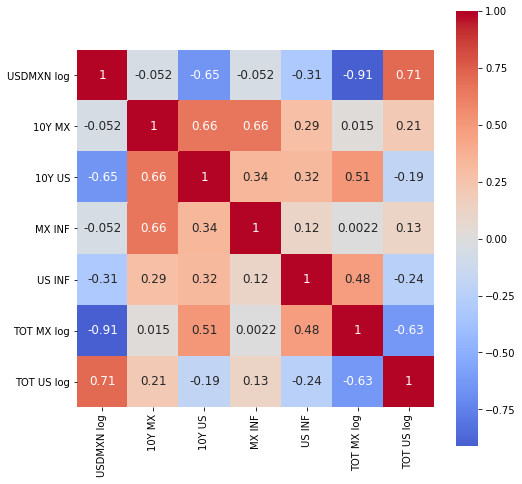

In [18]:
df1 = df1[['USDMXN log', '10Y MX', '10Y US', 'MX INF', 'US INF', 'TOT MX log', 'TOT US log']]
corr = df1.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            center=0, cmap='coolwarm', square=True, annot=True, annot_kws={'size':12})

#### Stationarity

*The stationarity in log return of USD/MXN is visualized*

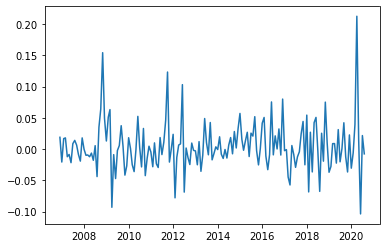

In [19]:
# diff on log-scaled columns to compute log returns
df_diff = df1.diff().dropna()

# plot data to show stationarity, expect to hover around zero
plt.plot(df_diff['USDMXN log'])

*The ADF test is used to confirm the stationarity of all columns under consideration*

In [20]:
adf = {}
for column in df_diff.columns:
    result = adfuller(df_diff[column], 1)
    adf[column] = {
        'statistic': result[0],
        'p-value': result[1],
    }
    for key, value in result[4].items():
        adf[column]['%s critical value' % key] = value
adf = pd.DataFrame(adf)
print(adf.to_string(float_format='{:.3f}'.format))

                    USDMXN log  10Y MX  10Y US  MX INF  US INF  TOT MX log  TOT US log
statistic              -12.239 -12.833 -11.906  -7.541 -10.705      -6.861     -12.739
p-value                  0.000   0.000   0.000   0.000   0.000       0.000       0.000
1% critical value       -3.471  -3.471  -3.471  -3.471  -3.471      -3.471      -3.471
5% critical value       -2.879  -2.879  -2.879  -2.879  -2.879      -2.879      -2.879
10% critical value      -2.576  -2.576  -2.576  -2.576  -2.576      -2.576      -2.576


#### Granger Causality Test

*Granger's causality test sets the null hypothesis that the coefficients in the regression equation of using past values of time series $x$ predicting time series $y$ are zero. Therefore past values of $x$ cannot help predicting $y$. The null hypothesis is rejected if the p-value obtained from the test is less than the significance level of 5%.*

*The following data produce such p-values in the table (response ($y$) are the rows and the predictor ($x$) are columns).*

*From the first row of the tables below, it can be seen that no variable is powerful enough to be used to predict the USD/MXN exchange rate.*

In [21]:
maxlag = 12
test = 'ssr-chi2test'
def grangers_causality_matrix(data, variables, test='ssr_chi2test', verbose=False):
    dataset = {}
    for c in variables:
        dataset[c] = {}
        for r in variables:
            # grangercausalitytests() use second column to predict first column
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [value[0][test][1] for lag,value in test_result.items()]
            if verbose:
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            dataset[c][r] = min(p_values)
    df = pd.DataFrame(dataset)
    df.columns.name = 'Predictor'
    df.index.name = 'Response'
    return df

print("p-value of data:")
print(grangers_causality_matrix(df1, variables = df1.columns).to_string(float_format="{:.4f}".format))
print()
print("p-value of first-order difference:")
print(grangers_causality_matrix(df_diff, variables = df_diff.columns).to_string(float_format="{:.4f}".format))


p-value of data:
Predictor   USDMXN log  10Y MX  10Y US  MX INF  US INF  TOT MX log  TOT US log
Response                                                                      
USDMXN log      1.0000  0.2197  0.3210  0.4940  0.0800      0.0424      0.1360
10Y MX          0.0164  1.0000  0.0000  0.1398  0.1185      0.0208      0.1611
10Y US          0.0122  0.1141  1.0000  0.1631  0.0285      0.0430      0.0232
MX INF          0.5846  0.0003  0.2190  1.0000  0.0027      0.3779      0.1204
US INF          0.0001  0.0802  0.0001  0.1865  1.0000      0.0001      0.0003
TOT MX log      0.0000  0.2298  0.0077  0.3874  0.0039      1.0000      0.0106
TOT US log      0.0000  0.1953  0.0150  0.2666  0.0002      0.0000      1.0000

p-value of first-order difference:
Predictor   USDMXN log  10Y MX  10Y US  MX INF  US INF  TOT MX log  TOT US log
Response                                                                      
USDMXN log      1.0000  0.1147  0.4429  0.4484  0.0830      0.0191      0.1004

### Johansen's Cointegration Test

*This test is used to see if two or more time series are cointegrated. The test should be conducted on the integrated series instead of the first-difference as the area of interest is whether two variables, as opposed to the rate of change, share the same trend. The trace is used in Johansen's cointegration test to accomplish that. the null hypothesis is that there are $r<k$ cointegration vectors and the alternative hypothesis states $r=k$( where $r$ can be zero).*

*The following data produce a table with results. The result is significant if the statistic is greater than the critical value. The largest $k$ for which the null hypothesis is rejected for becomes the value of $r$, i.e., a linear combination of $r$ series is needed to form a stationary series*

In [22]:
def cointegration_test(data, alpha=0.05):
    # Johansen cointegration test on trace
    out = sm.tsa.var.vecm.coint_johansen(data, 0, 5)
    d = {'0.10':1, '0.05':2, '0.01':3}  # column offset for alpha values
    col = d["{:.2f}".format(alpha)]
    result = {
        'statistic': out.lr1,
        'crit-90%': out.cvt[:, 0],
        'crit-95%': out.cvt[:, 1],
        'crit-99%': out.cvt[:, 2],
    }
    result = pd.DataFrame(result, index=range(1, len(out.lr1)+1))
    result = result[['statistic', 'crit-90%', 'crit-95%', 'crit-99%']]
    result['reject H0'] = result.iloc[:, 0] > result.iloc[:, col]
    result.index.name = 'k'
    return result

print(cointegration_test(df1).to_string(float_format="{:.4f}".format))

   statistic  crit-90%  crit-95%  crit-99%  reject H0
k                                                    
1   165.6942  120.3673  125.6185  135.9825       True
2   110.7576   91.1090   95.7542  104.9637       True
3    73.3723   65.8202   69.8189   77.8202       True
4    42.8958   44.4929   47.8545   54.6815      False
5    21.4437   27.0669   29.7961   35.4628      False
6     7.8579   13.4294   15.4943   19.9349      False
7     0.1036    2.7055    3.8415    6.6349      False


#### VAR Model

*Fitting a VAR(p) model and performing in-sample forecasting below. The VAR function of statsmodels package in Python is used to figure out the best order $p$ based on AIC.*

In [23]:
test_size = 0.30
n_obs = int(len(df_diff[df_diff.columns[0]])*test_size)
X_train, X_test = df_diff.iloc[0:-n_obs, :], df_diff.iloc[-n_obs:,:]
print(X_train.shape, X_test.shape)

(116, 7) (49, 7)


In [24]:
X_train.head()

,USDMXN log,10Y MX,10Y US,MX INF,US INF,TOT MX log,TOT US log
date,,,,,,,
2006-11-30,0.018849,-0.20,-0.14,0.0,0.7,-0.003100,0.000000
2006-12-31,-0.020703,-0.34,0.25,0.0,0.0,0.000000,0.000000
2007-01-31,0.016742,0.52,0.11,0.4,0.1,-0.014419,0.015669
2007-02-28,0.017901,0.06,-0.27,0.1,0.3,-0.002628,0.000000
2007-03-31,-0.012193,-0.47,0.10,0.0,0.0,0.000000,0.000000


In [25]:
mod = VAR(X_train)
res = mod.fit(maxlags=5, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 13, Jul, 2020
Time:                     00:02:58
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -30.8717
Nobs:                     113.000    HQIC:                  -33.0804
Log likelihood:           985.879    FPE:                9.85461e-16
AIC:                     -34.5887    Det(Omega_mle):     2.83695e-16
--------------------------------------------------------------------
Results for equation USDMXN log
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.005219         0.003008            1.735           0.083
L1.USDMXN log        -0.020742         0.134560           -0.154           0.877
L1.10Y MX            -0.027112         0.014155        

*Analyzing impulse response. This is to check how the innovation of one variable affects another in the subsequent time intervals. Tranquillity in the graph would reveal that such cause and effect relationship is not significant. A graph falling quickly to zero would mean that the effect is not long-lasting.*

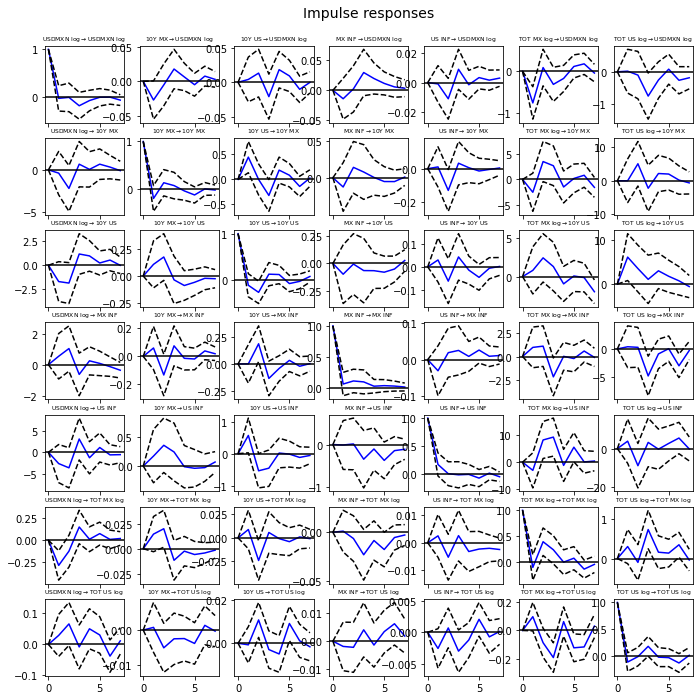

In [26]:
irf = res.irf(7)
irf.plot(orth=False, subplot_params={'fontsize':6})
plt.show()

*Forecast Variance Decomposition explains how much variance in the error can be attributed to shock in each variable.*

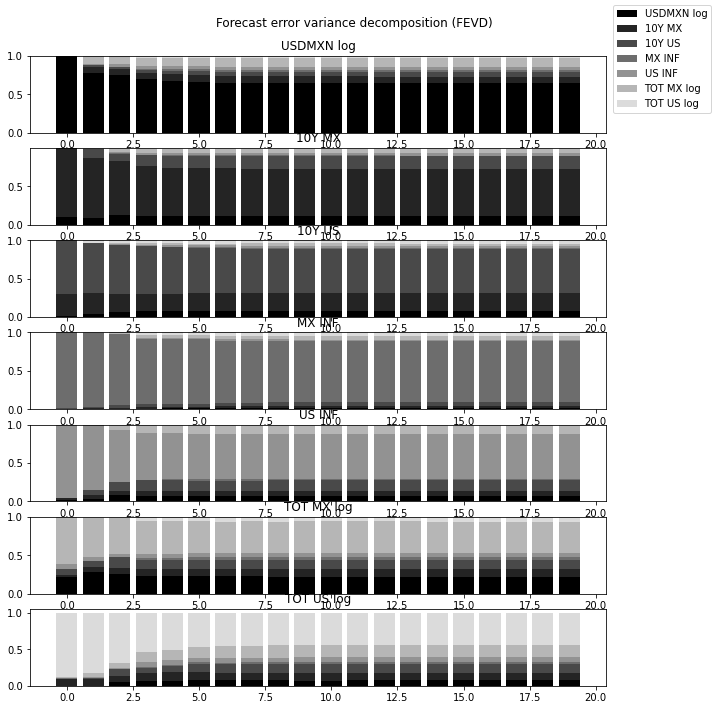

In [27]:
res.fevd(20).plot()
plt.show()

*Below the VAR model is used to forecast for next 10 time periods, and then compared with the actual data*

In [28]:
print("Optimal lag order found based on AIC: {}".format(res.k_ar))

# Forecast, for 10 periods
lag_order = res.k_ar
forecasts = res.forecast(df_diff.values[-lag_order:], 10)

# Convert forecast into actual scale, the compare with actual FX rate
df_forecasts = pd.DataFrame(np.exp(forecasts.cumsum(axis=0)), columns=df1.columns, index=X_test.index[:10])
df_forecasts['USDMXN'] = df_forecasts['USDMXN log'] * np.exp(df1.iloc[-n_obs-1]['USDMXN log'])
df_forecasts['Actual'] = np.exp(df1.loc[df_forecasts.index.min():df_forecasts.index.max()]['USDMXN log'])
df_forecasts[['USDMXN','Actual']]

Optimal lag order found based on AIC: 3


,USDMXN,Actual
date,,
2016-07-31,18.725434,18.73864
2016-08-31,18.793033,18.74253
2016-09-30,18.838798,19.35624
2016-10-31,18.853109,19.17219
2016-11-30,19.011754,20.76872
2016-12-31,19.001779,20.71560
2017-01-31,19.035528,20.69855
2017-02-28,19.108281,19.79560
2017-03-31,19.184530,18.69160


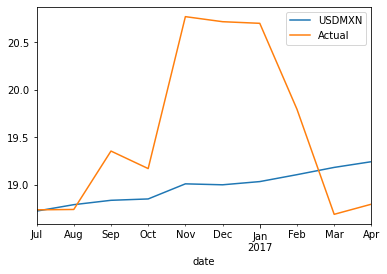

In [29]:
df_forecasts[['USDMXN','Actual']].plot()

#### VEC Model

*From the Johansen test above, it is known that the cointegration has rank 3, which is provided as the argument to the VECM function. Also note that the stationary time series in VAR is used (for example, the FX rate is expressed as monthly returns).*

In [30]:
test_size = 0.10
n_obs = int(len(df1[df1.columns[0]])*test_size)
X_train, X_test = df1.iloc[0:-n_obs, :], df1.iloc[-n_obs:,:]
print(X_train.shape, X_test.shape)

(150, 7) (16, 7)


In [31]:
X_train.head()

,USDMXN log,10Y MX,10Y US,MX INF,US INF,TOT MX log,TOT US log
date,,,,,,,
2006-10-31,2.379546,7.96,4.60,3.5,1.3,4.063198,4.605670
2006-11-30,2.398395,7.76,4.46,3.5,2.0,4.060098,4.605670
2006-12-31,2.377693,7.42,4.71,3.5,2.0,4.060098,4.605670
2007-01-31,2.394435,7.94,4.82,3.9,2.1,4.045679,4.621339
2007-02-28,2.412336,8.00,4.55,4.0,2.4,4.043051,4.621339


In [32]:
vecm = VECM(endog=X_train, k_ar_diff=9, coint_rank=3, deterministic='ci')
vecm_fit = vecm.fit()
print(vecm_fit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation USDMXN log
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.USDMXN log    -0.1243      0.141     -0.881      0.378      -0.401       0.152
L1.10Y MX        -0.0528      0.017     -3.183      0.001      -0.085      -0.020
L1.10Y US         0.0219      0.021      1.021      0.307      -0.020       0.064
L1.MX INF        -0.0196      0.018     -1.095      0.274      -0.055       0.015
L1.US INF        -0.0253      0.009     -2.803      0.005      -0.043      -0.008
L1.TOT MX log    -0.3172      0.214     -1.479      0.139      -0.738       0.103
L1.TOT US log     0.6100      0.459      1.328      0.184      -0.290       1.510
L2.USDMXN log    -0.1858      0.149     -1.248      0.212      -0.478       0.106
L2.10Y MX        -0.0396      0.018     -2.189      0.029      -0.075      -0.004
L2.10Y U

In [33]:
# run prediction using the fitted VECM
forecasts = vecm_fit.predict(steps=len(X_test))
df_forecasts = pd.DataFrame(forecasts, columns=df1.columns, index=X_test.index)
df_forecasts['USDMXN'] = np.exp(df_forecasts['USDMXN log'])
df_forecasts['Actual'] = np.exp(X_test['USDMXN log'])
df_forecasts

,USDMXN log,10Y MX,10Y US,MX INF,US INF,TOT MX log,TOT US log,USDMXN,Actual
date,,,,,,,,,
2019-04-30,2.998543,8.549983,2.485326,3.783754,1.624589,3.870919,4.665868,20.056292,18.98601
2019-05-31,2.910299,8.239478,2.473627,3.876909,2.356083,3.914206,4.655543,18.362294,19.58660
2019-06-30,2.905489,8.023268,2.275926,3.965064,2.645041,3.934625,4.654977,18.274182,19.19194
2019-07-31,2.934107,8.022730,2.285150,4.118891,3.356848,3.944245,4.643691,18.804700,19.20928
2019-08-31,2.939736,8.046459,2.420027,4.168667,3.379943,3.927770,4.627243,18.910849,20.03503
2019-09-30,2.962980,8.092225,2.208296,4.174164,3.651200,3.916249,4.623044,19.355567,19.79399
2019-10-31,2.984288,7.954765,1.885789,4.295837,3.449467,3.910916,4.614534,19.772417,19.08266
2019-11-30,2.973848,7.520248,1.697749,4.402512,3.070755,3.890580,4.608073,19.567060,19.51959
2019-12-31,2.999081,7.328251,1.694675,4.401284,2.912953,3.888166,4.605704,20.067096,18.93287


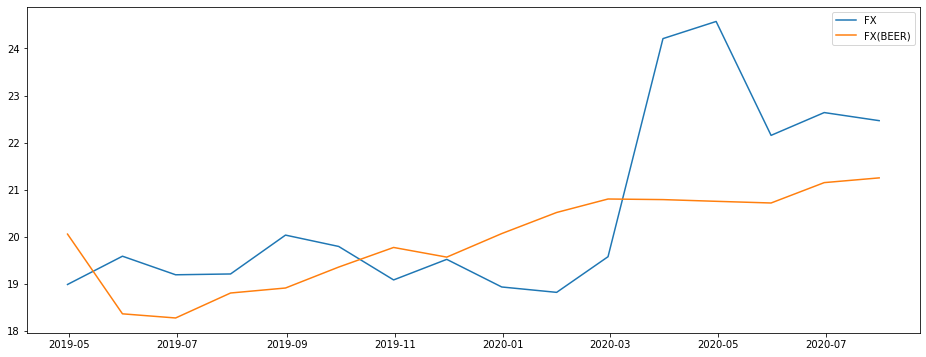

In [34]:
plt.figure(figsize=(16,6))
actual_fx, = plt.plot(df_forecasts['Actual'])
forecasts, = plt.plot(df_forecasts['USDMXN'])
plt.legend(['FX', 'FX(BEER)'])